Autores: ....

# EDA

### Normalización de datos y validación

* Utilizamos info() para revisar la estructura y los tipos de datos del conjunto.
    * Los detalles concretos con shape, columns o dtypes.
* Clasificación de región en Regiones y Ciudades
* Explorar datos, fechas, nulos, columnas innecesarias
* Discusión sobre qué hacer con los datos de semanas que faltan (interpolante)

##### Mostrar la estructura de datos del dataset avocados

In [374]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import avocado_manager as av

color_orga ='green'; color_conv ='orange'; color_total ='blue'
av.init()
df_cp = av.df("df_cp")
print(df_cp.info())

df_cp_cleaned = df_cp
df_cp_cleaned['Suma Volums'] = df_cp_cleaned['Volume_Hass_S' ]+ df_cp_cleaned['Volume_Hass_L']+ df_cp_cleaned['Volume_Hass_XL' ]
df_cp_cleaned['Variacio'] = (df_cp_cleaned['Total Volume'] - df_cp_cleaned['Suma Volums'])*100/df_cp_cleaned['Total Volume']
av.add(df_cp_cleaned,'df_cleaned')

region_largest= df_cp.groupby('region')['Total Volume'].sum().nlargest(10).index
av.add(region_largest,'df_region_largest')
smallest_regions= df_cp_cleaned[df_cp_cleaned['region'].isin(region_largest)]
av.add(smallest_regions,'df_smallest_regions')

av.info()
#small_group = df_cp_cleaned.groupby('region')['Variacio'].mean().sort_values()
#small_group

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           18249 non-null  int64         
 1   Date            18249 non-null  datetime64[ns]
 2   AveragePrice    18249 non-null  float64       
 3   Total Volume    18249 non-null  float64       
 4   Volume_Hass_S   18249 non-null  float64       
 5   Volume_Hass_L   18249 non-null  float64       
 6   Volume_Hass_XL  18249 non-null  float64       
 7   Total Bags      18249 non-null  float64       
 8   Small Bags      18249 non-null  float64       
 9   Large Bags      18249 non-null  float64       
 10  XLarge Bags     18249 non-null  float64       
 11  type            18249 non-null  object        
 12  year            18249 non-null  int64         
 13  region          18249 non-null  object        
 14  region_class    18249 non-null  object        
 15  Su

In [241]:
data_shape = df_cp.shape
print(f"\nForma del DataFrame (filas, columnas): {data_shape}")

column_names = df_cp.columns
print(f"\nNombres de Columnas: {column_names}")
 
data_types = df_cp.dtypes
print(f"\nTipos de datos de cada columna:\n{data_types}")

#df_cp.head()
#df_cp.info()
#df_cp.describe()


Forma del DataFrame (filas, columnas): (18249, 18)

Nombres de Columnas: Index(['index', 'Date', 'AveragePrice', 'Total Volume', 'Volume_Hass_S',
       'Volume_Hass_L', 'Volume_Hass_XL', 'Total Bags', 'Small Bags',
       'Large Bags', 'XLarge Bags', 'type', 'year', 'region', 'region_class',
       'Suma Volums', 'Variacio', 'RegionClass'],
      dtype='object')

Tipos de datos de cada columna:
index                      int64
Date              datetime64[ns]
AveragePrice             float64
Total Volume             float64
Volume_Hass_S            float64
Volume_Hass_L            float64
Volume_Hass_XL           float64
Total Bags               float64
Small Bags               float64
Large Bags               float64
XLarge Bags              float64
type                      object
year                       int64
region                    object
region_class              object
Suma Volums              float64
Variacio                 float64
RegionClass               object
dtype:

##### Nuestra clasifiacion de clases de regiones

In [242]:
#display(df_cp)
print("Nuestra clasifiacion de clases de regiones:",pd.unique(df_cp['region_class']))
#display(df_cp.head(5))
#display(av.region_classification['GreatRegions'])
g_regions = {key: value for key, value in av.region_classification.items() if value == 'GreaterRegion'}
display(g_regions)
regions = {key: value for key, value in av.region_classification.items() if value == 'Region'}
display(regions)

Nuestra clasifiacion de clases de regiones: ['City' 'Region' 'GreaterRegion' 'TotalUS']


{'California': 'GreaterRegion',
 'GreatLakes': 'GreaterRegion',
 'Midsouth': 'GreaterRegion',
 'Northeast': 'GreaterRegion',
 'Plains': 'GreaterRegion',
 'SouthCentral': 'GreaterRegion',
 'Southeast': 'GreaterRegion',
 'West': 'GreaterRegion'}

{'BaltimoreWashington': 'Region',
 'BuffaloRochester': 'Region',
 'CincinnatiDayton': 'Region',
 'DallasFtWorth': 'Region',
 'HarrisburgScranton': 'Region',
 'HartfordSpringfield': 'Region',
 'MiamiFtLauderdale': 'Region',
 'NewOrleansMobile': 'Region',
 'NorthernNewEngland': 'Region',
 'PhoenixTucson': 'Region',
 'RaleighGreensboro': 'Region',
 'RichmondNorfolk': 'Region',
 'SouthCarolina': 'Region',
 'WestTexNewMexico': 'Region'}

##### Mostrar las Regions top 10 por Total Volume

In [243]:
df_totales = df_cp.groupby('region')['Total Volume'].sum().reset_index()
display(df_totales.nlargest(10,'Total Volume').sort_values(by='Total Volume', ascending = False))
#df_largest = av.df("region_largest")
#display(df_largest)

region  Total Volume
51       TotalUS  5.864740e+09
52          West  1.086779e+09
6     California  1.028982e+09
45  SouthCentral  1.011280e+09
29     Northeast  7.132809e+08
46     Southeast  6.152384e+08
15    GreatLakes  5.896425e+08
25      Midsouth  5.083494e+08
22    LosAngeles  5.078965e+08
35        Plains  3.111885e+08

##### Identificar fechas faltantes por cada region

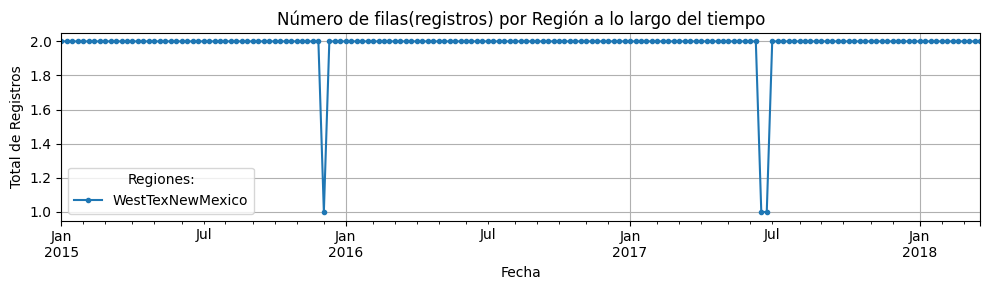

In [244]:
df_count = df_cp.groupby(['Date', 'region']).size().reset_index(name='Total')
df_pivot = df_count.pivot(index='Date', columns='region', values='Total').fillna(0)
diferencias = df_pivot.apply(lambda x: x.nunique() > 1, axis=0)

regiones_con_diferencias = diferencias[diferencias].index.tolist()
df_pivot[regiones_con_diferencias].plot(kind='line', marker='.',figsize=(10, 3))
plt.title('Número de filas(registros) por Región a lo largo del tiempo', fontweight = "bold")
plt.xlabel('Fecha')
plt.ylabel('Total de Registros')
plt.legend(title='Regiones:')
plt.grid(); plt.tight_layout() #plt.xticks(rotation=90)
plt.show()

##### Análisis exploratorio para entender la estructura del conjunto, incluyendo el número de filas y columnas, tipos de datos y valores faltantes. 

* Imprime la cantidad de valores faltantes por columna utilizando isnull().

In [245]:
print(f"Cantidad de nulls: {df_cp.isnull().sum()}")
#df.isnull
#missing_values = pd.isnull(df)

# Resumen Estadístico
data_summary = df_cp.describe()
print("\nResumen Estadístico:")
print(data_summary)

Cantidad de nulls: index             0
Date              0
AveragePrice      0
Total Volume      0
Volume_Hass_S     0
Volume_Hass_L     0
Volume_Hass_XL    0
Total Bags        0
Small Bags        0
Large Bags        0
XLarge Bags       0
type              0
year              0
region            0
region_class      0
Suma Volums       0
Variacio          0
RegionClass       0
dtype: int64

Resumen Estadístico:
              index                           Date  AveragePrice  \
count  18249.000000                          18249  18249.000000   
mean    9124.000000  2016-08-13 23:30:43.498273792      1.405978   
min        0.000000            2015-01-04 00:00:00      0.440000   
25%     4562.000000            2015-10-25 00:00:00      1.100000   
50%     9124.000000            2016-08-14 00:00:00      1.370000   
75%    13686.000000            2017-06-04 00:00:00      1.660000   
max    18248.000000            2018-03-25 00:00:00      3.250000   
std     5268.176867                       

In [246]:
# # series de tiempo
# print("\nseries de tiempo:")
# df_cp['Date'] = pd.to_datetime(df_cp['Date'])
# ventas_mensual = df_cp.groupby(df_cp['Date'].dt.to_period("M"))['Total Volume'].sum().reset_index()
# display(ventas_mensual)

###  Verificar que Total Bags = Small Bags + Large Bags + XLarge Bags

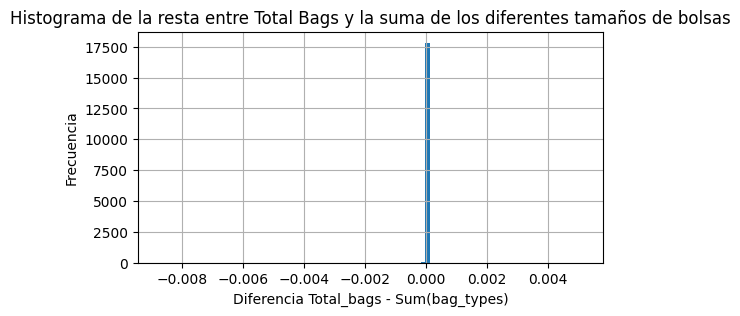

In [247]:
df_cp_cleaned = av.df("df_cp_cleaned")
bags_df = df_cp_cleaned.copy()
bags_df['Suma Bags'] = bags_df['Small Bags']+ bags_df['Large Bags']+ bags_df['XLarge Bags']
bags_df['Variacio Bags'] = ((bags_df['Total Bags'] - bags_df['Suma Bags'])*100)/bags_df['Total Bags']
fig, ax= plt.subplots(figsize=(6,3))
bags_df['Variacio Bags'].hist(bins=100)
plt.ylabel('Frecuencia')
plt.xlabel('Diferencia Total_bags - Sum(bag_types)')
plt.title("Histograma de la resta entre Total Bags y la suma de los diferentes tamaños de bolsas", fontweight = "bold")
plt.show()

# ANALISIS

### Visión global de datos

##### Diferencia entre la suma de "volumen total" de "grandes regiones" y "regiones" con total US
* Observado: IMPORTANTE VOLUMEN VENTAS GREATERREGIONS == TOTALUS

In [248]:
df_great_regions = df_cp[(df_cp['region_class']=='GreaterRegion')] # | (df_cp['region_class']=='City')]
#display(df_great_regions)
df_USA = df_cp[df_cp['region']=='TotalUS']
print((df_great_regions['Total Volume'].sum() - df_USA['Total Volume'].sum())*100/df_USA['Total Volume'].sum(),"%" )


3.751252636661604e-09 %


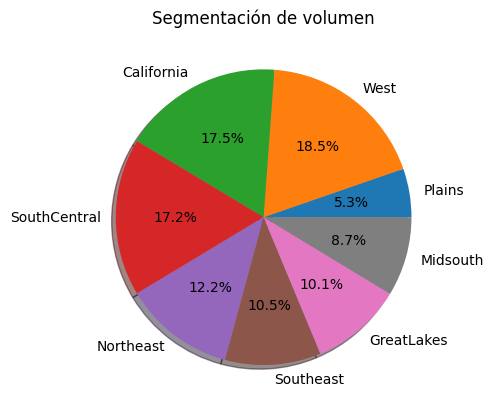

In [249]:
index_df= df_cp.copy()
index_df= index_df[index_df['region_class']=='City']
# region_largest.pop('TotalUS')

df_greatest_pie = df_cp.groupby('region')['Total Volume'].sum().nlargest(8)   #df_cp[df_cp['region'].isin(region_largest)]
df_greatest_pie.loc['TotalUS'] = 2*df_greatest_pie.loc['TotalUS'] - df_greatest_pie.loc[:].sum()
df_greatest_pie.rename( index={'TotalUS':'Plains'}, inplace=True)
df_greatest_pie.plot.pie(title="Market size", legend=False, \
                   autopct='%1.1f%%', \
                   shadow=True, startangle=0)
#plt.legend(loc='best'); plt.grid(True) # figsize=(12,6)
plt.title("Segmentación de volumen", fontweight = "bold")
plt.ylabel("")
plt.show()
#region_largest= list(index_df.groupby('region')['Total Volume'].sum().nlargest(3).index)


##### Correlación de "Volumen Total" de las grandes regiones con Volumen de "Total US" (alvocado conventional)

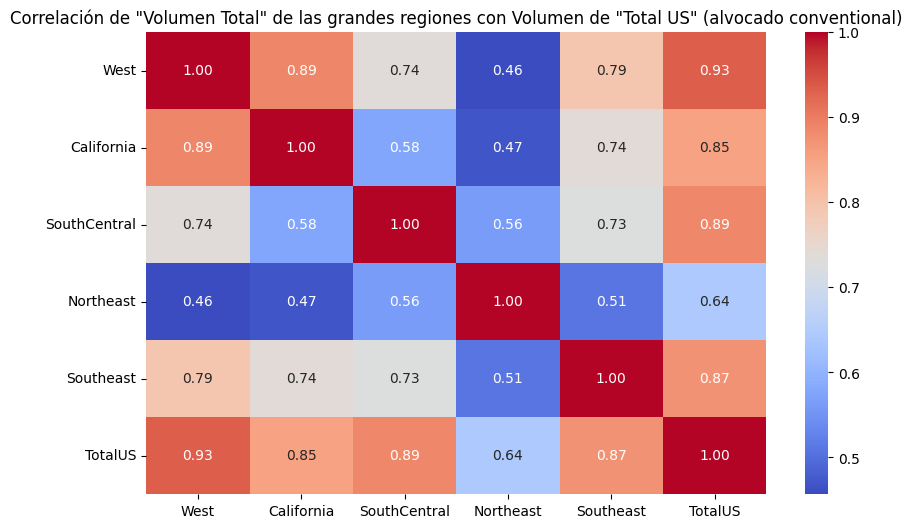

Variables altamente correlacionadas con otras: ['West', 'TotalUS']


In [250]:
prova_= df_cp.copy()
index_df= df_cp.copy()
prova_= prova_[prova_['type']=='conventional']
dictionary_to_regions={}

index_df= index_df[index_df['region_class']=='GreaterRegion']
region_largest= list(index_df.groupby('region')['Total Volume'].sum().nlargest(5).index)
region_largest.append('TotalUS')

for region in region_largest:
    prova_temp = prova_[prova_['region']==region]
    prova_temp=prova_temp.sort_values(by='Date')

    dictionary_to_regions[region] = list(prova_temp['Total Bags'])

df_corr = pd.DataFrame(dictionary_to_regions)
# display(df_corr)
corr_matrix = df_corr.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlación de "Volumen Total" de las grandes regiones con Volumen de "Total US" (alvocado conventional)', fontweight = "bold")
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.9
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

##### Precios promedio calibre tanto Convencional como Orgánico

In [251]:
df_avocado_size = df_cp.copy()
df_avocado_size['Volume_Hass_S ratio'] = df_avocado_size['Volume_Hass_S'] / df_avocado_size['Total Volume']
df_avocado_size['Volume_Hass_L ratio'] = df_avocado_size['Volume_Hass_L'] / df_avocado_size['Total Volume']
df_avocado_size['Volume_Hass_XL ratio'] = df_avocado_size['Volume_Hass_XL'] / df_avocado_size['Total Volume']

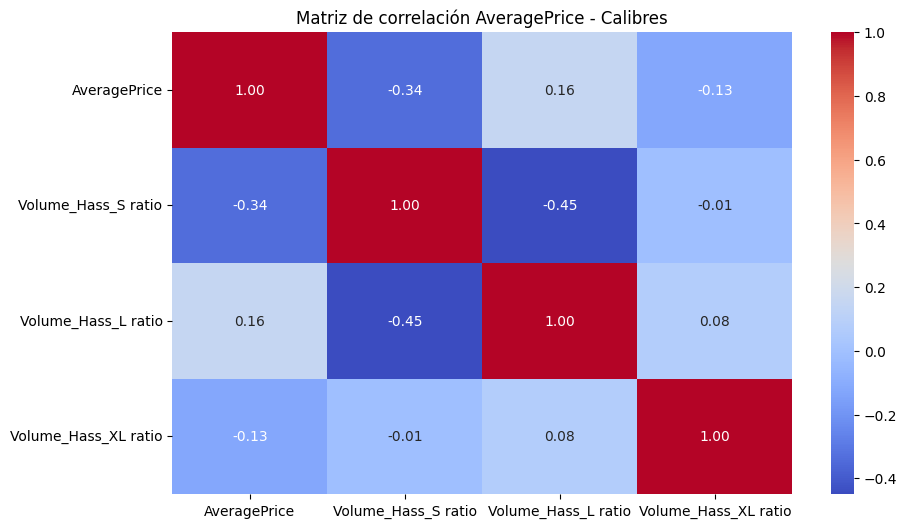

Variables altamente correlacionadas con otras: []


In [252]:
corr_df= df_avocado_size[['AveragePrice', 'Volume_Hass_S ratio', 'Volume_Hass_L ratio', 'Volume_Hass_XL ratio']]
# Calcular la matriz de correlación
corr_matrix = corr_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación AveragePrice - Calibres', fontweight = "bold")
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

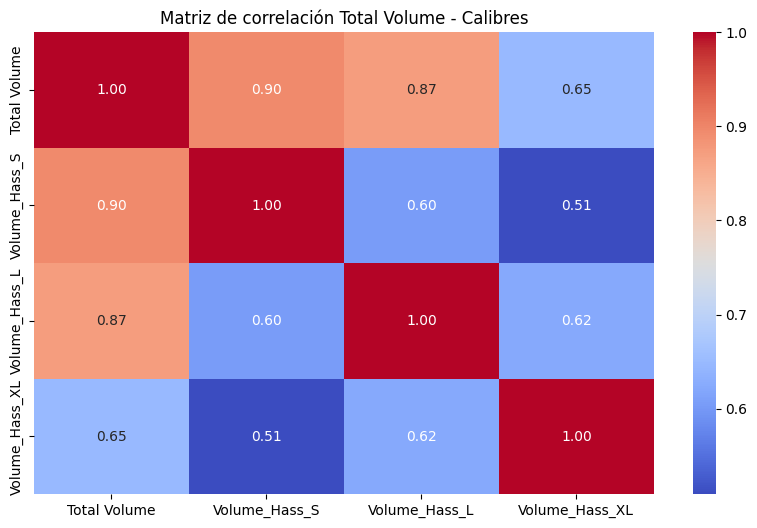

Variables altamente correlacionadas con otras: ['Total Volume', 'Volume_Hass_S', 'Volume_Hass_L']


In [253]:
corr_df= df_cp_cleaned[['Total Volume', 'Volume_Hass_S', 'Volume_Hass_L', 'Volume_Hass_XL']]
# Calcular la matriz de correlación
corr_matrix = corr_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación Total Volume - Calibres', fontweight = "bold")
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

##### Proporción de calibres sobre Total Volume

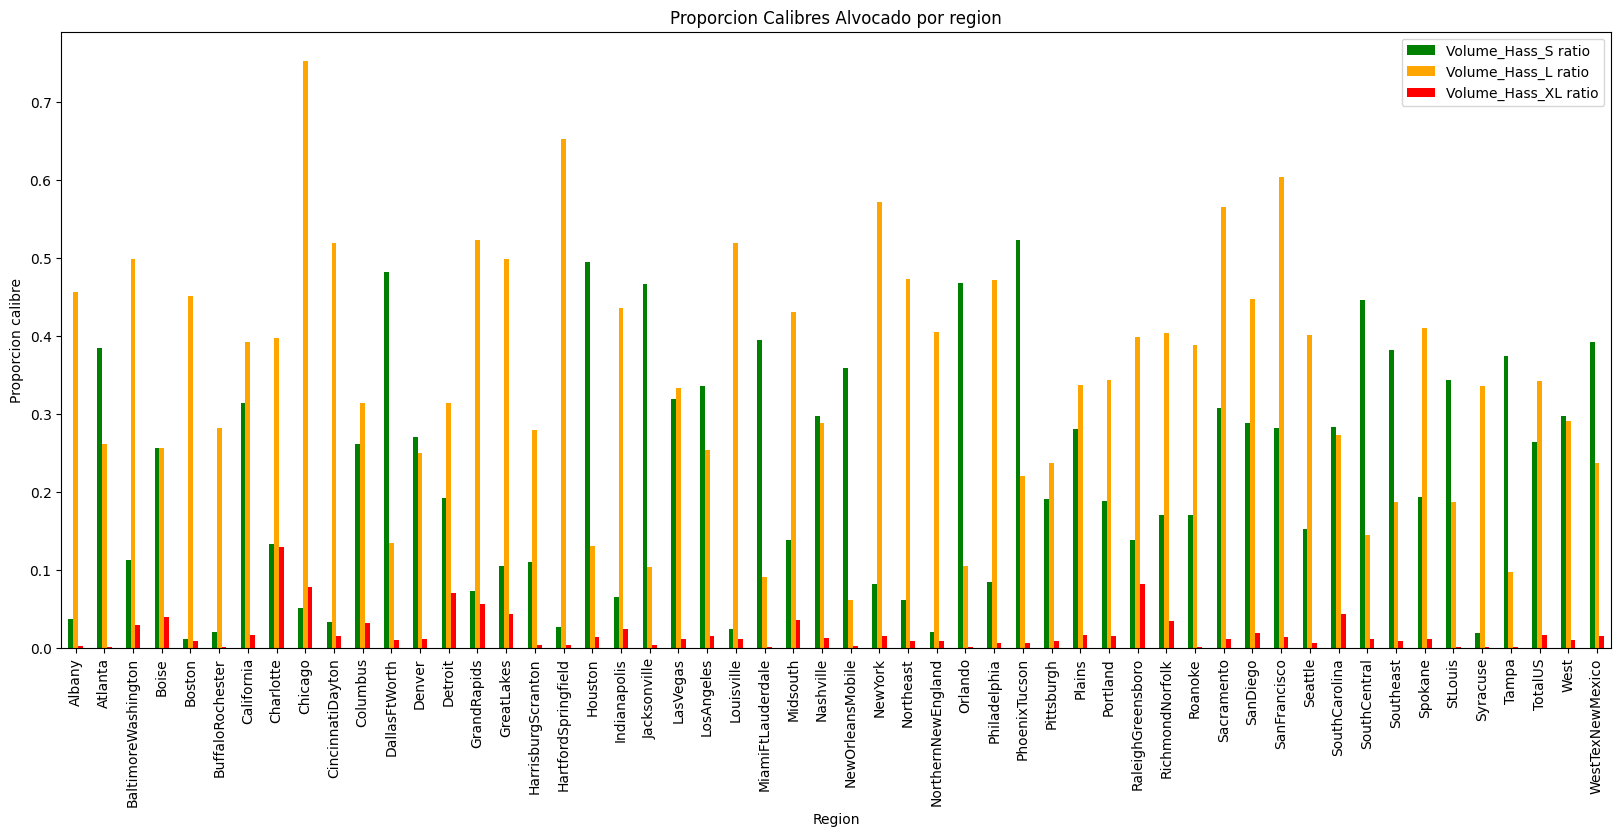

In [254]:
fig, ax= plt.subplots(figsize=(20,8))
ratio_bag=df_avocado_size.groupby('region')[['Volume_Hass_S ratio', 'Volume_Hass_L ratio', 'Volume_Hass_XL ratio']].mean()
ratio_bag.plot(kind='bar', color=['green', 'orange', 'red'],ax=ax )
plt.title('Proporcion Calibres Alvocado por region', fontweight = "bold")
plt.ylabel('Proporcion calibre')
plt.xlabel('Region')
plt.show()

##### Proporción por tipo de bolsa sobre Total Bags

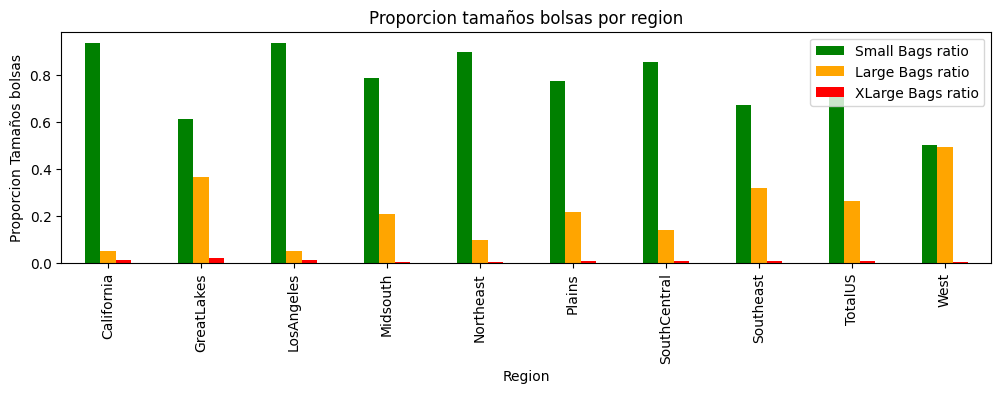

In [255]:
df_baggy = df_cp.copy()
region_largest= df_cp.groupby('region')['Total Volume'].sum().nlargest(10).index
df_baggy = df_baggy[df_baggy['region'].isin(region_largest)]

df_baggy['Small Bags ratio'] = df_baggy['Small Bags'] / df_baggy['Total Bags']
df_baggy['Large Bags ratio'] = df_baggy['Large Bags'] / df_baggy['Total Bags']
df_baggy['XLarge Bags ratio'] = df_baggy['XLarge Bags'] / df_baggy['Total Bags']

fig, ax= plt.subplots(figsize=(12,3))
ratio_bag=df_baggy.groupby('region')[['Small Bags ratio','Large Bags ratio', 'XLarge Bags ratio']].mean()
ratio_bag.plot(kind='bar', color=['green', 'orange', 'red'],ax=ax )
plt.title('Proporcion tamaños bolsas por region', fontweight = "bold")
plt.ylabel('Proporcion Tamaños bolsas')
plt.xlabel('Region')
plt.show()

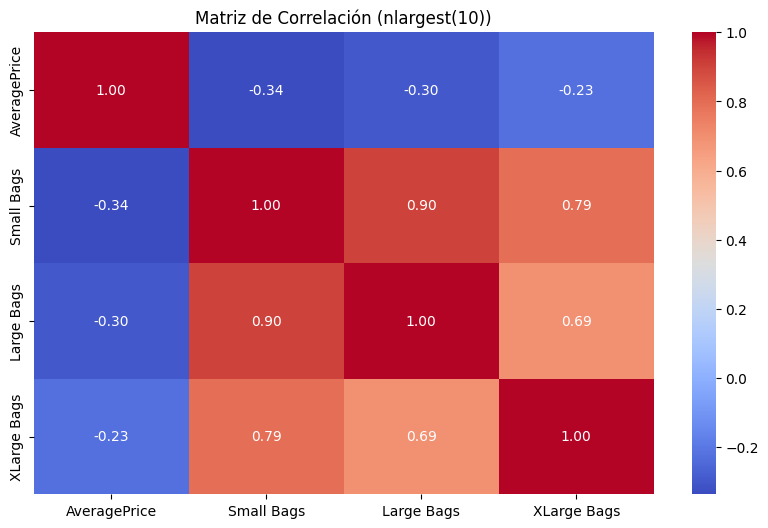

Variables altamente correlacionadas con otras: ['Small Bags', 'Large Bags']


In [256]:
corr_df= df_baggy[['AveragePrice', 'Small Bags', 'Large Bags', 'XLarge Bags']]
# Calcular la matriz de correlación
corr_matrix = corr_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación (nlargest(10))', fontweight = "bold")
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

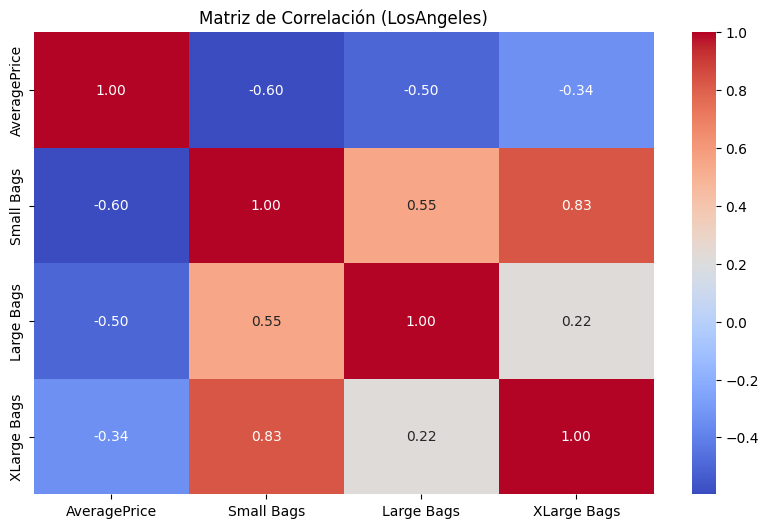

Variables altamente correlacionadas con otras: ['Small Bags', 'XLarge Bags']


In [257]:
df_baggy = df_cp.copy()
region_largest= df_cp.groupby('region')['Total Volume'].sum().nlargest(10).index
df_baggy = df_baggy[df_baggy['region'].isin(region_largest)]

df_baggy['Small Bags ratio'] = df_baggy['Small Bags'] / df_baggy['Total Bags']
df_baggy['Large Bags ratio'] = df_baggy['Large Bags'] / df_baggy['Total Bags']
df_baggy['XLarge Bags ratio'] = df_baggy['XLarge Bags'] / df_baggy['Total Bags']

df_baggy=df_baggy[df_baggy['region']=='LosAngeles']

corr_df= df_baggy[['AveragePrice', 'Small Bags', 'Large Bags', 'XLarge Bags']]
# Calcular la matriz de correlación
corr_matrix = corr_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación (LosAngeles)', fontweight = "bold")
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

##### Precio medio y volumen total
Observaciones:
* Estamos mostrado los de tipo convencional. Que son los grupos de puntos de la parte derecha ? TotalUS y Grandes Regions.

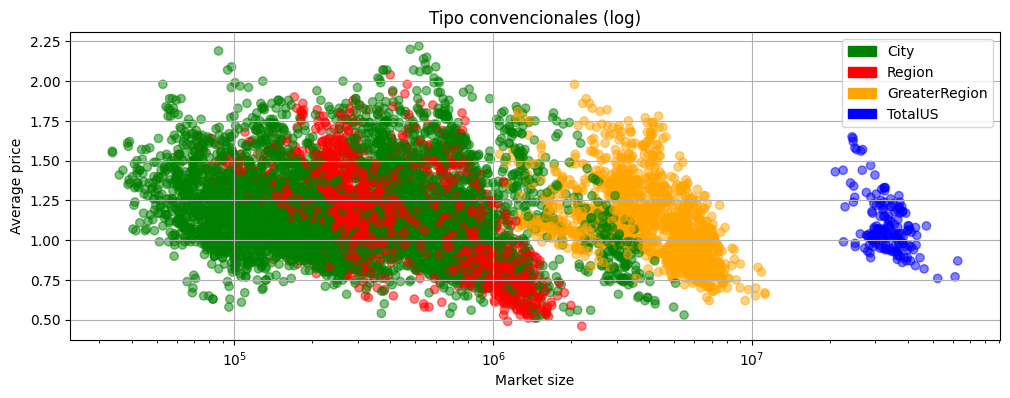

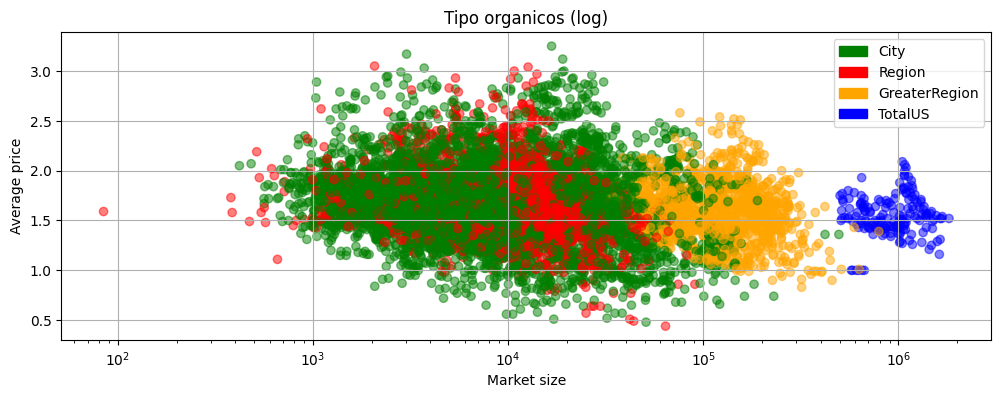

In [258]:
# df_cp_tmp = df_cp[df_cp['type']=='conventional']

# fig, ax = plt.subplots(1, 2, figsize=(18, 6))
# ax[0].scatter(df_cp_tmp['AveragePrice'], df_cp_tmp['Total Volume'], alpha=0.5)
# ax[0].set_title('Relación entre Precio medio y volumen total de no organicos')
# ax[0].set_xlabel('Averag ePrice')
# ax[0].set_ylabel('Total Volume')
# ax[0].grid()

# ax[1].scatter(df_cp_tmp['AveragePrice'], df_cp_tmp['Total Volume'], alpha=0.5)
# ax[1].set_title('Relación entre Precio medio y volumen total de no organicos (Log)')
# ax[1].set_xlabel('Averag ePrice')
# ax[1].set_ylabel('Total Volume')
# ax[1].grid()
# ax[1].set_yscale('log')

# plt.tight_layout()
# plt.show()
# # df_cp.groupby(by=['region']).count()

classification_colors = {'City':'green' ,'Region':'red' ,'GreaterRegion':'orange', 'TotalUS': 'blue'}

df_subset = df_cp.copy()
#df_subset = av.df("df_city_region") 
#df_subset = df_cp[df_cp['region']!= 'TotalUS']

df_organic = df_subset[df_subset['type']=='organic']
df_convencionals = df_subset[df_subset['type']=='conventional']

fig, ax= plt.subplots(figsize=(12,4))
x_values = df_convencionals['Total Volume']
y_values = df_convencionals['AveragePrice']
c_values= list(df_convencionals['region_class'].map(classification_colors))
plt.scatter(x= x_values, y= y_values, c=c_values, alpha = .5)
plt.title('Tipo convencionales (log)', fontweight = "bold")
plt.xscale('log')
plt.ylabel('Average price')
plt.xlabel('Market size')
legend_patches = [mpatches.Patch(color=color, label=region) for region, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='upper right')
plt.grid()
plt.show()

fig, ax= plt.subplots(figsize=(12,4))
x_values = df_organic['Total Volume']
y_values = df_organic['AveragePrice']
c_values= list(df_organic['region_class'].map(classification_colors))
plt.scatter(x= x_values, y= y_values, c=c_values, alpha = .5)
plt.title('Tipo organicos (log)', fontweight = "bold")
plt.xscale('log')
plt.ylabel('Average price')
plt.xlabel('Market size')
legend_patches = [mpatches.Patch(color=color, label=region) for region, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='upper right')
plt.grid()
plt.show()

##### Separar avocados convencionales y organicos
Observaciones:
* TODO: Aqui es veu clarament que el alvocat més relevant es el convencional per ordres de magnitud, per ho que seria relevant fer algún estudi del subset eliminant els organics o estudian-los per separat.
* Addicionalment, l'any 2018 no esta complert, pot afectar a les dades.

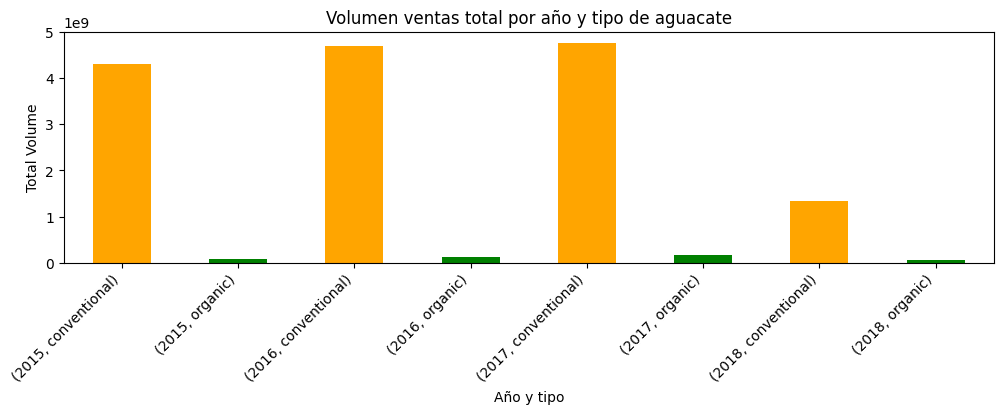

In [259]:
grouped = df_cp.groupby(['year', 'type'])['Total Volume'].sum()
fig, ax= plt.subplots(figsize=(12,3))
grouped.plot(kind='bar', color=[color_conv, color_orga])
plt.xlabel('Año y tipo')
plt.ylabel('Total Volume')
plt.title('Volumen ventas total por año y tipo de aguacate', fontweight = "bold")
plt.xticks(rotation=45, ha='right')
plt.show()

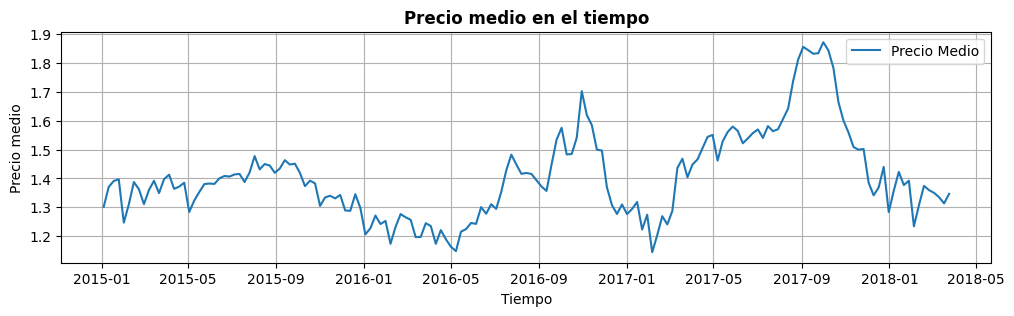

/tmp/ipykernel_789/2164066208.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_grouped = df_cp.groupby(pd.Grouper(key='Date', freq='M'))['AveragePrice'].mean()


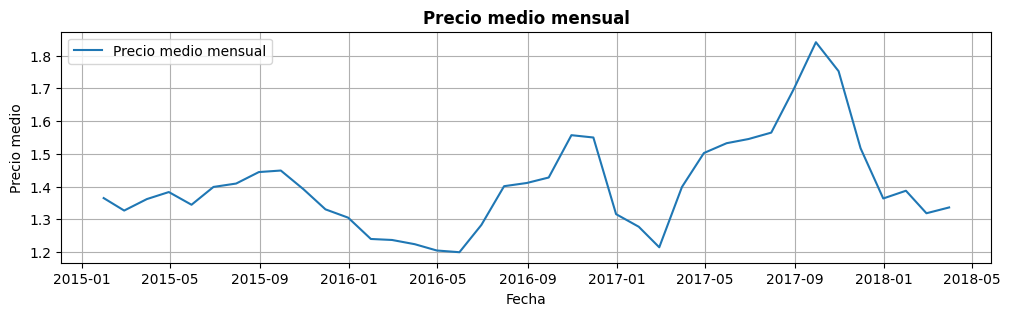

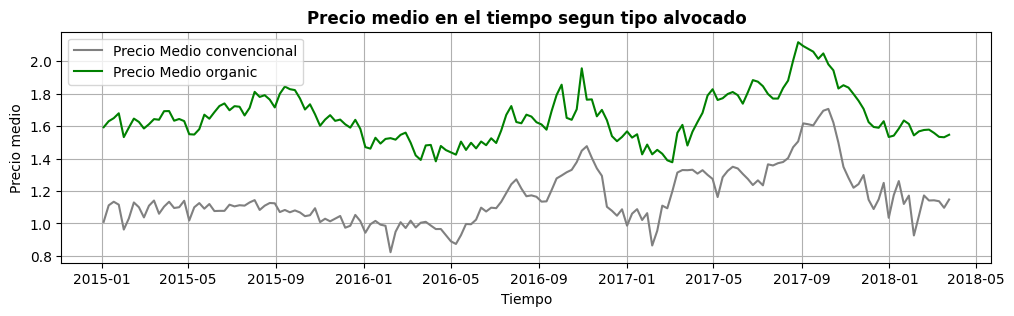

In [381]:
df_grouped = df_cp.groupby('Date')['AveragePrice'].mean()

plt.figure(figsize=(12, 3))
plt.plot(df_grouped, label ='Precio Medio')
plt.legend(loc='best')
plt.xlabel('Tiempo')
plt.ylabel('Precio medio')
plt.title('Precio medio en el tiempo', fontweight = "bold")
plt.grid(True); plt.xticks(rotation=0)
plt.show()

df_grouped = df_cp.groupby(pd.Grouper(key='Date', freq='M'))['AveragePrice'].mean()
plt.figure(figsize=(12,3))
plt.plot(df_grouped, label='Precio medio mensual') #plt.plot(df_grouped.index, df_grouped.values)
plt.legend(loc='best')
plt.xlabel('Fecha')
plt.ylabel('Precio medio')
plt.title('Precio medio mensual', fontweight = "bold")
plt.grid(True); plt.xticks(rotation=0)
plt.show()

df_cp_conventional = df_cp[df_cp['type'] =='conventional'] #[['Date', 'AveragePrice']]
df_grouped_conv = df_cp_conventional.groupby('Date')['AveragePrice'].mean()

df_cp_organic = df_cp[df_cp['type'] =='organic'] #[['Date', 'AveragePrice']]
df_grouped_orga = df_cp_organic.groupby('Date')['AveragePrice'].mean()

plt.figure(figsize=(12, 3))
plt.plot(df_grouped_conv, label ='Precio Medio convencional', color ='grey')
plt.plot(df_grouped_orga, label ='Precio Medio organic', color ='green')
plt.legend(loc='best')
plt.xlabel('Tiempo')
plt.ylabel('Precio medio')
plt.title('Precio medio en el tiempo segun tipo alvocado', fontweight = "bold")
plt.grid(True); plt.xticks(rotation=0)
plt.show()

#df_grouped

##### Comparación precios promedio convencional y organico
Observaciones:
* TODO: Aqui veiem que existeixen unes regions mes relevants que altres. Caldria fer una separació?
* TODO: Excloure TotalUS ??

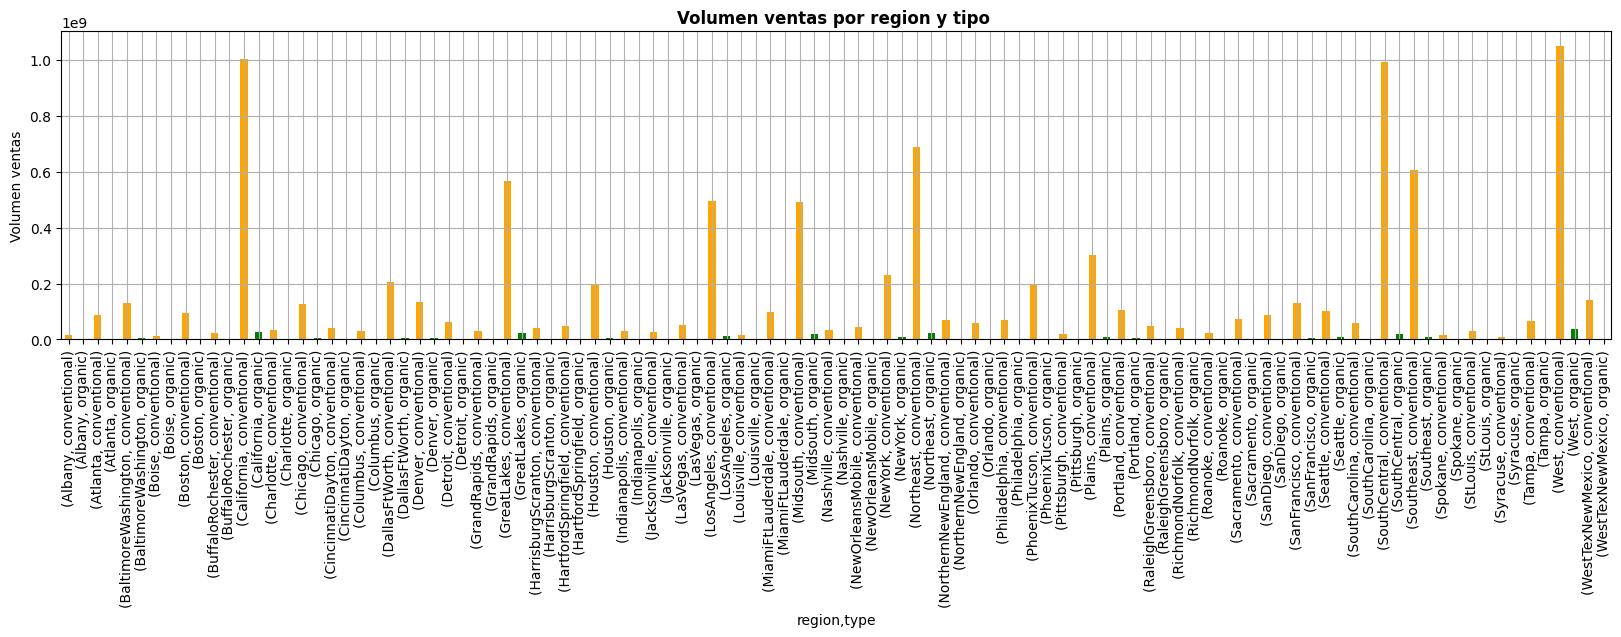

In [382]:
df_subset = df_cp
df_subset = df_cp[df_cp['region']!= 'TotalUS']
pd.unique(df_subset['region'])

grouped = df_subset.groupby(['region', 'type'])['Total Volume'].sum()

fig, ax= plt.subplots(figsize=(20,4))
grouped.plot(kind='bar', ax=ax, color = [color_conv, color_orga] )
# plt.ylim(0, 0.3*10**9)
# plt.yscale('log')
plt.title('Volumen ventas por region y tipo ', fontweight = "bold")
plt.ylabel('Volumen ventas')
plt.grid()
plt.show()

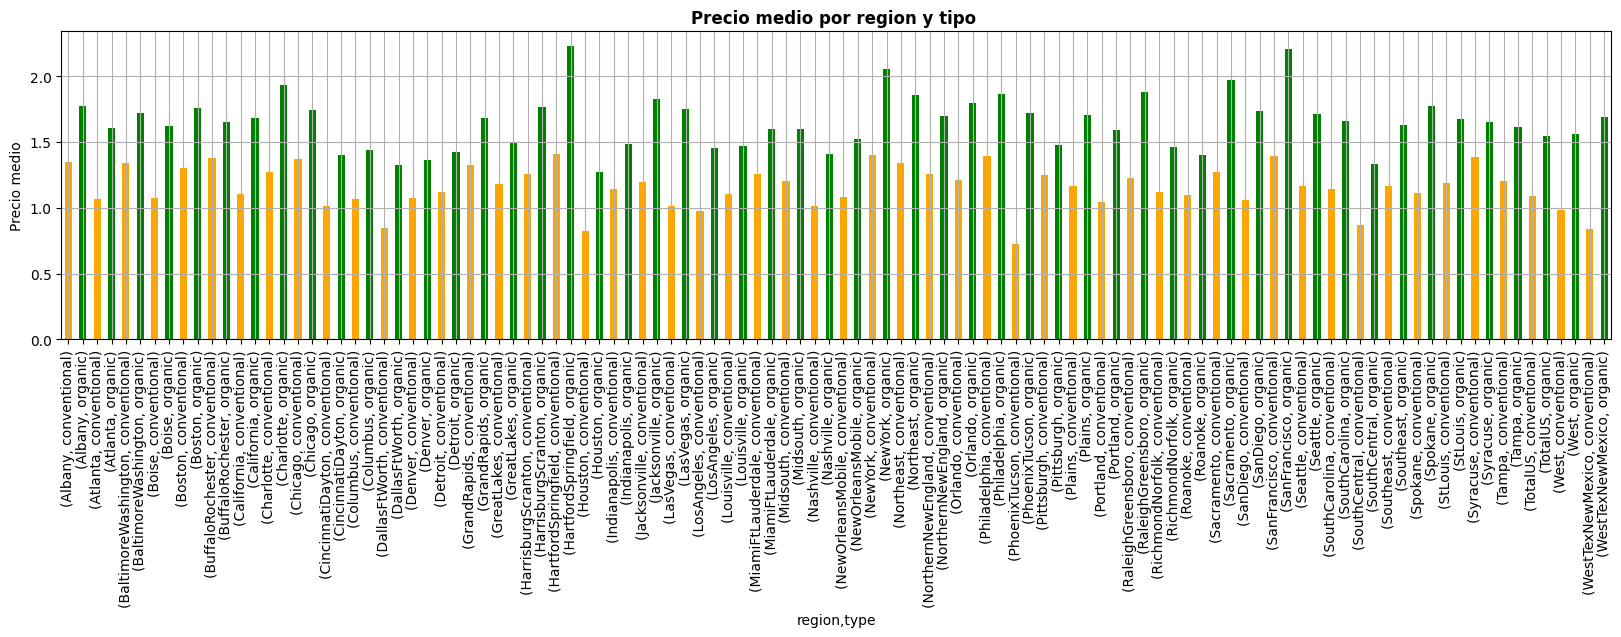

In [383]:
df_subset = df_cp
price_group = df_subset.groupby(['region', 'type'])['AveragePrice'].mean()#.nlargest(10)

fig, ax= plt.subplots(figsize=(20,4))
price_group.plot(kind='bar', ax=ax, color = [color_conv, color_orga] )
plt.title('Precio medio por region y tipo ', fontweight = "bold")
plt.ylabel('Precio medio')
# plt.ylim(0, 0.3*10**9)
plt.grid()
plt.show()

Observaciones:
* TODO: Aquest gràfic es espectacular, y ens permet veure que sempre són els alvocats orgànics els que costen més que la mitjana.

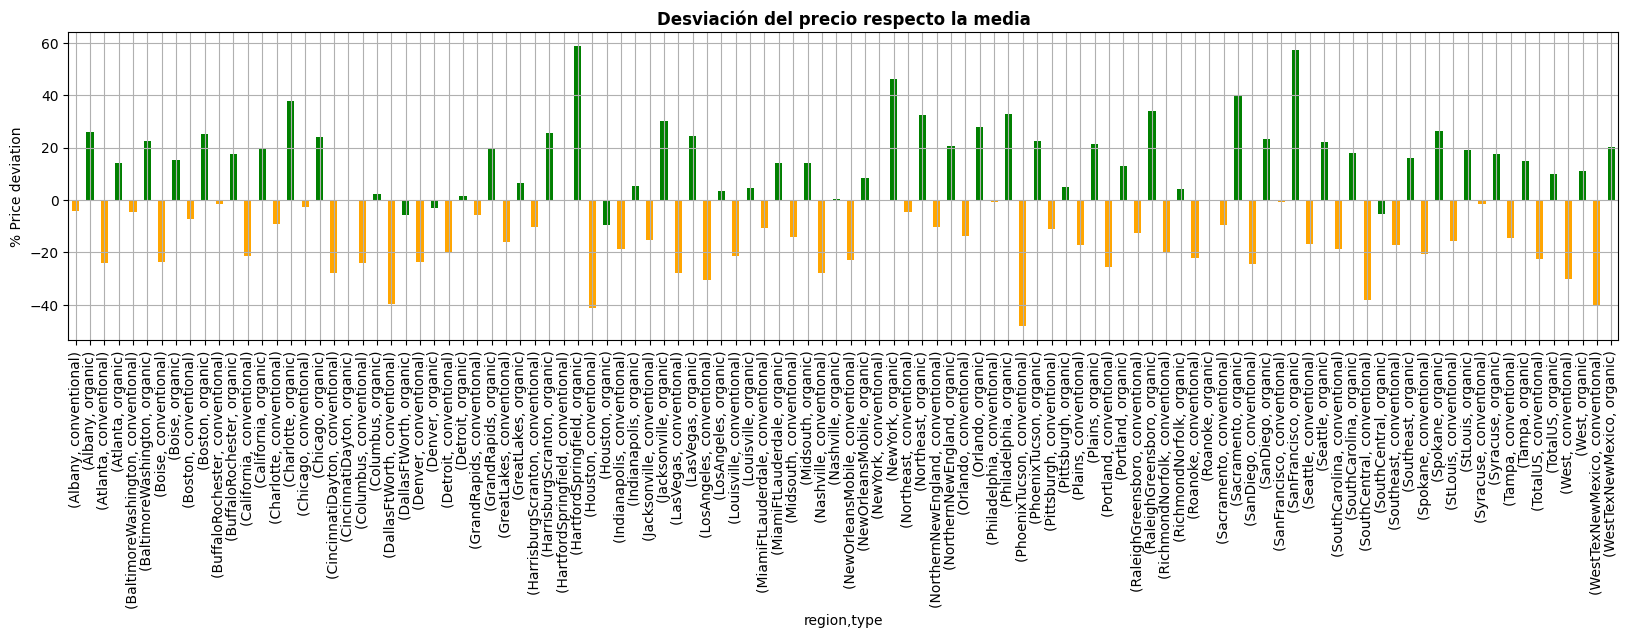

In [384]:
df_subset = df_cp
avocados_region_mean = df_subset.groupby(['region','type'])['AveragePrice'].mean()#.nlargest(6)

total_mean = df_subset['AveragePrice'].mean()
fig, ax= plt.subplots(figsize=(20,4))
avocados_relative_mean = (avocados_region_mean - total_mean)*100/total_mean
avocados_relative_mean.plot(kind = 'bar', ylabel= '% Price deviation', color = [color_conv, color_orga]) # 'slategray', 'forestgreen'])
plt.title('Desviación del precio respecto la media', fontweight = "bold")
plt.grid()
plt.show()

##### TODO: Convencional vs Organic
Observaciones:
* TODO: 
  * Si mirem la proporcio, en general es manté constant. No hi ha ningun interes per a tornar a ho natural a les gran ciutats o extensions.
  * Si acas hi ha més divergencia en extensions menors.

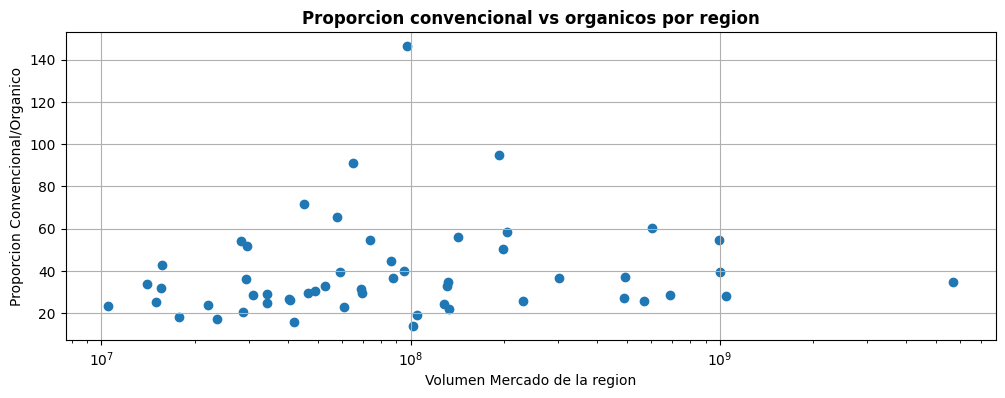

In [385]:
grouped = df_subset.groupby(['region', 'type'])['Total Volume'].sum()
unstacked_type= grouped.unstack()
unstacked_type['Proportion'] = unstacked_type['conventional']/unstacked_type['organic']

fig, ax= plt.subplots(figsize=(12,4))
x_values= unstacked_type['conventional']
y_values= unstacked_type['Proportion']
ax.scatter(x=x_values, y= y_values )
plt.title('Proporcion convencional vs organicos por region', fontweight = "bold")
plt.ylabel('Proporcion Convencional/Organico')
plt.xlabel('Volumen Mercado de la region')
plt.xscale('log')
# plt.ylim(0, 0.3*10**9)
plt.grid()
plt.show()

##### Ventas en el tiempo y separación entre convencional / orgánico

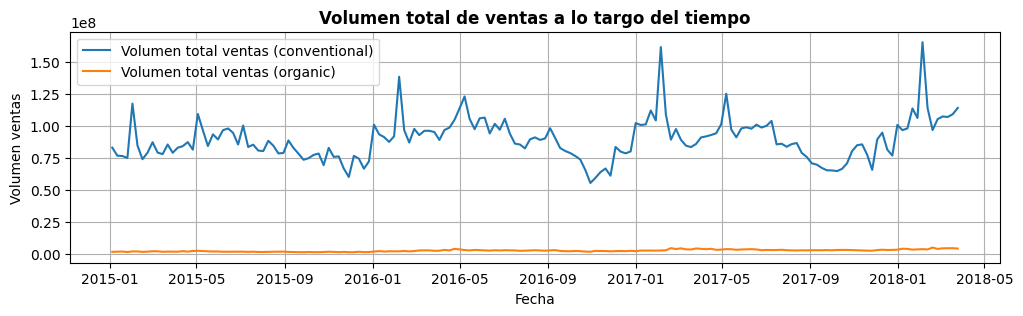

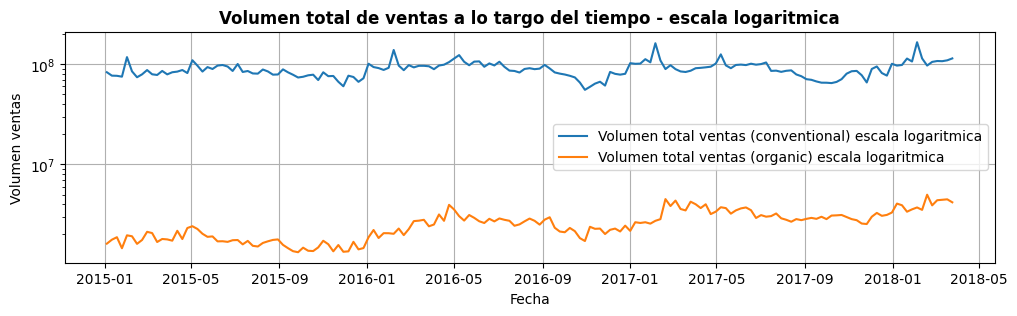

In [380]:
df_date_volume = df_cp[['Date', 'Total Volume']]
#df_cp_organic = df_cp[df_cp['type'] =='organic'] #[['Date', 'AveragePrice']]
#df_date_volume
df_grouped_conventional = df_date_volume[df_cp['type'] =='conventional'].groupby('Date').sum('Total Volume')
df_grouped_organic = df_date_volume[df_cp['type'] =='organic'].groupby('Date').sum('Total Volume')

# Graficar
plt.figure(figsize=(12,3))
plt.title('Volumen total de ventas a lo targo del tiempo', fontweight = "bold")
plt.plot(df_grouped_conventional, label='Volumen total ventas (conventional)')
plt.xlabel('Fecha')
plt.ylabel('Volumen ventas')
plt.legend(loc='best'); plt.grid(True)
plt.plot(df_grouped_organic, label='Volumen total ventas (organic)')
plt.xlabel('Fecha')
plt.ylabel('Volumen ventas')
plt.legend(loc='best'); plt.grid(True)
plt.show()

plt.figure(figsize=(12,3))
plt.title('Volumen total de ventas a lo targo del tiempo - escala logaritmica', fontweight = "bold")
plt.plot(df_grouped_conventional, label='Volumen total ventas (conventional) escala logaritmica')
plt.xlabel('Fecha')
plt.ylabel('Volumen ventas')
plt.yscale('log')
plt.legend(loc='best'); plt.grid(True)
plt.plot(df_grouped_organic, label='Volumen total ventas (organic) escala logaritmica')
plt.xlabel('Fecha')
plt.ylabel('Volumen ventas')
plt.yscale('log')
plt.legend(loc='best'); plt.grid(True)
plt.show()

##### Análisis de Cambios en Precios Anuales:

year
2015    1.375590
2016    1.338640
2017    1.515128
2018    1.347531
Name: AveragePrice, dtype: float64

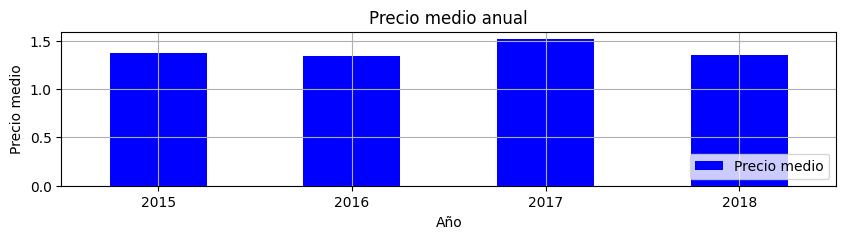

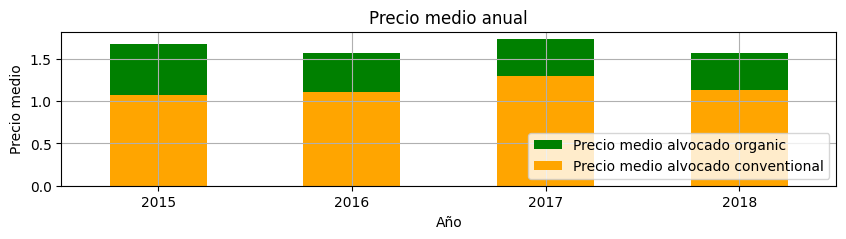

In [266]:
df_year_price = df_cp.groupby('year')['AveragePrice'].mean()
df_year_price_conventional = df_cp[df_cp['type'] =='conventional'].groupby('year')['AveragePrice'].mean()
df_year_price_organic = df_cp[df_cp['type'] =='organic'].groupby('year')['AveragePrice'].mean()
display(df_year_price)

# Graficar
plt.figure(figsize=(10, 2)) 
df_year_price.plot.bar(label ='Precio medio', color = color_total, alpha=1) # x='aaa??',y='bbb??',
plt.xlabel('Año')
plt.ylabel('Precio medio')
plt.title('Precio medio anual', fontweight = "bold")
plt.legend(loc='lower right'); plt.grid(True)
plt.xticks(rotation=0)
plt.show()


plt.figure(figsize=(10, 2)) 
df_year_price_organic.plot.bar(label ='Precio medio alvocado organic', color = color_orga) # x='aaa??',y='bbb??',
df_year_price_conventional.plot.bar(label ='Precio medio alvocado conventional', color = color_conv) # x='aaa??',y='bbb??',
#df_year_price.plot.bar(label ='Precio medio', color ='blue', alpha=0.2) # x='aaa??',y='bbb??',
plt.xlabel('Año')
plt.ylabel('Precio medio')
plt.title('Precio medio anual', fontweight = "bold")
plt.legend(loc='lower right'); plt.grid(True)
plt.xticks(rotation=0)
plt.show()

##### Analisis de Series Temporales y Ruido asociado

Observaciones:
    * Perido de 52 semanas para ver la evolucion a la lo largo de los 3 años.

Ragos de fechas: mínima: 2015-01-04 00:00:00 máxima: 2018-03-25 00:00:00


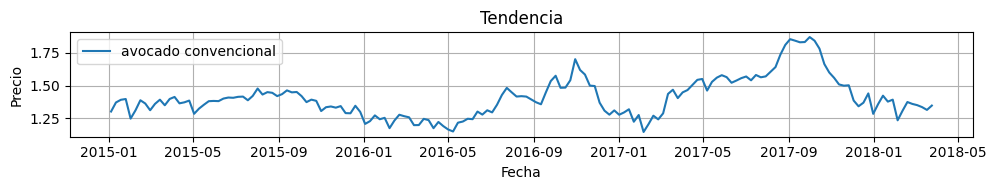

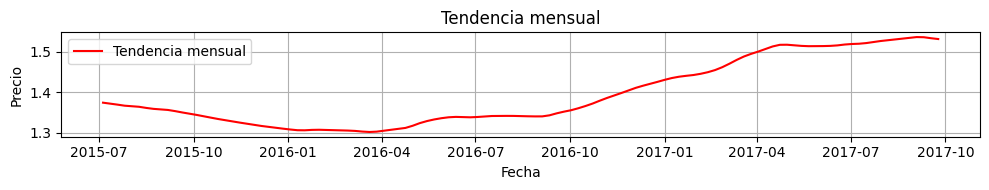

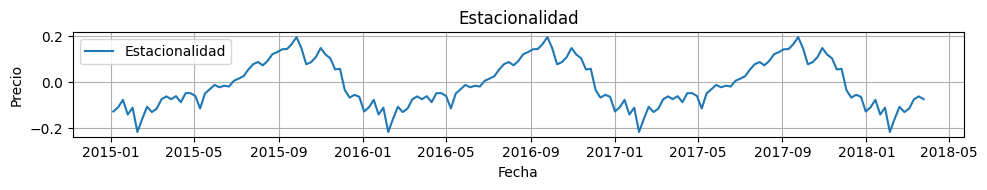

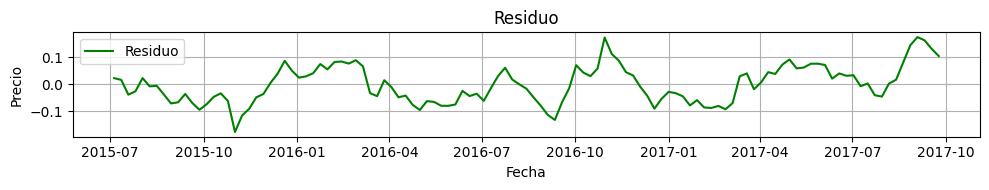

In [368]:
print(f"Ragos de fechas: mínima: {df_cp.Date.min()} máxima: {df_cp.Date.max()}")

df_grouped = df_cp.groupby('Date')['AveragePrice'].mean()
#df_cp_grouped = df_cp.copy() #[df_cp['type'] =='conventional']#[['Date', 'AveragePrice']]
df_grouped = df_cp.groupby('Date')['AveragePrice'].mean()

# Descomposicio de la serie de tiemps: 39 mesos si considerem que tenim del 1-1-2015 fins al 25-3-2018
df_decomp = seasonal_decompose(df_grouped, model='additive', period=(int)(52*1)) #maxim: 84

plt.figure(figsize=(10, 2))
plt.plot(df_decomp.observed, label='avocado convencional')
plt.legend(loc='best');plt.grid(True)
plt.title('Tendencia', fontweight = "bold")
plt.ylabel('Precio')
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(df_decomp.trend, color='red', label='Tendencia mensual')
plt.title('Tendencia mensual', fontweight = "bold")
plt.legend(loc='best');plt.grid(True)
plt.xlabel('Fecha')
plt.ylabel('Precio')
#plt.title('Tendencia')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(df_decomp.seasonal, label='Estacionalidad')
plt.title('Estacionalidad', fontweight = "bold")
plt.ylabel('Precio')
plt.legend(loc='best');plt.grid(True)
plt.xlabel('Fecha')
#plt.title('Estacionalidad')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(df_decomp.resid, color='green', label='Residuo')
plt.legend(loc='best');plt.grid(True)
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Residuo', fontweight = "bold")
#plt.title('Residuo')
plt.tight_layout()
plt.show()

In [268]:
df_subset = df_cp[df_cp['region']!= 'TotalUS']
df_organic = df_subset[df_subset['type']=='organic']
df_convencionals = df_subset[df_subset['type']=='conventional']

# df_convencionals
index_df = df_cp_cleaned.copy()
#['West', 'California', 'SouthCentral', 'Northeast', 'Southeast']
great_reg_col = {'California' : 'red', 'West':'Orange', 'SouthCentral':'green', 'Northeast':'SkyBlue', 'Southeast':'DarkBlue'}

region_largest= list(index_df.groupby('region')['Total Volume'].sum().nlargest(5).index)
df_regions = df_convencionals[df_convencionals['region'].isin(region_largest)]

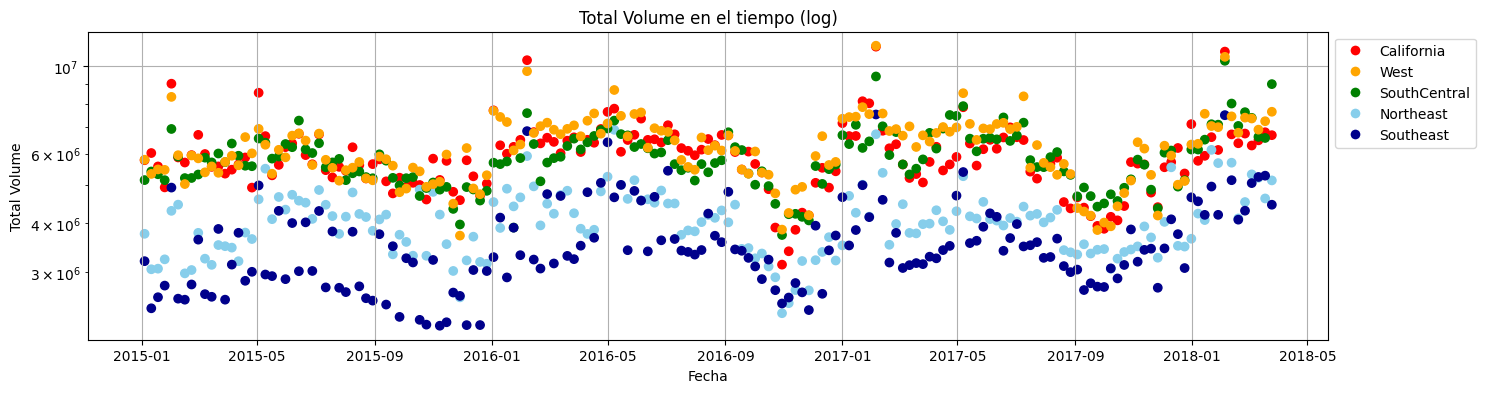

In [369]:
fig, ax= plt.subplots(figsize=(16,4))
y_values = df_regions['Total Volume']
x_values = df_regions['Date']
c_values= list(df_regions['region'].map(great_reg_col))

plt.scatter(x= x_values, y= y_values, c=c_values, alpha = 1)
plt.yscale('log')
plt.title('Total Volume en el tiempo (log)', fontweight = "bold")
plt.ylabel('Total Volume')
plt.xlabel('Fecha')
#plt.legend() #loc='lower right')
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=region, markerfacecolor=color, markersize=8) for region, color in great_reg_col.items() if region in df_regions['region'].unique()]
plt.legend(handles=legend_handles, loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.grid()
plt.show()

* Nota: Aquí los outlayers también parecen corresponden con las fechas de la Super Bowl.

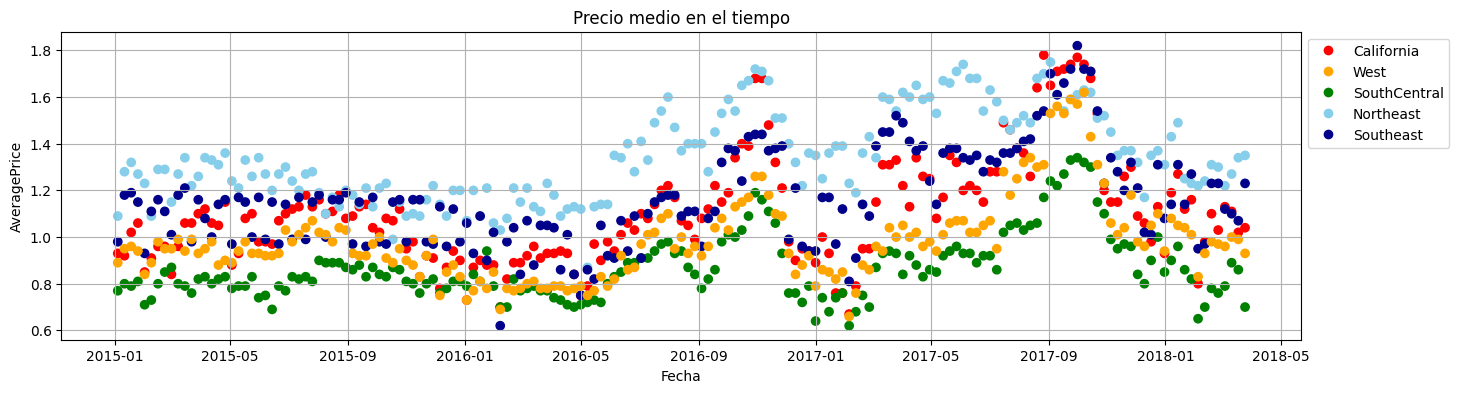

In [370]:
fig, ax= plt.subplots(figsize=(16,4))
y_values = df_regions['AveragePrice']
x_values = df_regions['Date']
c_values= list(df_regions['region'].map(great_reg_col))

plt.scatter(x= x_values, y= y_values, c=c_values, alpha = 1)
#plt.yscale('log')
plt.title('Precio medio en el tiempo', fontweight = "bold")
plt.ylabel('AveragePrice')
plt.xlabel('Fecha')
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=region, markerfacecolor=color, markersize=8) for region, color in great_reg_col.items() if region in df_regions['region'].unique()]
plt.legend(handles=legend_handles, loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.grid()
plt.show()

#### Subset alvocados convencionals
* Aqui tendriamos que incluir una idea de si todas las regiones hacen un número similar total de pedidos
* Claramente hay sitios donde los aguacates son más baratos, miremos si tiene que ver con otras características

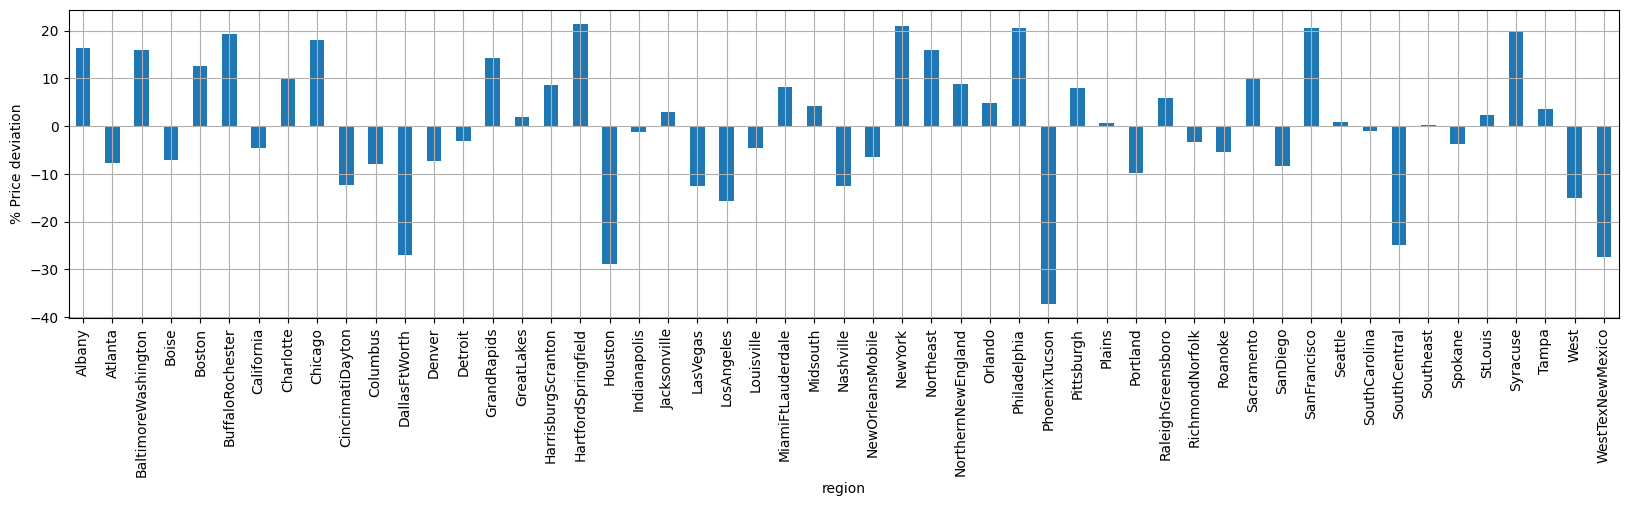

In [271]:
df_subset = df_cp[df_cp['region']!= 'TotalUS']
df_convencionals = df_subset[df_subset['type']=='conventional']
convencional_region_mean = df_convencionals.groupby('region')['AveragePrice'].mean()#.nlargest(6)
coloring=convencional_region_mean.index.map(av.region_classification).map(av.classification_colors)
total_mean = df_convencionals['AveragePrice'].mean()
fig, ax= plt.subplots(figsize=(20,4))
plt.title('Desviación del precio respecto la media', fontweight = "bold")
avocados_relative_mean = ((convencional_region_mean - total_mean)*100/total_mean)
avocados_relative_mean.plot(kind = 'bar', ylabel= '% Price deviation')#, color= coloring)#, color= convencional_region_mean.index.map(classification_colors))
plt.grid()
plt.show()

#### Majors mercats el preu mig tendeix a abaratirse
* Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
* Aqui estem prenent cada regio com equivalentment valida
* cambiar el 2018 no parece afectar los resultados

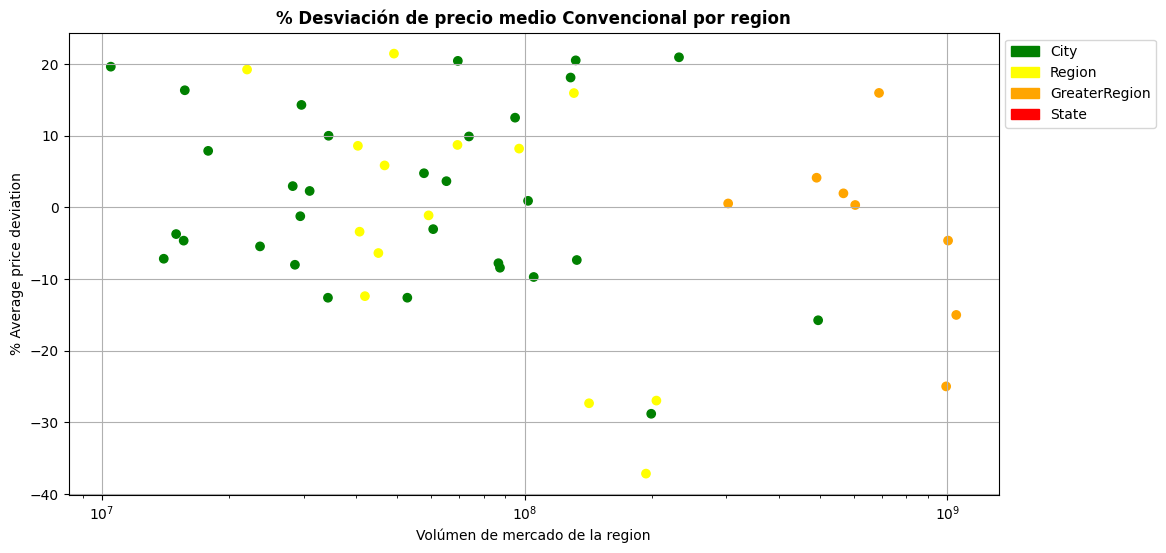

In [379]:
convencional_region_mean_total = df_convencionals.groupby('region').agg({'Total Volume':'sum', 'AveragePrice':'mean'})#.nlargest(6)
convencional_region_mean_total['region_class'] = convencional_region_mean_total.index.map(av.region_classification)

x_values = convencional_region_mean_total['Total Volume']
total_mean = convencional_region_mean_total['AveragePrice'].mean()
y_values = (convencional_region_mean_total['AveragePrice'] - total_mean)*100/total_mean
c_values= list(convencional_region_mean_total['region_class'].map(av.classification_colors))

fig, ax= plt.subplots(figsize=(12,6))
plt.scatter(x= x_values, y= y_values, c=c_values)
plt.xscale('log')
plt.title('% Desviación de precio medio Convencional por region', fontweight = "bold")
plt.ylabel('% Average price deviation')
plt.xlabel('Volúmen de mercado de la region')
legend_patches = [mpatches.Patch(color=color, label=region) for region, color in av.classification_colors.items()]
plt.legend(handles=legend_patches, loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.grid()
plt.show()

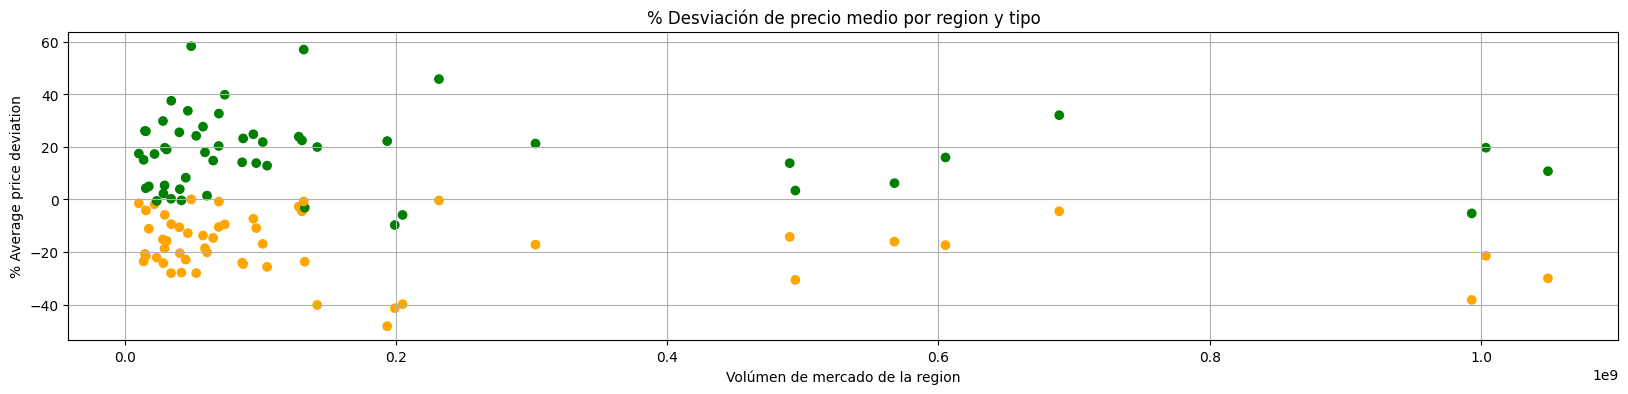

In [377]:
df_cp_cleaned = df_cp[df_cp['region_class'] !='TotalUS'].copy()
convencional_region_mean_total = df_cp_cleaned.groupby(['region','type']).agg({'Total Volume':'sum', 'AveragePrice':'mean'})#.nlargest(6)

for region in pd.unique(df_cp_cleaned['region']):
    convencional_region_mean_total.loc[(region, 'organic'),'Total Volume'] = convencional_region_mean_total.loc[(region, 'conventional'),'Total Volume']

new_convencional_region_mean_total= convencional_region_mean_total.reset_index(level='type') 
type_coloring= {'organic':color_orga, 'conventional':color_conv}

fig, ax= plt.subplots(figsize=(20,4))
x_values = new_convencional_region_mean_total['Total Volume']
total_mean = new_convencional_region_mean_total['AveragePrice'].mean()
y_values = (new_convencional_region_mean_total['AveragePrice'] - total_mean)*100/total_mean
c_values= new_convencional_region_mean_total['type'].map(type_coloring)

plt.scatter(x= x_values, y= y_values, c=c_values)
plt.title('% Desviación de precio medio por region y tipo', fontweight = "bold")
plt.ylabel('% Average price deviation')
plt.xlabel('Volúmen de mercado de la region')
plt.grid()
plt.show()

### Gráficos para Visualización de Datos

#### Volumen Total de Ventas

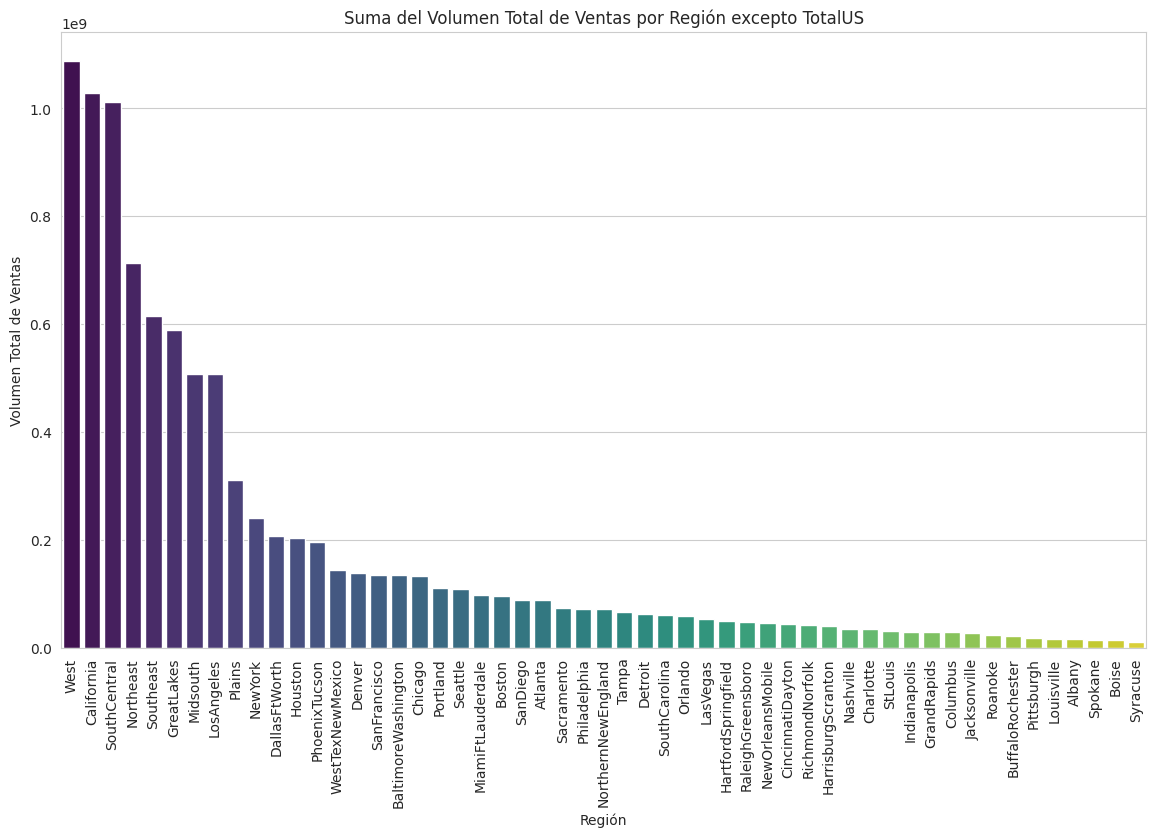

In [275]:
df_cp_cleaned = df_cp.copy()
df_cp_cleaned=df_cp[df_cp.region != 'TotalUS']
volume_by_region = df_cp_cleaned.groupby('region')['Total Volume'].sum().sort_values(ascending=False).to_frame()

sns.set_style('whitegrid')
plt.figure(figsize=(14, 8))
sns.barplot(data=volume_by_region, x='region', y='Total Volume', hue='region', palette='viridis')
plt.xticks(rotation=90)
# Añadir título y etiquetas a los ejes
plt.title('Suma del Volumen Total de Ventas por Región excepto TotalUS', fontweight = "bold")
plt.xlabel('Región')
plt.ylabel('Volumen Total de Ventas')
#plt.yscale('log')

# Mostrar el gráfico
plt.show()
sns.reset_defaults()

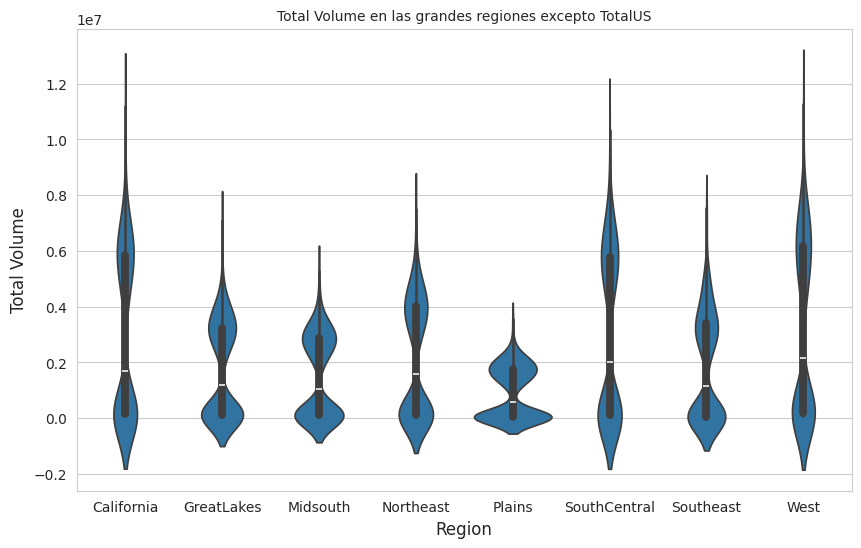

In [276]:
df_cp['RegionClass'] = df_cp['region'].map(av.region_classification)
df_cp_cleaned=df_cp[df_cp.region != 'TotalUS']
df_cp_GreaterRegion=df_cp_cleaned[df_cp_cleaned['RegionClass']=='GreaterRegion']
df_cp_GreaterRegion_conv=df_cp_GreaterRegion[df_cp_GreaterRegion['type']=='conventional']
df_cp_GreaterRegion_org=df_cp_GreaterRegion[df_cp_GreaterRegion['type']=='organic']

plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.violinplot(x='region',y='Total Volume', data=df_cp_GreaterRegion)
plt.xlabel('Region',{'fontsize' : 'large'})
plt.ylabel('Total Volume',{'fontsize':'large'})
plt.title("Total Volume en las grandes regiones excepto TotalUS",{'fontsize':10}, fontweight = "bold")
plt.show()

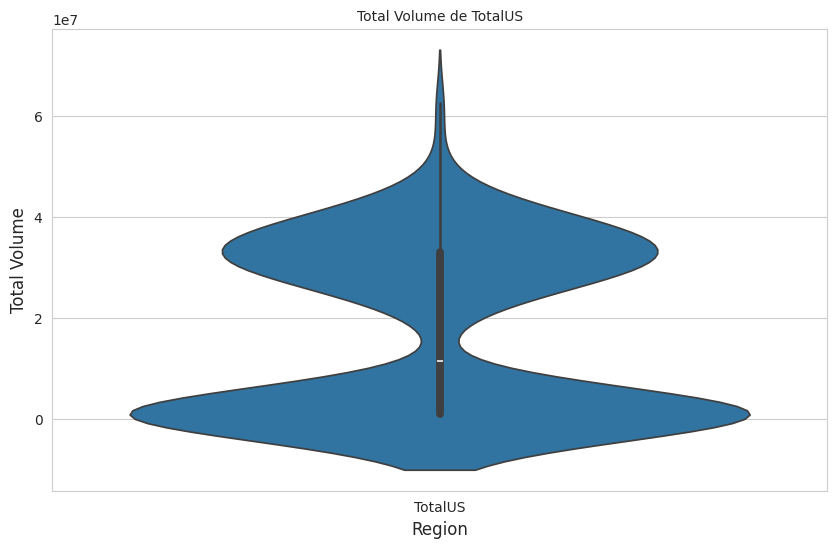

In [277]:
df_cp_TotalUS=df_cp[df_cp['region']=='TotalUS']
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.violinplot(x='region',y='Total Volume', data=df_cp_TotalUS)
plt.xlabel('Region',{'fontsize' : 'large'})
plt.ylabel('Total Volume',{'fontsize':'large'})
plt.title("Total Volume de TotalUS",{'fontsize':10}, fontweight = "bold")
plt.show()

##### Conclusiones: En el gráfico de violín se observan la presencia de dos valores de concentración de datos , estas dos zonas aparecen en todas las regiones.
##### Ello induce a pensar que hay dos categorias de datos en cada región.

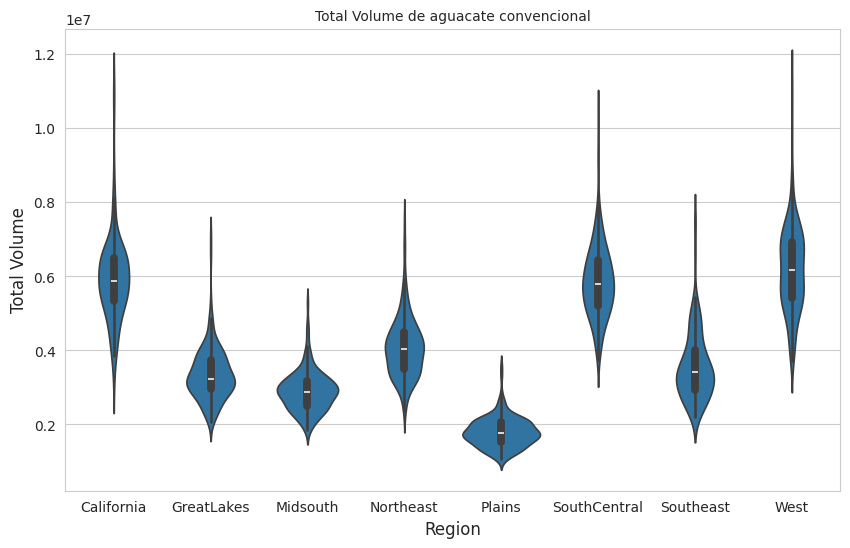

In [278]:
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.violinplot(x='region',y='Total Volume', data=df_cp_GreaterRegion_conv)
plt.xlabel('Region',{'fontsize' : 'large'})
plt.ylabel('Total Volume',{'fontsize':'large'})
plt.title("Total Volume de aguacate convencional",{'fontsize':10}, fontweight = "bold")
plt.show()

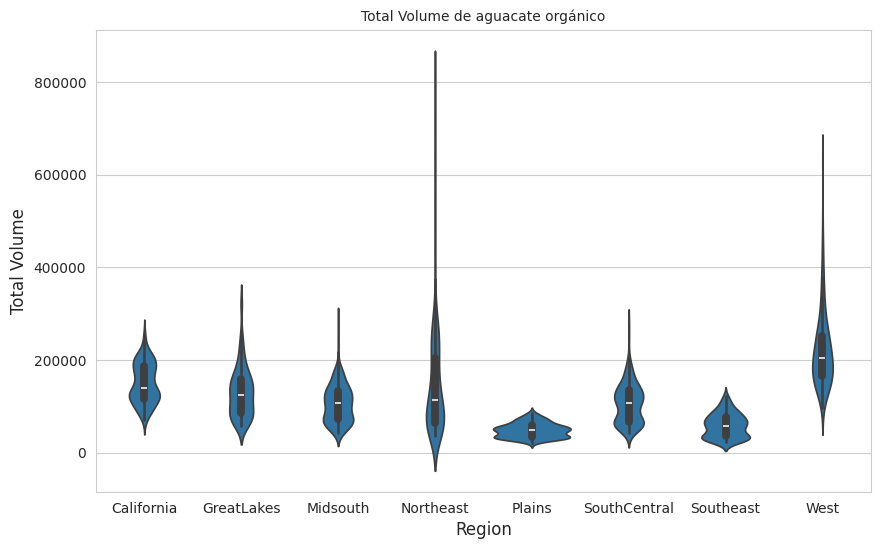

In [279]:
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.violinplot(x='region',y='Total Volume', data=df_cp_GreaterRegion_org)
plt.xlabel('Region',{'fontsize' : 'large'})
plt.ylabel('Total Volume',{'fontsize':'large'})
plt.title("Total Volume de aguacate orgánico",{'fontsize':10}, fontweight = "bold")
plt.show()

#### Boxplot Comparativo de Precios entre Años

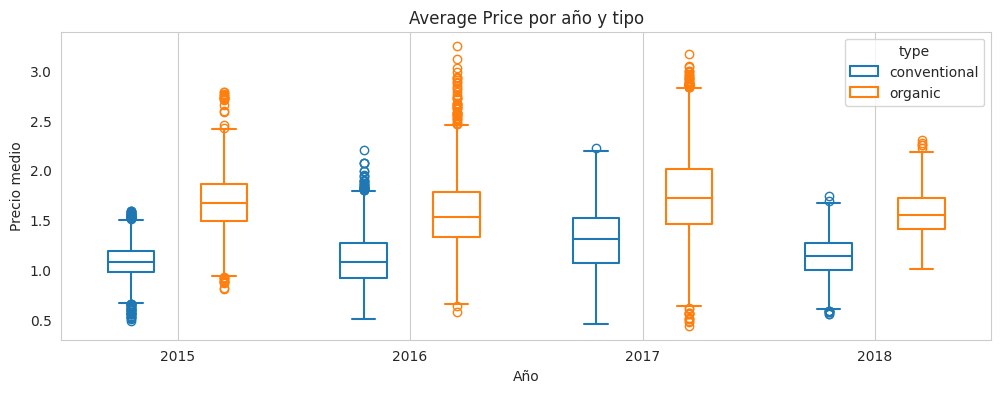

In [280]:
df_cp_cleaned = df_cp[df_cp['region_class'] !='TotalUS'].copy()
plt.figure(figsize=(12,4))
sns.boxplot(df_cp_cleaned, x="year", y="AveragePrice", hue='type', fill=False, gap=0.5)
plt.title("Average Price por año y tipo", fontweight = "bold") #,{'fontsize':40})
plt.xlabel('Año') #,{'fontsize' : 30})
plt.ylabel('Precio medio') #,{'fontsize':'large'})
plt.grid()
plt.show()
sns.reset_defaults()

##### En el boxplot incluyendo todos las regiones se observan numerosos outliers.
##### En el año 2016 hay mayor dispersión aunque la mediana es practicamente la misma.


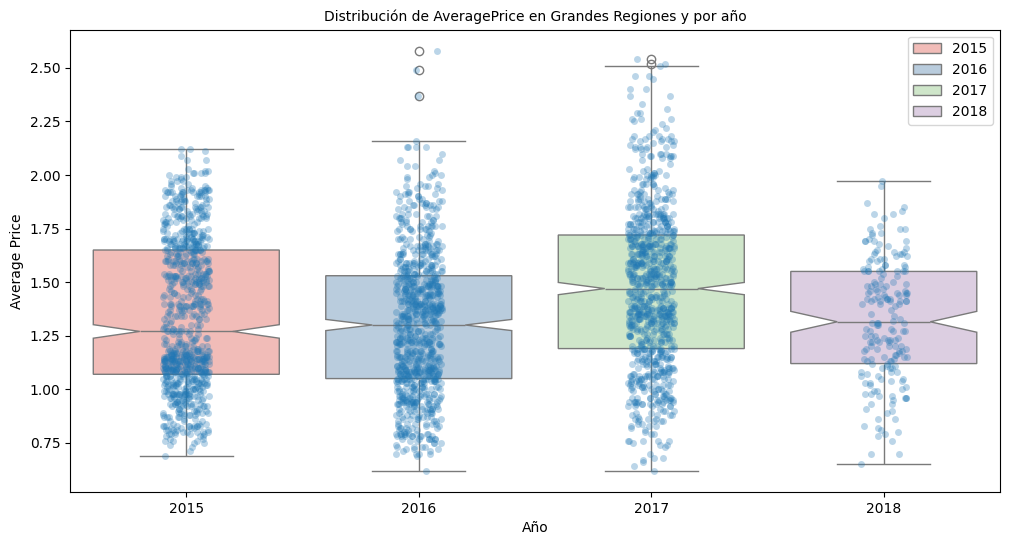

In [281]:
plt.figure(figsize=(12, 6))
plt.title('Distribución de AveragePrice en Grandes Regiones y por año',{'fontsize':10}, fontweight = "bold")
plt.xlabel('Año')
plt.ylabel('Average Price')
sns.boxplot(data=df_cp_GreaterRegion, x='year', y='AveragePrice', hue='year', palette='Pastel1', notch=True)
sns.stripplot(data=df_cp_GreaterRegion, x='year', y='AveragePrice',alpha=0.3)
plt.show()


##### Conclusiones: las ciudades y regiones al ser más pequeñas introducen más variabilidad en el precio


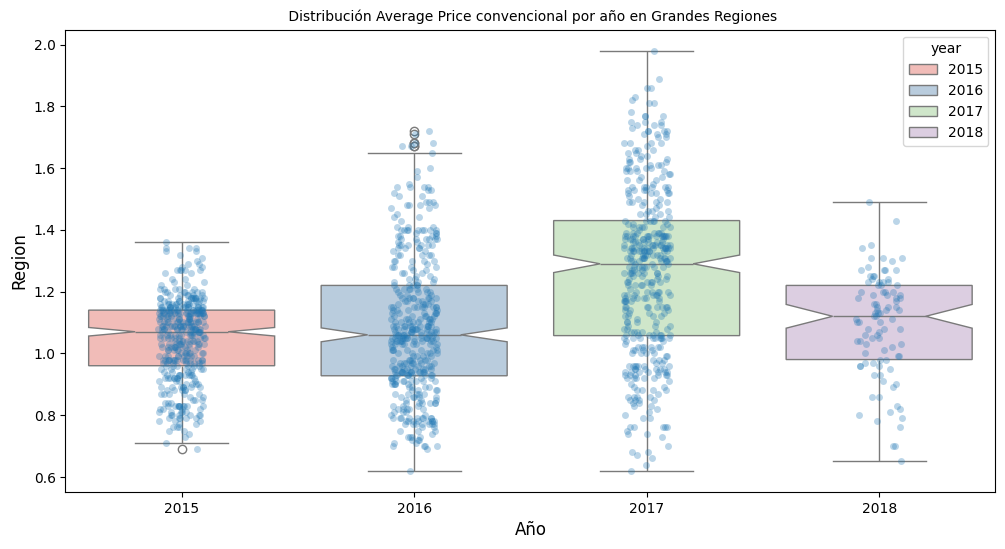

In [282]:
plt.figure(figsize=(12,6))

plt.xlabel('Año',{'fontsize' : 'large'})
plt.ylabel('Region',{'fontsize':'large'})
plt.title(" Distribución Average Price convencional por año en Grandes Regiones",{'fontsize':10}, fontweight = "bold")
sns.stripplot(data=df_cp_GreaterRegion_conv, x='year', y='AveragePrice',alpha=0.3)
sns.boxplot(data=df_cp_GreaterRegion_conv, x='year', y='AveragePrice', hue='year', palette='Pastel1', notch=True)
plt.show()


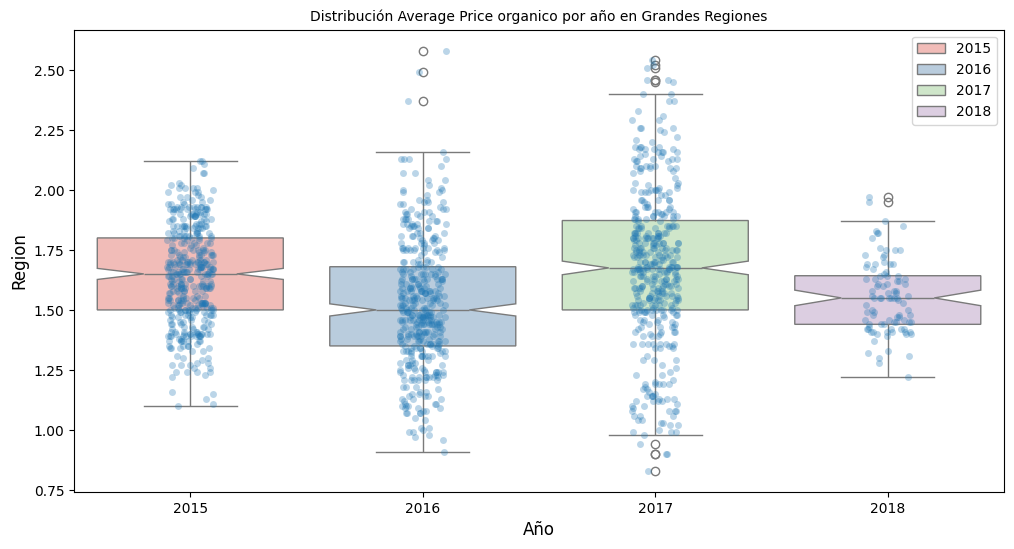

In [283]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_cp_GreaterRegion_org, x='year', y='AveragePrice', hue='year', palette='Pastel1', notch=True)
plt.xlabel('Año',{'fontsize' : 'large'})
plt.ylabel('Region',{'fontsize':'large'})
plt.title("Distribución Average Price organico por año en Grandes Regiones",{'fontsize':10}, fontweight = "bold")
sns.stripplot(data=df_cp_GreaterRegion_org, x='year', y='AveragePrice',alpha=0.3)
plt.show()

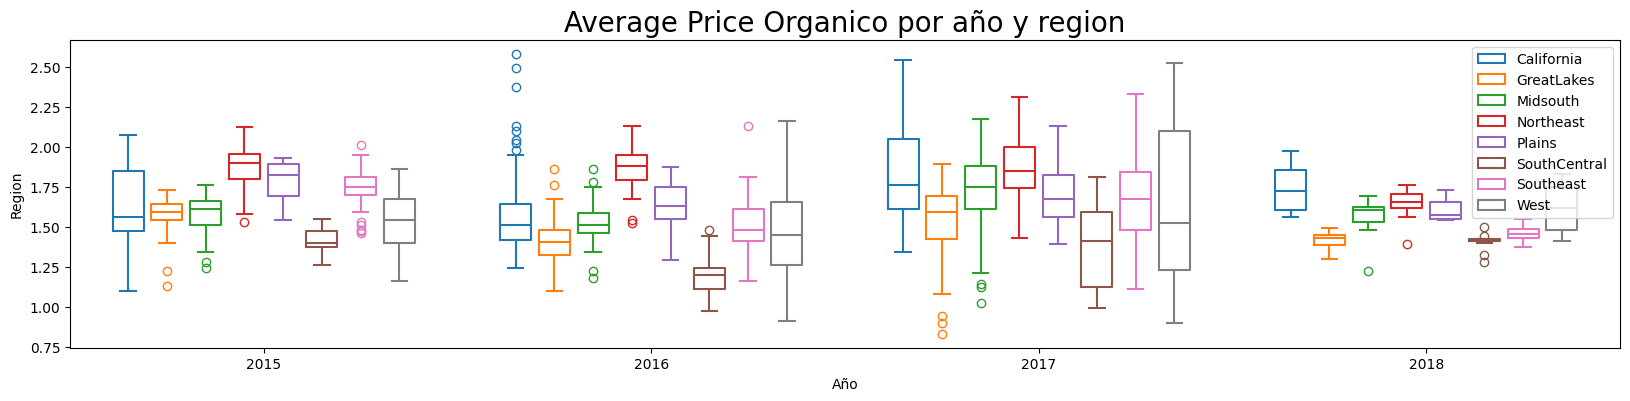

In [284]:
df_cp = av.df("df_cp")
df_cp_organic = df_cp[df_cp['type'] =='organic']
#regiones = ['West', 'California']
regiones = av.Manager.obtener_regions('GreaterRegion')
df_filtrado = df_cp_organic[df_cp_organic['region'].isin(regiones)]

plt.figure(figsize=(20,4))
sns.boxplot(df_filtrado, x="year", y="AveragePrice", hue="region", dodge=True, fill=False, gap=.2)
plt.title("Average Price Organico por año y region",{'fontsize':20}, fontweight = "bold")
plt.xlabel('Año')#,{'fontsize' : 'large'})
plt.ylabel('Region')#,{'fontsize':'large'})
plt.legend(loc='best') #, bbox_to_anchor=(1, 1), ncol=1)
plt.show()


#### Precios Promedios por Año

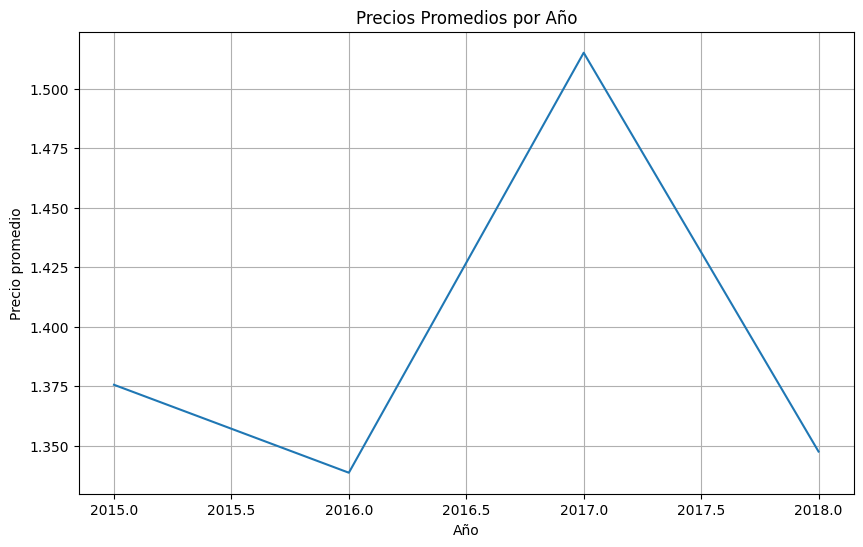

In [378]:
y=df_cp.groupby(['year'])['AveragePrice'].mean()
x=(df_cp['year'].unique())
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title('Precios Promedios por Año', fontweight = "bold")
plt.ylabel('Precio promedio')
plt.xlabel('Año')
plt.grid()
plt.show()

#### Separar alvocados convencionales y organicos

AveragePrice: min: 0.44 max: 3.25


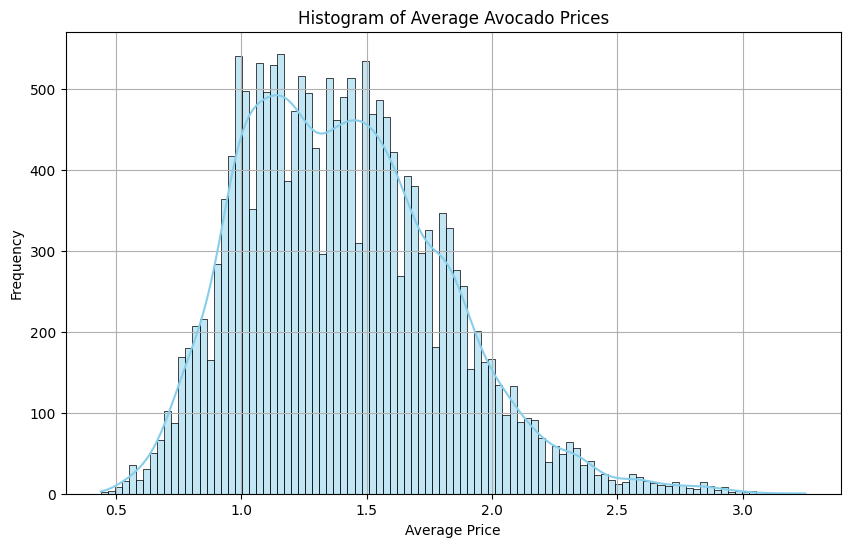

In [286]:
df_cp = av.df("df_cp")
average_prices = df_cp['AveragePrice']
print(f"AveragePrice: min: {df_cp['AveragePrice'].min()} max: {df_cp['AveragePrice'].max()}")

plt.figure(figsize=(10, 6))
sns.histplot(average_prices, bins=100, kde=True, color='skyblue')
plt.title('Histogram of Average Avocado Prices', fontweight = "bold")
plt.xlabel('Average Price')
plt.ylabel('Frequency')
plt.grid()
plt.show()

type
conventional    1.158040
organic         1.653999
Name: AveragePrice, dtype: float64


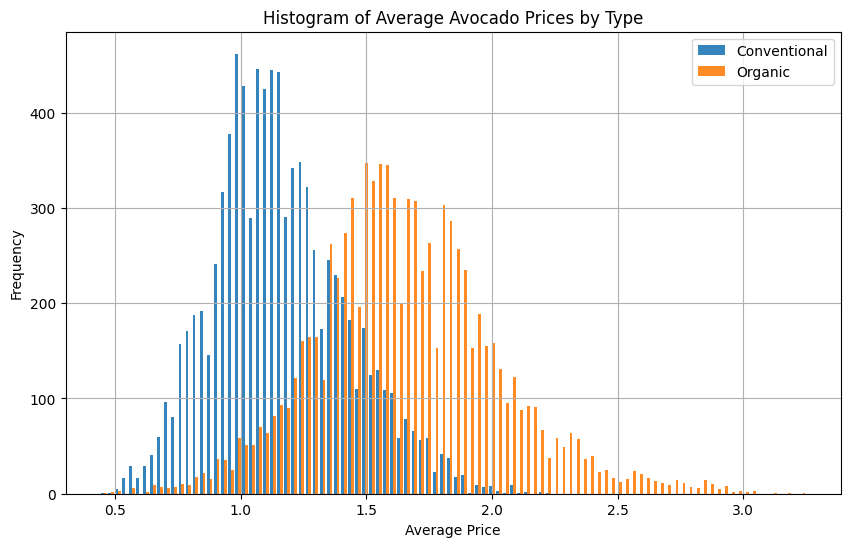

In [287]:
df_cp = av.df("df_cp")
average_price_by_type = df_cp.groupby('type')['AveragePrice'].mean()
print(average_price_by_type)

plt.figure(figsize=(10, 6))
plt.hist(
    [df_cp_cleaned[df_cp_cleaned['type'] == 'conventional']['AveragePrice'], 
     df_cp_cleaned[df_cp_cleaned['type'] == 'organic']['AveragePrice']],
    bins=100, label=['Conventional', 'Organic'], alpha=0.9
)

# Add titles and labels
plt.title("Histogram of Average Avocado Prices by Type", fontweight = "bold")
plt.xlabel("Average Price")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.grid()
plt.show()

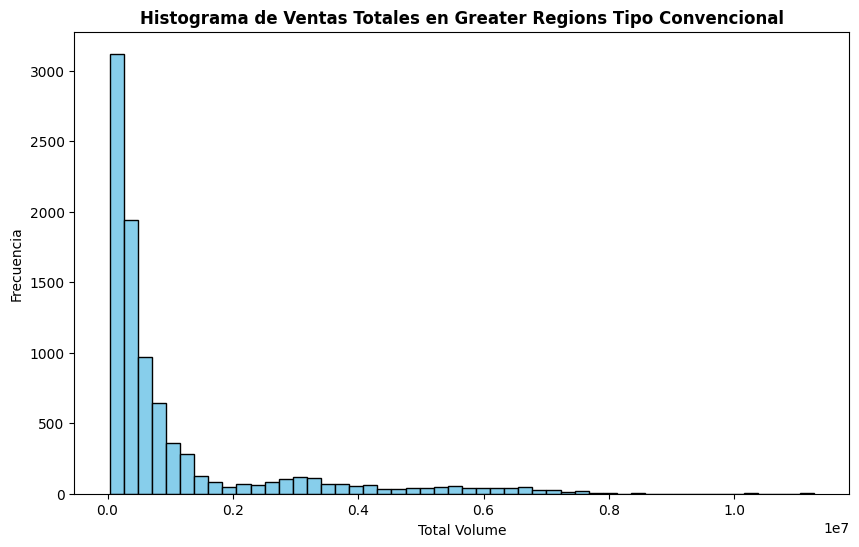

In [288]:
df_cp_conventional = av.df("df_cp_conventional")

plt.figure(figsize=(10, 6))
plt.title('Histograma de Ventas Totales en Greater Regions Tipo Convencional', fontweight = "bold")
plt.hist(df_cp_conventional['Total Volume'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Total Volume')
plt.ylabel('Frecuencia')
plt.show()

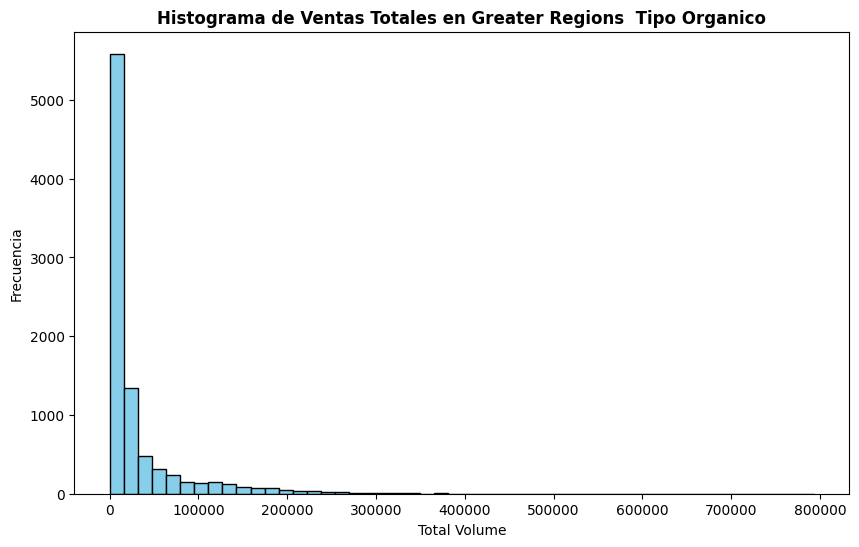

In [289]:
df_cp_organic = av.df("df_cp_organic")

plt.figure(figsize=(10, 6))
plt.title('Histograma de Ventas Totales en Greater Regions  Tipo Organico', fontweight = "bold")
plt.hist(df_cp_organic['Total Volume'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Total Volume')
plt.ylabel('Frecuencia')
plt.show()

#### Ventas por Tipo de Bolsa

In [290]:
tipos_bolsas=['Total Bags','Small Bags','Large Bags','XLarge Bags']
ventas=[df_cp['Total Bags'].sum(),df_cp['Small Bags'].sum(),df_cp['Large Bags'].sum(),df_cp['XLarge Bags'].sum()]

plt.figure(figsize=(10, 6))
plt.title('Grafico de Barras por Tipo de Bolsa', fontweight = "bold")
plt.xlabel("Tipo de Bolsa")
plt.ylabel("Ventas")
plt.grid()
plt.bar(tipos_bolsas,ventas, color = color_total, width=0.4)

<BarContainer object of 4 artists>

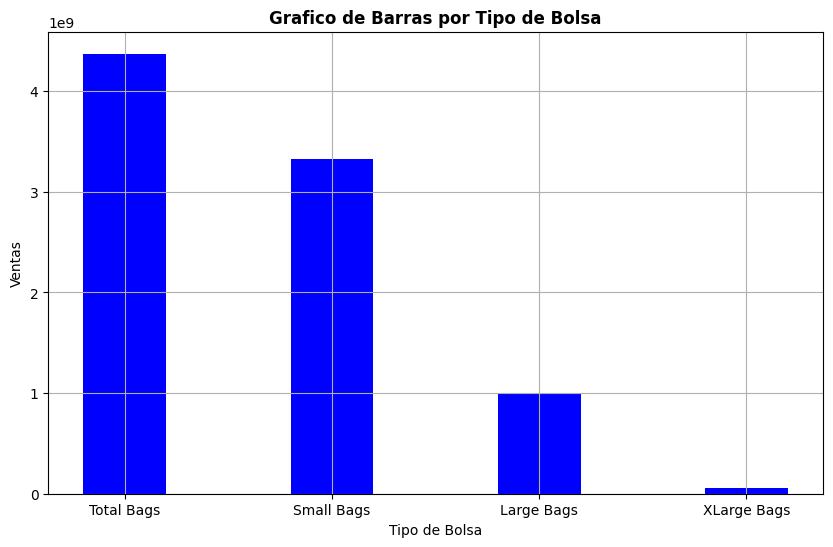

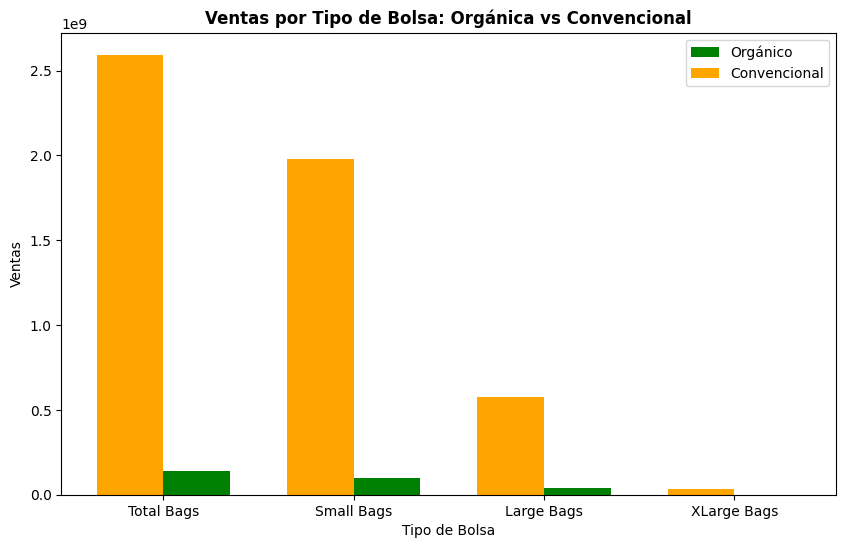

In [291]:
df_cp_organic = av.df("df_cp_organic")
df_cp_conventional = av.df("df_cp_conventional")

ventas_org=[df_cp_organic['Total Bags'].sum(),df_cp_organic['Small Bags'].sum(),df_cp_organic['Large Bags'].sum(),df_cp_organic['XLarge Bags'].sum()]
ventas_conv=[df_cp_conventional['Total Bags'].sum(),df_cp_conventional['Small Bags'].sum(),df_cp_conventional['Large Bags'].sum(),df_cp_conventional['XLarge Bags'].sum()]

x = np.arange(len(tipos_bolsas))  # Posición de cada tipo de bolsa
width = 0.35
plt.figure(figsize=(10, 6))
plt.bar(x + width/2, ventas_org, width, label='Orgánico', color= color_orga)
plt.bar(x - width/2, ventas_conv, width, label='Convencional', color= color_conv)
plt.title('Ventas por Tipo de Bolsa: Orgánica vs Convencional', fontweight="bold")
plt.xlabel("Tipo de Bolsa")
plt.ylabel("Ventas")
plt.xticks(x, tipos_bolsas)  # Posicionar etiquetas en el centro de los grupos de barras
plt.legend()
plt.show()

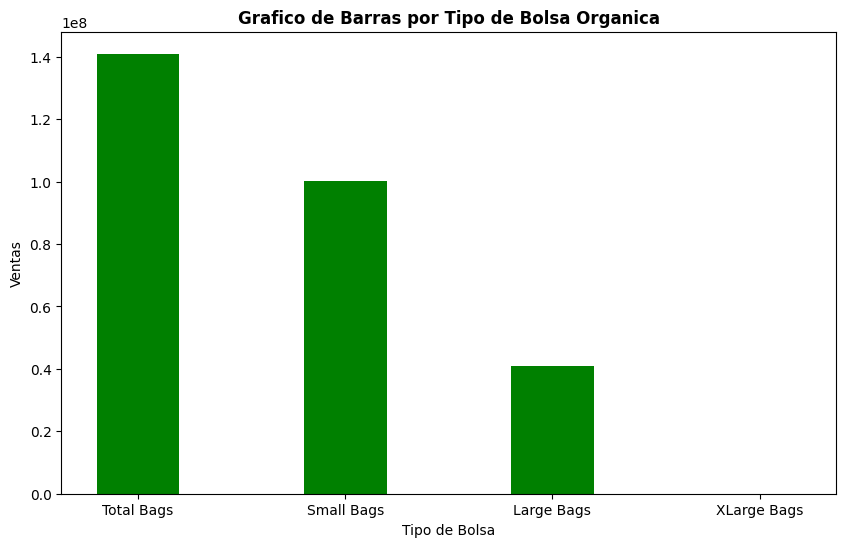

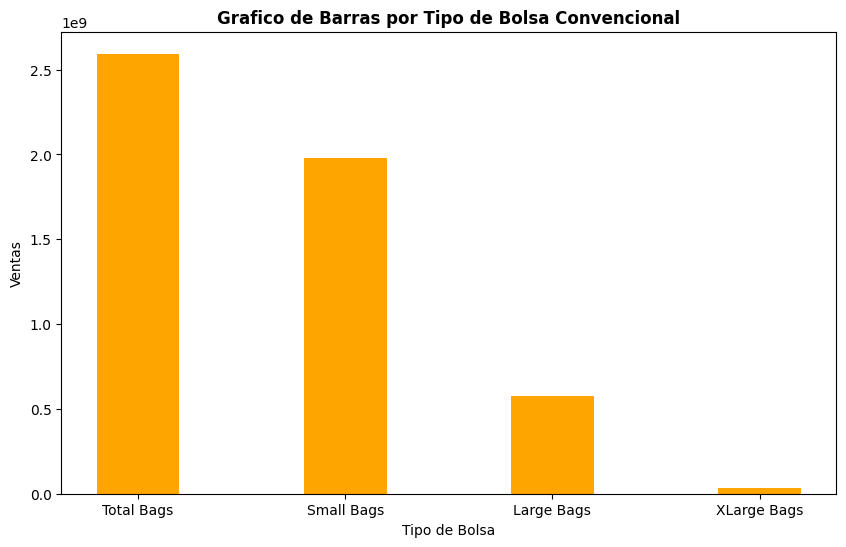

In [292]:
df_cp_organic = av.df("df_cp_organic")
ventas_org=[df_cp_organic['Total Bags'].sum(),df_cp_organic['Small Bags'].sum(),df_cp_organic['Large Bags'].sum(),df_cp_organic['XLarge Bags'].sum()]
plt.figure(figsize=(10, 6))
plt.title('Grafico de Barras por Tipo de Bolsa Organica', fontweight = "bold")
plt.xlabel("Tipo de Bolsa")
plt.ylabel("Ventas")
plt.bar(tipos_bolsas,ventas_org, color = color_orga, width=0.4)
plt.show()

df_cp_conventional = av.df("df_cp_conventional")
ventas_conv=[df_cp_conventional['Total Bags'].sum(),df_cp_conventional['Small Bags'].sum(),df_cp_conventional['Large Bags'].sum(),df_cp_conventional['XLarge Bags'].sum()]
plt.figure(figsize=(10, 6))
plt.title('Grafico de Barras por Tipo de Bolsa Convencional', fontweight = "bold")
plt.xlabel("Tipo de Bolsa")
plt.ylabel("Ventas")
plt.bar(tipos_bolsas,ventas_conv, color = color_conv, width=0.4)
plt.show()

#### Total Volume respecto al conjunto de volumenes por calibres de HASS S, L y XL

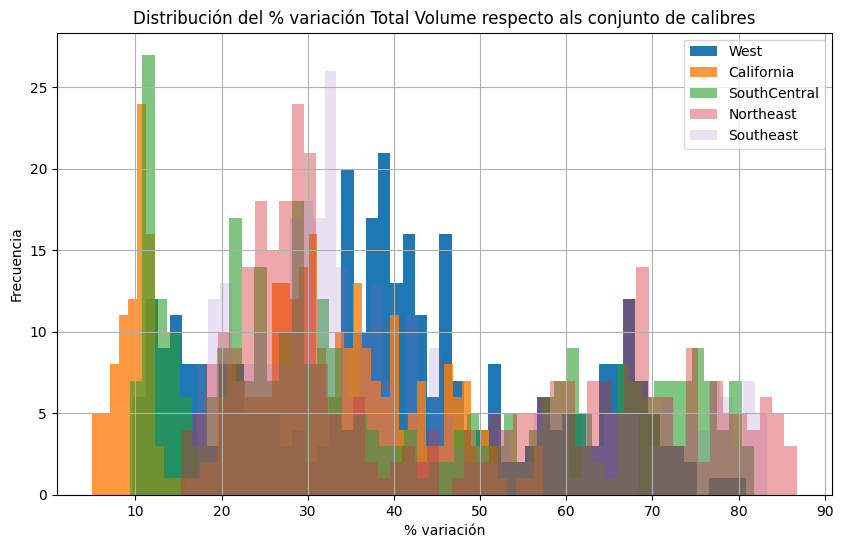

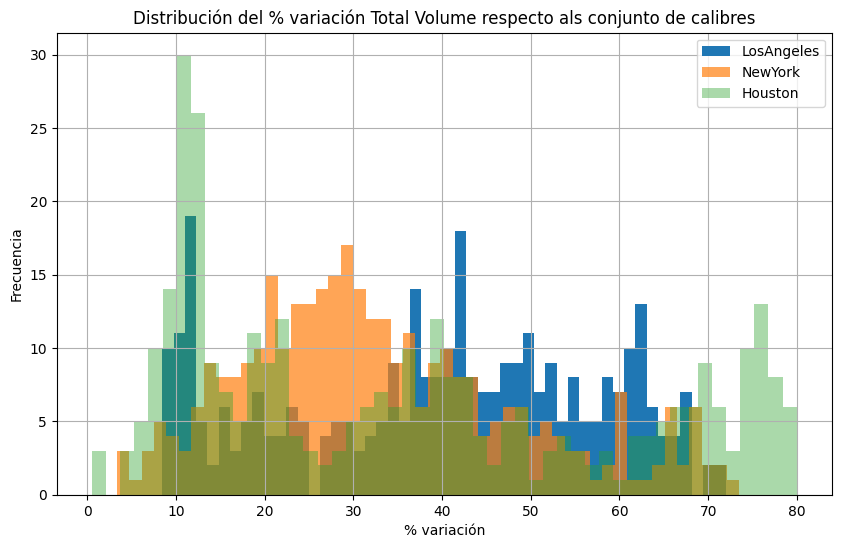

In [293]:
# Para seleccionar unicamente las regiones propias , descartamos Total US para la vista gráfica
df_cp_cleaned = df_cp[df_cp.region != 'TotalUS'].copy() 
df_cp_cleaned['Suma Volums'] = df_cp_cleaned['Volume_Hass_S'] + df_cp_cleaned['Volume_Hass_L'] + df_cp_cleaned['Volume_Hass_XL']
df_cp_cleaned['Variacio'] = (df_cp_cleaned['Total Volume'] - df_cp_cleaned['Suma Volums']) *100 /df_cp_cleaned['Total Volume']
# df_cp_cleaned_city = df_cp_cleaned[df_cp_cleaned['region_class']=='City']
region_largest= df_cp_cleaned.groupby('region')['Total Volume'].sum().nlargest(5).index

plt.figure(figsize=(10, 6))
transparencia = 1
for region in region_largest:#, 'TotalUS']:#.nlargest(6)
    df_cp_temp = df_cp_cleaned[df_cp_cleaned['region'] ==region]
    df_cp_temp['Variacio'].hist(bins=50, label=str(region), alpha = transparencia)
    plt.title('Distribución del % variación Total Volume respecto als conjunto de calibres')
    plt.xlabel('% variación')
    plt.ylabel('Frecuencia')
    plt.legend(loc='best')
    transparencia-=0.2
plt.show()

plt.figure(figsize=(10, 6))
transparencia = 1
for region in ['LosAngeles', 'NewYork', 'Houston']:#, 'TotalUS']:#.nlargest(6)
    df_cp_temp = df_cp_cleaned[df_cp_cleaned['region'] ==region]
    df_cp_temp['Variacio'].hist(bins=50, label=str(region), alpha = transparencia)
    plt.title('Distribución del % variación Total Volume respecto als conjunto de calibres')
    plt.xlabel('% variación')
    plt.ylabel('Frecuencia')
    plt.legend(loc='best')
    transparencia-=0.3
plt.show()

#### Impacto del precio en las ventas
* TODO: Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
* Aqui estem prenent cada regio com equivalentment valida  cambiar el 2018 no parece afectar los resultados

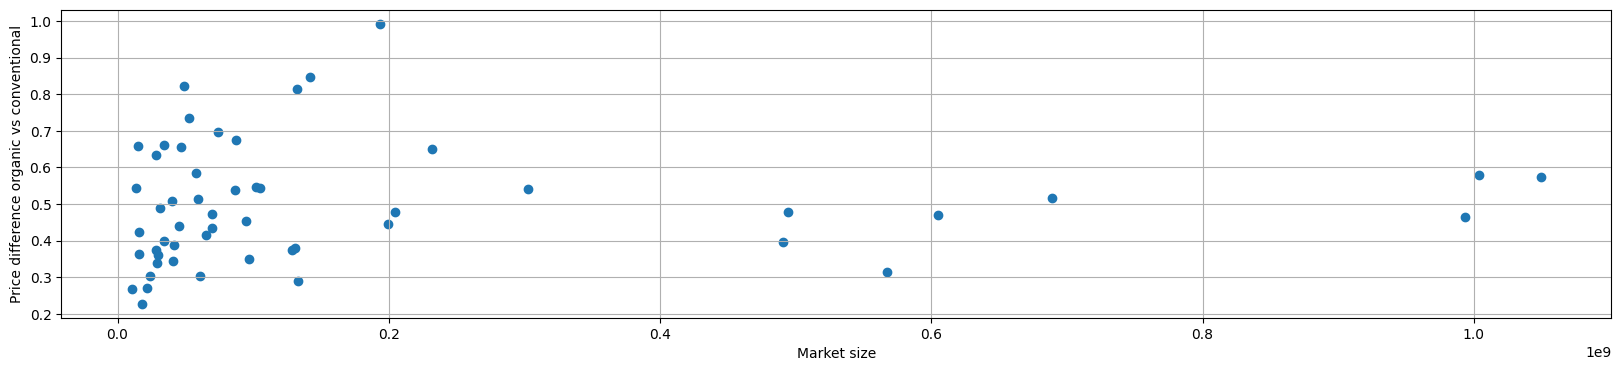

In [294]:
convencional_df = df_cp_cleaned[df_cp_cleaned['type']=='conventional']
organic_df = df_cp_cleaned[df_cp_cleaned['type']=='organic']

convencional_region_mean_total = convencional_df.groupby('region').agg({'Total Volume':'sum', 'AveragePrice':'mean'})#.nlargest(6)
organic_region_mean_total = organic_df.groupby('region').agg({'AveragePrice':'mean'})#.nlargest(6)

convencional_region_mean_total['Price difference'] = organic_region_mean_total['AveragePrice'] - convencional_region_mean_total['AveragePrice'] 

# display(new_df)
fig, ax= plt.subplots(figsize=(20,4))
x_values = convencional_region_mean_total['Total Volume']
# total_mean = new_convencional_region_mean_total['AveragePrice'].mean()
y_values = convencional_region_mean_total['Price difference'] #(new_convencional_region_mean_total['AveragePrice'] - total_mean)*100/total_mean
# c_values= convencional_region_mean_total['type'].map(type_coloring)

plt.scatter(x= x_values, y= y_values)#, c=c_values)
plt.ylabel('Price difference organic vs conventional')
plt.xlabel('Market size')
plt.grid()
plt.show()

#### Estacionalidad por región
* Se observa que en general el precio es más alto en verano y otoño.

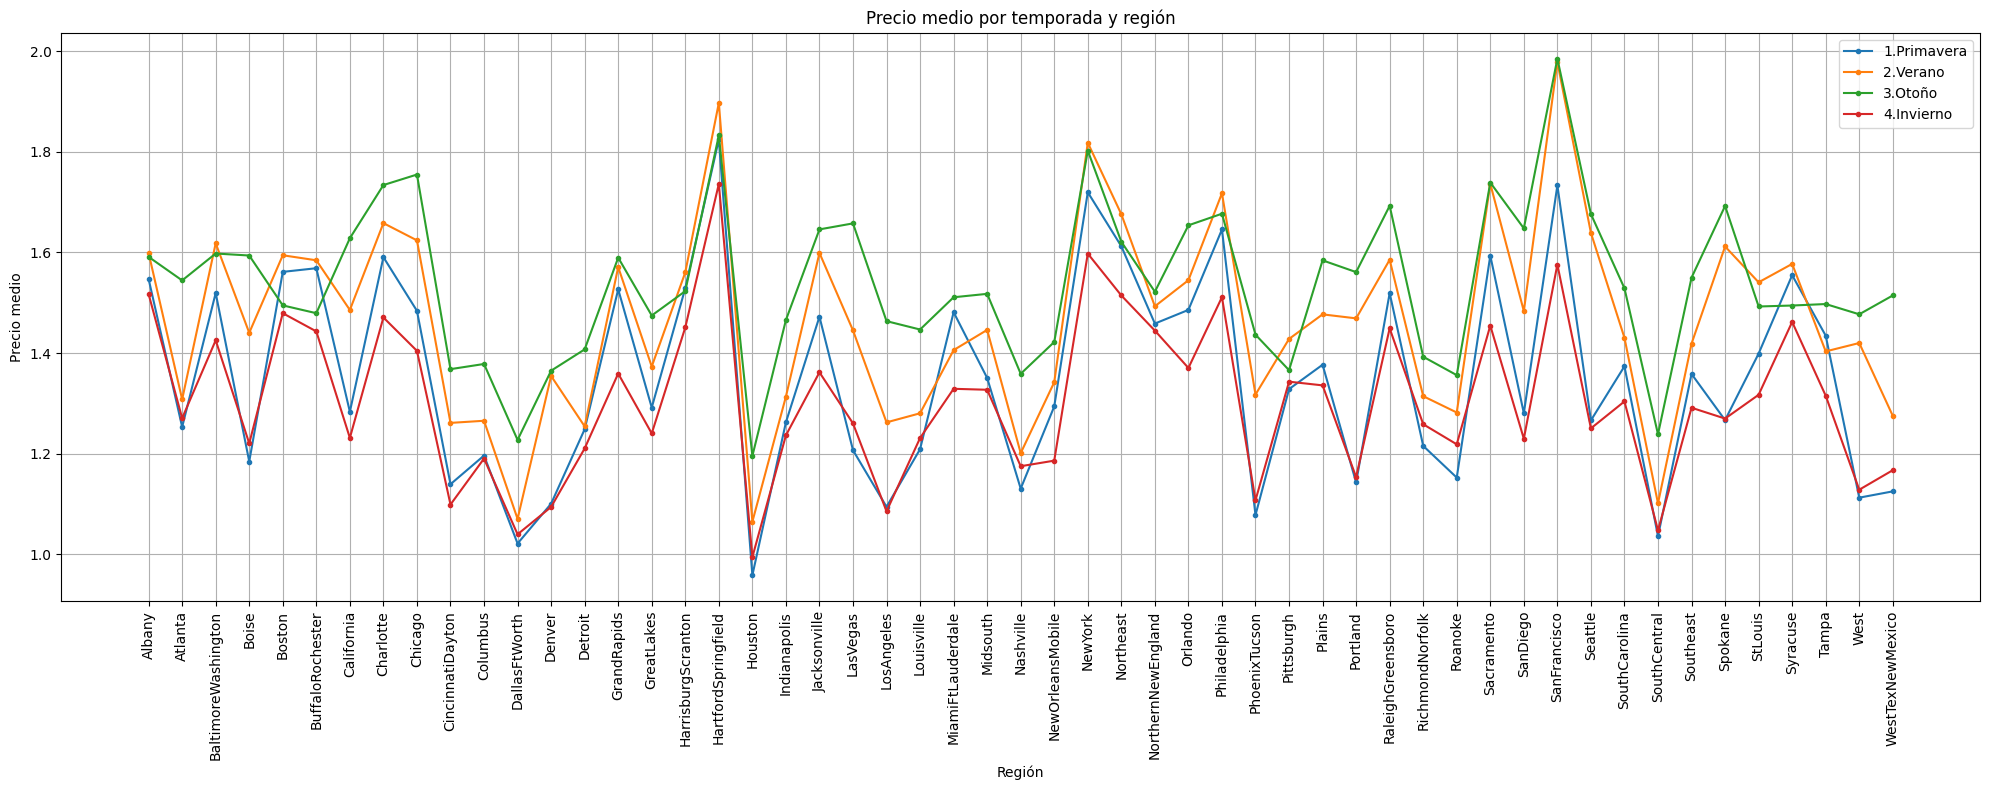

In [295]:
get_season = av.get_season()
df_date_price_volume = df_cp.copy()
df_date_price_volume = df_date_price_volume[df_date_price_volume['region'] != 'TotalUS']
df_date_price_volume = df_date_price_volume[['Date', 'region', 'AveragePrice', 'Total Volume']]
df_date_price_volume['Season'] = df_date_price_volume['Date'].apply(get_season)

df_grouped_mean = df_date_price_volume.groupby(['Season','region'])['AveragePrice'].mean()
df_grouped_mean = df_grouped_mean.reset_index()

seasons = df_grouped_mean['Season'].unique()
plt.figure(figsize=(20, 8)) 
for season in seasons:
    df_season = df_grouped_mean[df_grouped_mean['Season'] == season]
    plt.plot(df_season['region'], df_season['AveragePrice'], marker='.', label=season)
plt.title('Precio medio por temporada y región')
plt.xlabel('Región')
plt.ylabel('Precio medio')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#df_grouped_mean

##### Fechas con explosión de ventas
* TODO: Super Bowl
  * 2015: 2 de febrero
  * 2016: 7 de febrero
  * 2017: 6 de febrero
  * 2018: 5 de febrero

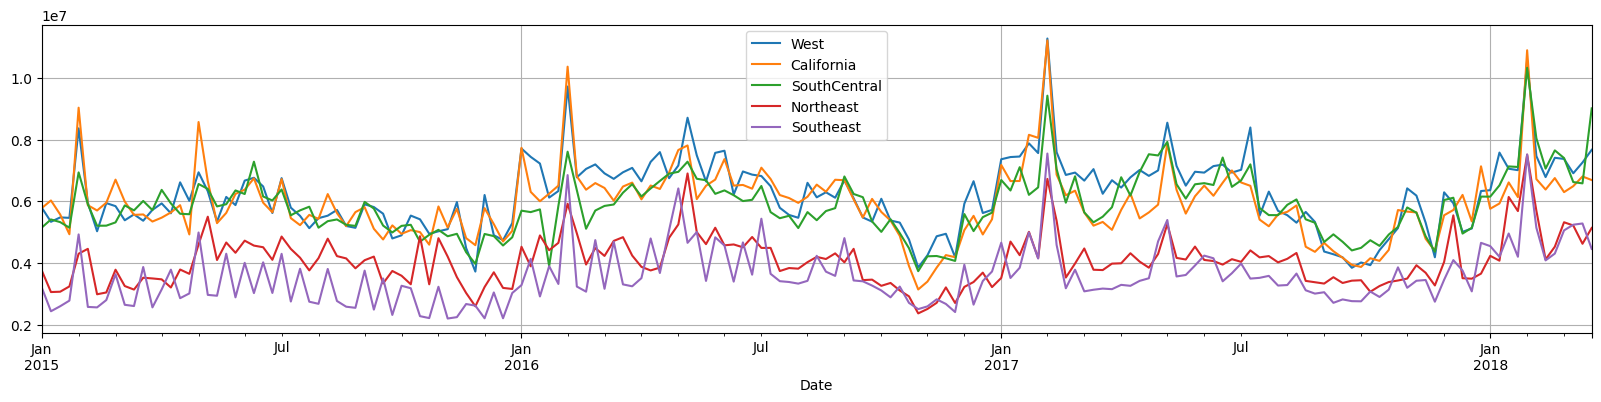

In [296]:
prova_= df_cp.copy()
index_df= df_cp.copy()
prova_= prova_[prova_['type']=='conventional']

index_df= index_df[index_df['region_class']=='GreaterRegion']
region_largest= list(index_df.groupby('region')['Total Volume'].sum().nlargest(5).index)
# region_largest.append('TotalUS')

fig, ax= plt.subplots(figsize=(20,4))
for region in region_largest:
    prova_temp = prova_[prova_['region']==region]
    prova_temp=prova_temp.sort_values(by='Date')
    prova_temp.plot(x= 'Date', y= 'Total Volume', ax=ax, label= region)
plt.legend(loc='best'); plt.grid(True)
plt.show()

##### TODO

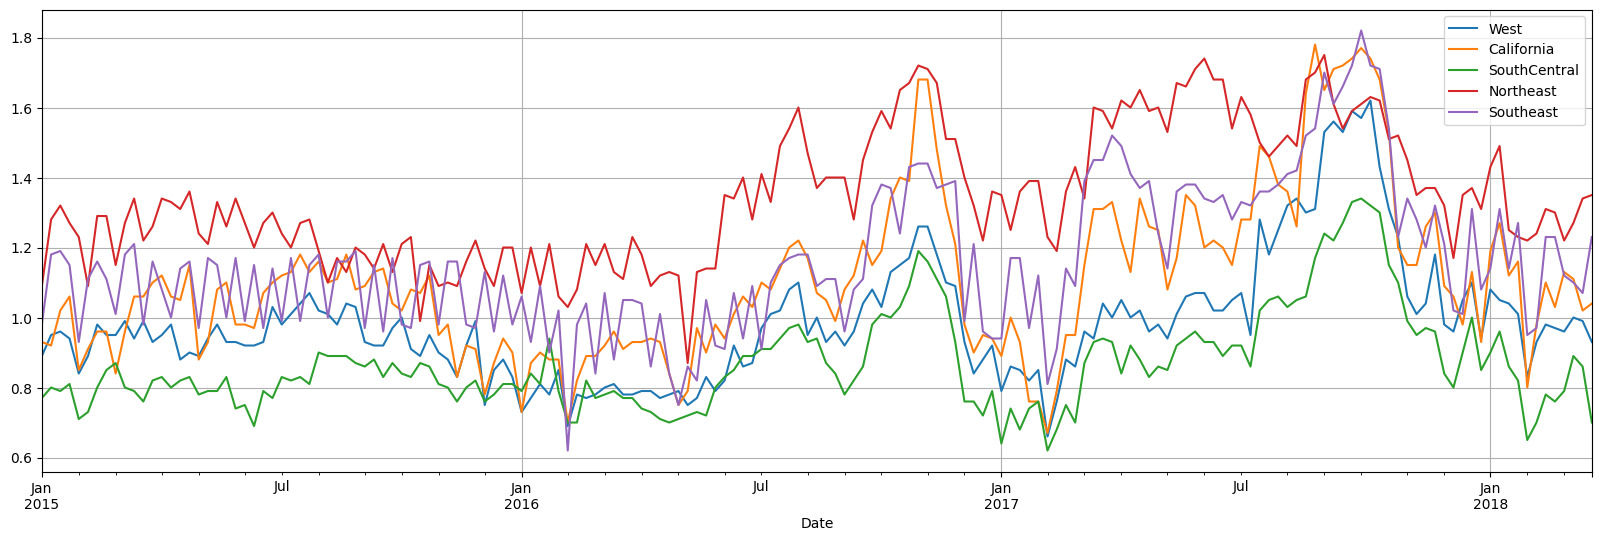

In [297]:
#df_cp_cleaned = av.df("df_cleaned")
prova_= df_cp.copy()
index_df= df_cp.copy()
prova_= prova_[prova_['type']=='conventional']

#great_dates= df_cp_cleaned.copy()
#great_dates= great_dates[great_dates['type']=='conventional']

index_df= df_cp.copy()
index_df= index_df[index_df['region_class']=='GreaterRegion']

region_largest= list(index_df.groupby('region')['Total Volume'].sum().nlargest(5).index)
#region_largest#.append('TotalUS')
fig, ax= plt.subplots(figsize=(20,6))
for region in region_largest:
    prova_temp = prova_[prova_['region']==region]
    prova_temp=prova_temp.sort_values(by='Date')
    prova_temp.plot(x= 'Date', y= 'AveragePrice', ax=ax, label= region)

plt.grid()
plt.show()

### Elasticidad

#### Further studies

* Els apartats anteriors han mostrat tendencies claras, pero encara aixi es complicat separar els efectes de convergencia de múltiples variables. Es per això que tractarem de fer subsets per a veure els efectes mes clars.
* Addicionalment tractarem de fer els càlculs d'elasticitat un cop fetes les separacions en el df

#### 2.1. Elasticidad Sobre el tiempo (Conventional USA)

In [298]:
# Creacion de la variable elasticidad y eliminacion de valores no utiles
df_cp_elast = df_cp.copy()

# Sort by year, asi la elasticidad se calcula entre los valores del mismo grupo
df_sort = df_cp_elast.sort_values(by=['region','type', 'year'])

df_USA = df_sort[df_sort['region']=='TotalUS']

df_USA_conv = df_USA[df_USA['type']=='conventional'].copy()
df_USA_conv['Elasticity'] = df_USA_conv['Total Volume'].pct_change() /  df_USA_conv['AveragePrice'].pct_change()
df_USA_conv =df_USA_conv[-df_USA_conv['Elasticity'].isin([-np.inf,np.inf])]

df_USA_organic = df_USA[df_USA['type']=='organic'].copy()
df_USA_organic['Elasticity'] = df_USA_organic['Total Volume'].pct_change() /  df_USA_organic['AveragePrice'].pct_change()
df_USA_organic =df_USA_organic[-df_USA_organic['Elasticity'].isin([-np.inf,np.inf])]

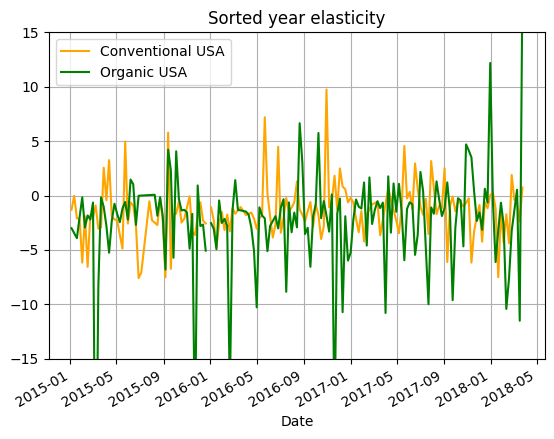

In [299]:
# Creem el group by adient
USA_conv_year = df_USA_conv.loc[1:,:].groupby("Date").agg({'Elasticity':"mean"})
USA_org_year = df_USA_organic.loc[1:,:].groupby("Date").agg({'Elasticity':"mean"})

#Plotejem
fig, ax = plt.subplots()
USA_conv_year.loc[:,'Elasticity'].plot(kind = 'line',ax= ax, label= 'Conventional USA', color = 'orange' )
USA_org_year.loc[:,'Elasticity'].plot(kind = 'line',ax= ax, label= 'Organic USA', color = 'green' )
# ax.set_xticks(USA_conv_year.index)
ax.grid()
plt.legend()
plt.ylim(-15,15)
plt.title('Sorted year elasticity')
plt.show()

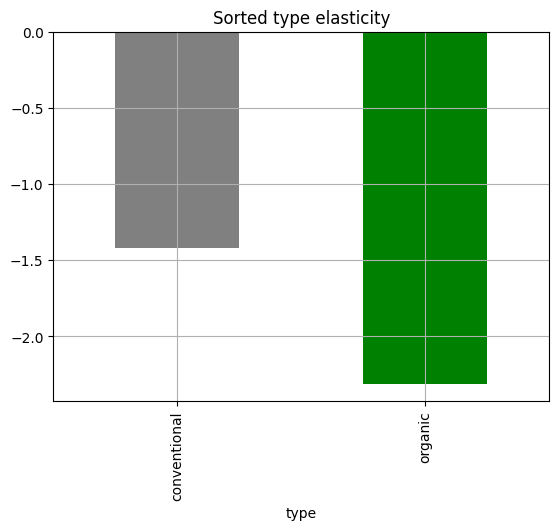

In [300]:
# Creem el group by adient
df_USA_temp = df_USA.copy()
df_USA_temp['Elasticity'] = df_USA_temp['Total Volume'].pct_change() /  df_USA_temp['AveragePrice'].pct_change()
df_USA_temp =df_USA_temp[-df_USA_temp['Elasticity'].isin([-np.inf,np.inf])]

type_elasticity_sort = df_USA_temp.loc[1:,:].groupby("type").agg({'Elasticity':"mean"})

type_elasticity_sort

#Plotejem
fig, ax = plt.subplots()
type_elasticity_sort.loc[:,'Elasticity'].plot(kind = 'bar',ax= ax, color = ['gray','green'])
# ax.set_xticks(region_elasticity_sort.index)
ax.grid()
plt.title('Sorted type elasticity')
plt.show()

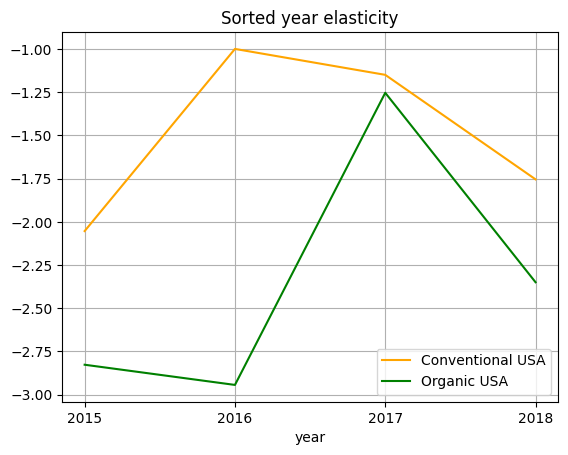

In [301]:
# Creem el group by adient
USA_conv_year = df_USA_conv.loc[1:,:].groupby("year").agg({'Elasticity':"mean"})
USA_org_year = df_USA_organic.loc[1:,:].groupby("year").agg({'Elasticity':"mean"})

#Plotejem
fig, ax = plt.subplots()
USA_conv_year.loc[:,'Elasticity'].plot(kind = 'line',ax= ax, label= 'Conventional USA', color = 'orange' )
USA_org_year.loc[:,'Elasticity'].plot(kind = 'line',ax= ax, label= 'Organic USA', color = 'green' )
ax.set_xticks(USA_conv_year.index)
ax.grid()
ax.legend()
# plt.ylim(-7.5,2.5)
plt.title('Sorted year elasticity')
plt.show()

#### 2.2. Elasticidad por Regiones, harémos por regiones mas grandes y en funcion del tiempo. Solo convencionales.

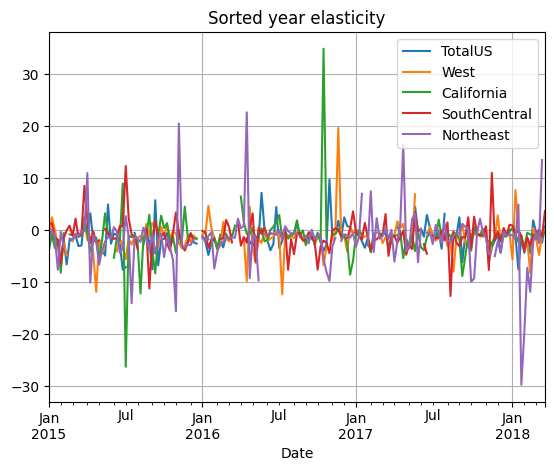

In [302]:
# Creacion de la variable elasticidad y eliminacion de valores no utiles
df_cp_elast = df_cp.copy()
region_largest= df_sort.groupby('region')['Total Volume'].sum().nlargest(5).index

# Sort by year, asi la elasticidad se calcula entre los valores del mismo grupo
df_sort = df_cp_elast.sort_values(by=['region','type', 'year'])
df_sort_conv = df_sort[df_sort['type'] == 'conventional'].copy()

fig, ax= plt.subplots()
for region in region_largest:

    region_subset = df_sort_conv[  df_sort_conv['region']== region ].copy()
    region_subset['Elasticity'] = region_subset['Total Volume'].pct_change() /  region_subset['AveragePrice'].pct_change()
    temp_groupby = region_subset.loc[1:,:].groupby('Date').agg({'Elasticity':"mean"})

    temp_groupby.loc[:,'Elasticity'].plot(kind = 'line', label = region, ax=ax)

ax.grid()
ax.legend()
# plt.ylim(-15,15)
plt.title('Sorted year elasticity')
plt.show()

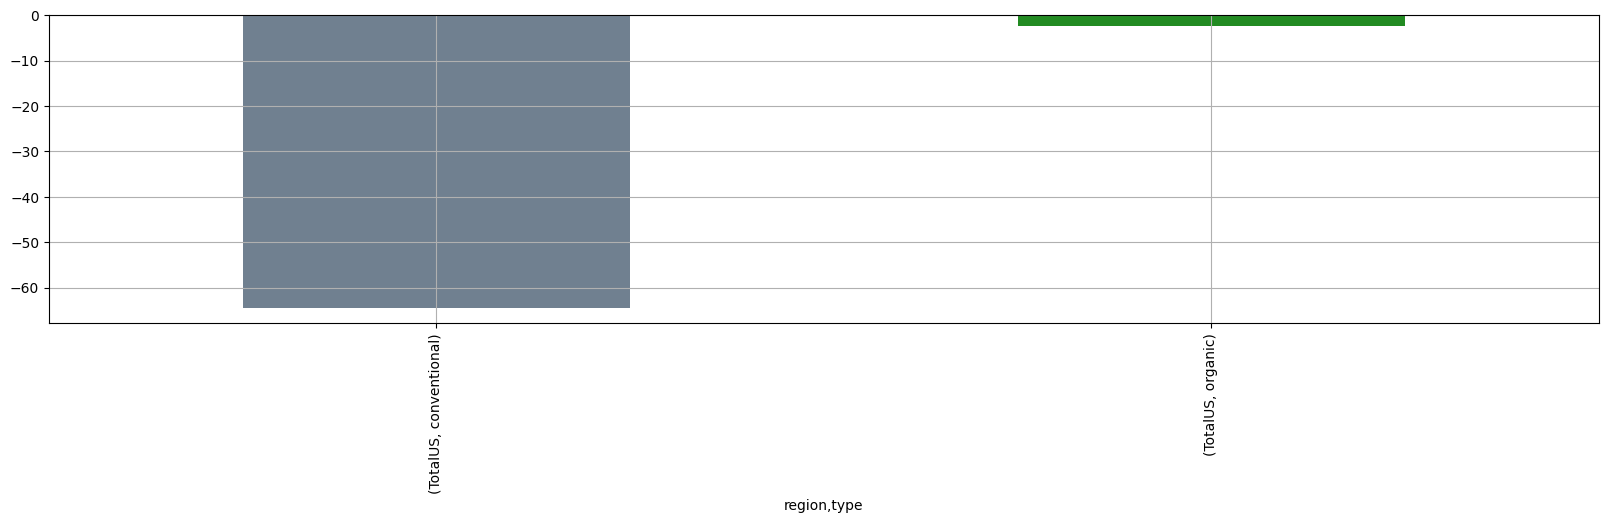

In [303]:
# Creacion de la variable elasticidad y eliminacion de valores no utiles
df_cp_elast = df_cp.copy()

# Sort by year, asi la elasticidad se calcula entre los valores del mismo grupo
df_elast_sort = df_cp_elast.sort_values(by=['region','type', 'year'])


# # Creem la variable elasticity per cada mesura y setejem el primer valor a 0
df_elast_sort['Elasticity'] = df_elast_sort['Total Volume'].pct_change() /  df_elast_sort['AveragePrice'].pct_change()

# # Els possibles valors entre infinit i menys infinit son ignorats per a un subset net
df_elast_sort =df_elast_sort[-df_elast_sort['Elasticity'].isin([-np.inf,np.inf])]
df_elast_sort = df_elast_sort.loc[1:,:]

#######################################################################################################################
df_elast_sort= df_elast_sort[df_elast_sort['region']=='TotalUS']
avocados_elasticity_mean = df_elast_sort.groupby(['region','type'])['Elasticity'].mean()#.nlargest(6)

avocados_elasticity_mean

fig, ax= plt.subplots(figsize=(20,4))
# avocados_relative_mean = (avocados_region_mean - total_mean)*100/total_mean
avocados_elasticity_mean.plot(kind = 'bar', color = ['slategray', 'forestgreen'])
plt.grid()
plt.show()

#### Otros
##### Prueba USA

* Veig coses molt rares per a total US. Probem 

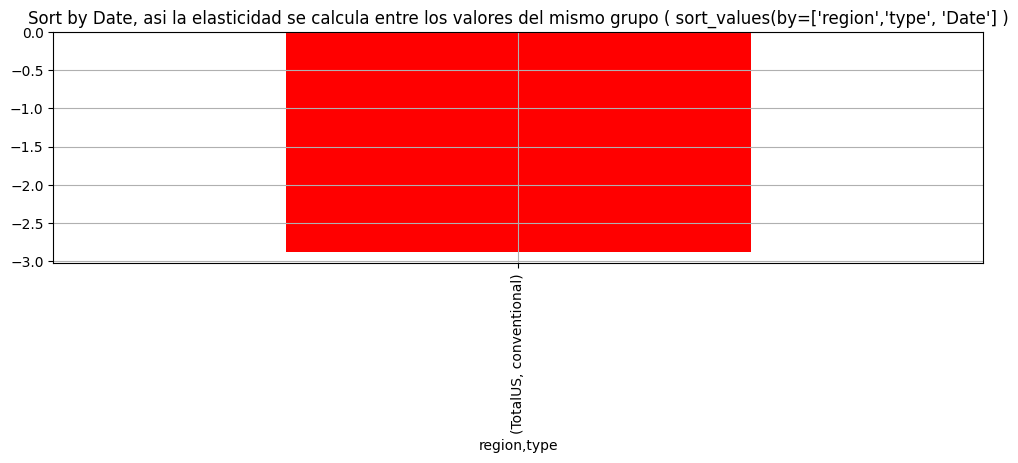

In [304]:
######### Calculo por cada region
# Creacion de la variable elasticidad y eliminacion de valores no utiles
# df_cp_elast = df_cp.copy()
df_cp_elast = df_cp.copy()
df_cp_elast = df_cp_elast[df_cp_elast['type'] == 'conventional']

# Sort by Date, asi la elasticidad se calcula entre los valores del mismo grupo
df_elast_sort = df_cp_elast.sort_values(by=['region','type', 'Date'])

# # Creem la variable elasticity per cada mesura y setejem el primer valor a 0
df_elast_sort['Elasticity'] = df_elast_sort['Total Volume'].pct_change() /  df_elast_sort['AveragePrice'].pct_change()

# # Els possibles valors entre infinit i menys infinit son ignorats per a un subset net
df_elast_sort =df_elast_sort[-df_elast_sort['Elasticity'].isin([-np.inf,np.inf])]
df_elast_sort = df_elast_sort.loc[1:,:]

#######################################################################################################################
df_elast_sort= df_elast_sort[df_elast_sort['region']=='TotalUS']

avocados_elasticity_mean = df_elast_sort.groupby(['region','type'])['Elasticity'].mean()#.nlargest(6)

fig, ax= plt.subplots(figsize=(12,3))
# avocados_relative_mean = (avocados_region_mean - total_mean)*100/total_mean
avocados_elasticity_mean.plot(kind = 'bar', color = ['red', 'forestgreen'])
plt.title("Sort by Date, asi la elasticidad se calcula entre los valores del mismo grupo ( sort_values(by=['region','type', 'Date'] )")
plt.grid()
plt.show()


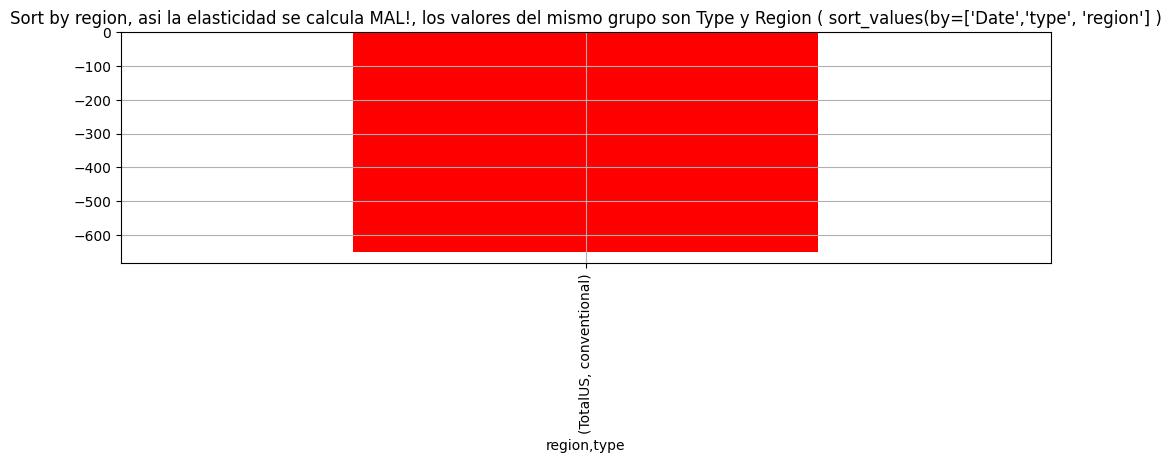

In [305]:
df_cp_elast = df_cp.copy()
df_cp_elast = df_cp_elast[df_cp_elast['type'] == 'conventional']

# Sort by Region, asi la elasticidad se calcula entre los valores del mismo grupo
df_elast_sort = df_cp_elast.sort_values(by=['Date','type', 'region'])

# # Creem la variable elasticity per cada mesura y setejem el primer valor a 0
df_elast_sort['Elasticity'] = df_elast_sort['Total Volume'].pct_change() /  df_elast_sort['AveragePrice'].pct_change()

# # Els possibles valors entre infinit i menys infinit son ignorats per a un subset net
df_elast_sort =df_elast_sort[-df_elast_sort['Elasticity'].isin([-np.inf,np.inf])]
df_elast_sort = df_elast_sort.loc[1:,:]

#######################################################################################################################
df_elast_sort= df_elast_sort[df_elast_sort['region']=='TotalUS']

avocados_elasticity_mean = df_elast_sort.groupby(['region','type'])['Elasticity'].mean()#.nlargest(6)

fig, ax= plt.subplots(figsize=(12,3))
# avocados_relative_mean = (avocados_region_mean - total_mean)*100/total_mean
avocados_elasticity_mean.plot(kind = 'bar', color = ['red', 'forestgreen'])
plt.title("Sort by region, asi la elasticidad se calcula MAL!, los valores del mismo grupo son Type y Region ( sort_values(by=['Date','type', 'region'] )")
plt.grid()
plt.show()

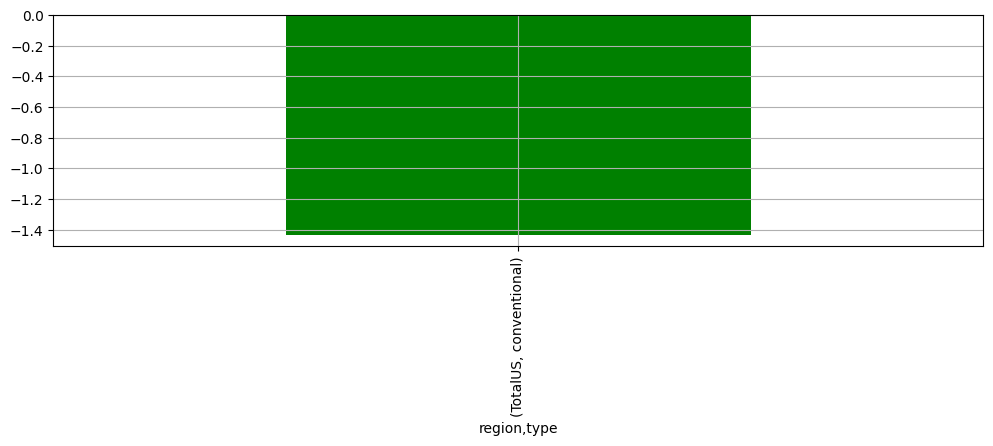

In [306]:
######### Calculo por cada region
# Creacion de la variable elasticidad y eliminacion de valores no utiles
df_cp_elast = df_cp.copy()

df_cp_elast = df_cp_elast[df_cp_elast['type'] == 'conventional']
df_cp_elast = df_cp_elast[df_cp_elast['region'] == 'TotalUS']

# Sort by year, asi la elasticidad se calcula entre los valores del mismo grupo
df_elast_sort = df_cp_elast.sort_values(by=['region','type', 'Date']).reset_index()


# # Creem la variable elasticity per cada mesura y setejem el primer valor a 0
df_elast_sort['Elasticity'] = df_elast_sort['Total Volume'].pct_change() /  df_elast_sort['AveragePrice'].pct_change()

# # Els possibles valors entre infinit i menys infinit son ignorats per a un subset net


#########Important a comentar (TODO TO explain in presentation)
df_elast_sort =df_elast_sort[-df_elast_sort['Elasticity'].isin([-np.inf,np.inf])]
df_elast_sort = df_elast_sort.loc[1:,:]

#######################################################################################################################
# df_elast_sort= df_elast_sort[df_elast_sort['region']=='TotalUS']
avocados_elasticity_mean = df_elast_sort.groupby(['region','type'])['Elasticity'].mean()#.nlargest(6)

avocados_elasticity_mean

fig, ax= plt.subplots(figsize=(12,3))
# avocados_relative_mean = (avocados_region_mean - total_mean)*100/total_mean
avocados_elasticity_mean.plot(kind = 'bar', color = ['green', 'forestgreen'])
plt.grid()
plt.show()

#### Regiones correctas

In [307]:
# Ara sabem que hem d'anar amb molta compte a la mesura 

In [308]:
# # Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. Aqui estem prenent cada regio com equivalentment valida
# # cambiar el 2018 no parece afectar los resultados
# df_cp_elast = df_cp.copy()

# df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'year'])

# fig, ax=plt.subplots()

# for region in pd.unique(df_cp_elast['region']):

#     elast_region = df_cp_elast[df_cp_elast['region'] == region].copy()
#     temp_market_size= elast_region['Total Volume'].sum()


#     conventional_df = elast_region[elast_region['type'] == 'conventional'].copy().reset_index()
#     conventional_df['Elasticity'] = conventional_df['Total Volume'].pct_change() /  conventional_df['AveragePrice'].pct_change()
#     conventional_df =conventional_df[-conventional_df['Elasticity'].isin([-np.inf,np.inf])]
    
#     conv_value = conventional_df.loc[1:,'Elasticity'].mean()

#     # display(conventional_df.loc[1:,'Elasticity'])

#     # print(conv_value)

#     org_df = elast_region[elast_region['type'] == 'organic'].copy().reset_index()
#     org_df['Elasticity'] = org_df['Total Volume'].pct_change() /  org_df['AveragePrice'].pct_change()
#     org_df =org_df[-org_df['Elasticity'].isin([-np.inf,np.inf])]
#     org_value = org_df.loc[1:,'Elasticity'].mean()

#     # print(temp_market_size, conv_value, org_value)
#     ax.scatter(x=temp_market_size, y= conv_value, color = 'gray')
#     ax.scatter(x=temp_market_size, y= org_value, color = 'green')

# plt.xscale('log')
# plt.ylabel('Average Price Elasticity')
# plt.axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0
# plt.xlabel('Market size')
# plt.grid()
# plt.show()

In [309]:
# # Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
# #Aqui estem prenent cada regio com equivalentment valida
# # cambiar el 2018 no parece afectar los resultados
# df_cp_elast = df_cp.copy()
# df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'year'])

# # df_cp_elast = df_cp_elast[df_cp_elast['type']=='conventional']

# fig, ax=plt.subplots()

# for region in pd.unique(df_cp_elast['region']):

#     elast_region = df_cp_elast[df_cp_elast['region'] == region].copy()
#     # temp_market_size= elast_region['Total Volume'].sum()


#     conventional_df = elast_region[elast_region['type'] == 'organic'].copy().reset_index()
#     conventional_df['Variation Volume'] = conventional_df['Total Volume'].pct_change() 
#     conventional_df['Variation AveragePrice'] =  conventional_df['AveragePrice'].pct_change()

    
#     color= classification_colors[conventional_df.loc[1,'region_class']]#.map(classification_colors)
#     y_values = conventional_df.loc[1:,'Variation Volume']
#     x_values = conventional_df.loc[1:,'Variation AveragePrice']
#     ax.scatter(x=x_values, y= y_values, color = color, alpha = 0.2)

# # plt.xscale('log')
# plt.ylabel('Volume Variation')
# plt.xlabel('Price Variation')
# plt.ylim(-1,5)
# plt.xlim(-0.5,1.5)
# plt.grid()
# plt.show()

#### Los siguientes son interesantes hasta el final

##### Comparativa Variacion volumen precio, en tipos aguacate

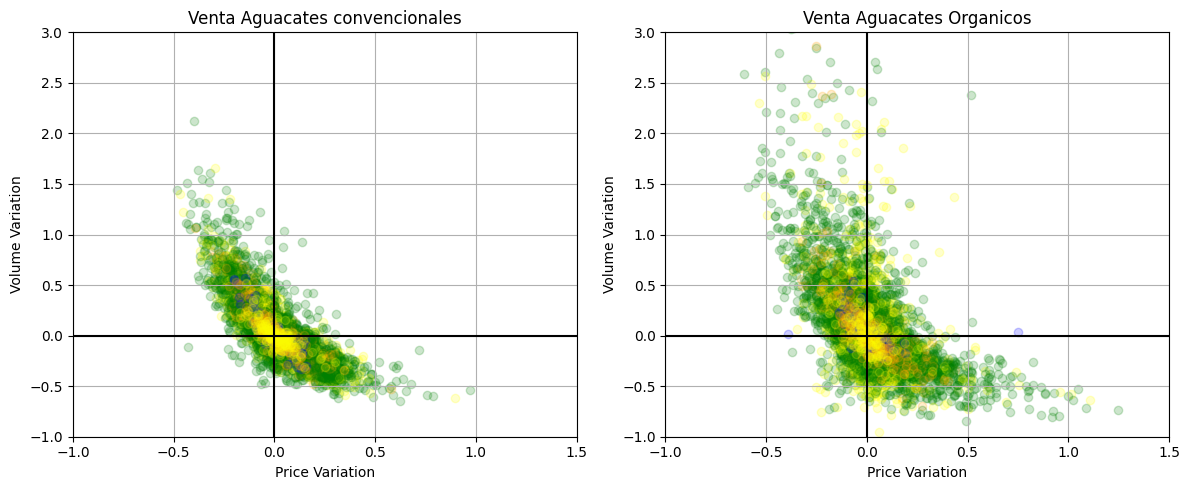

In [310]:
#import matplotlib.pyplot as plt
#import numpy as np
#import pandas as pd

df_cp_elast = av.df('df_cp') # df_cp.copy()
classification_colors = {'City':'green' ,'Region':'yellow' ,'GreaterRegion':'orange', 'State':'red', 'TotalUS': 'blue'}

df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'Date'])

# Crear la figura y los subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

for region in pd.unique(df_cp_elast['region']):
    elast_region = df_cp_elast[df_cp_elast['region'] == region].copy()

    conventional_df = elast_region[elast_region['type'] == 'conventional'].copy().reset_index()
    conventional_df['Variation Volume'] = conventional_df['Total Volume'].pct_change() 
    conventional_df['Variation AveragePrice'] =  conventional_df['AveragePrice'].pct_change()

    color= classification_colors[conventional_df.loc[1,'region_class']]#.map(classification_colors)
    y_values = conventional_df.loc[1:,'Variation Volume']
    x_values = conventional_df.loc[1:,'Variation AveragePrice']
    axs[0].scatter(x=x_values, y= y_values, color = color, alpha = 0.2)
    
    organic_df = elast_region[elast_region['type'] == 'organic'].copy().reset_index()
    organic_df['Variation Volume'] = organic_df['Total Volume'].pct_change() 
    organic_df['Variation AveragePrice'] =  organic_df['AveragePrice'].pct_change()

    color= classification_colors[organic_df.loc[1,'region_class']]#.map(classification_colors)
    y_values_org = organic_df.loc[1:,'Variation Volume']
    x_values_org  = organic_df.loc[1:,'Variation AveragePrice']
    axs[1].scatter(x=x_values_org, y= y_values_org, color = color, alpha = 0.2)

# axs[0].set_xscale('log')
axs[0].set_ylabel('Volume Variation')
axs[0].set_xlabel('Price Variation')
axs[0].set_ylim(-1,3)
axs[0].set_xlim(-1,1.5)
axs[0].set_title('Venta Aguacates convencionales')
axs[0].axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0
axs[0].axvline(0, color='black', linewidth=1.5, linestyle='-')  # Vertical line at x=0
axs[0].grid()

axs[1].set_ylabel('Volume Variation')
axs[1].set_xlabel('Price Variation')
axs[1].set_ylim(-1,3)
axs[1].set_xlim(-1,1.5)
axs[1].set_title('Venta Aguacates Organicos')
axs[1].grid()
axs[1].axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0
axs[1].axvline(0, color='black', linewidth=1.5, linestyle='-')  # Vertical line at x=0
# Mostrar el gráfico
plt.tight_layout()  # Ajusta el espaciado
plt.show()

##### Elasticidad por region con barras

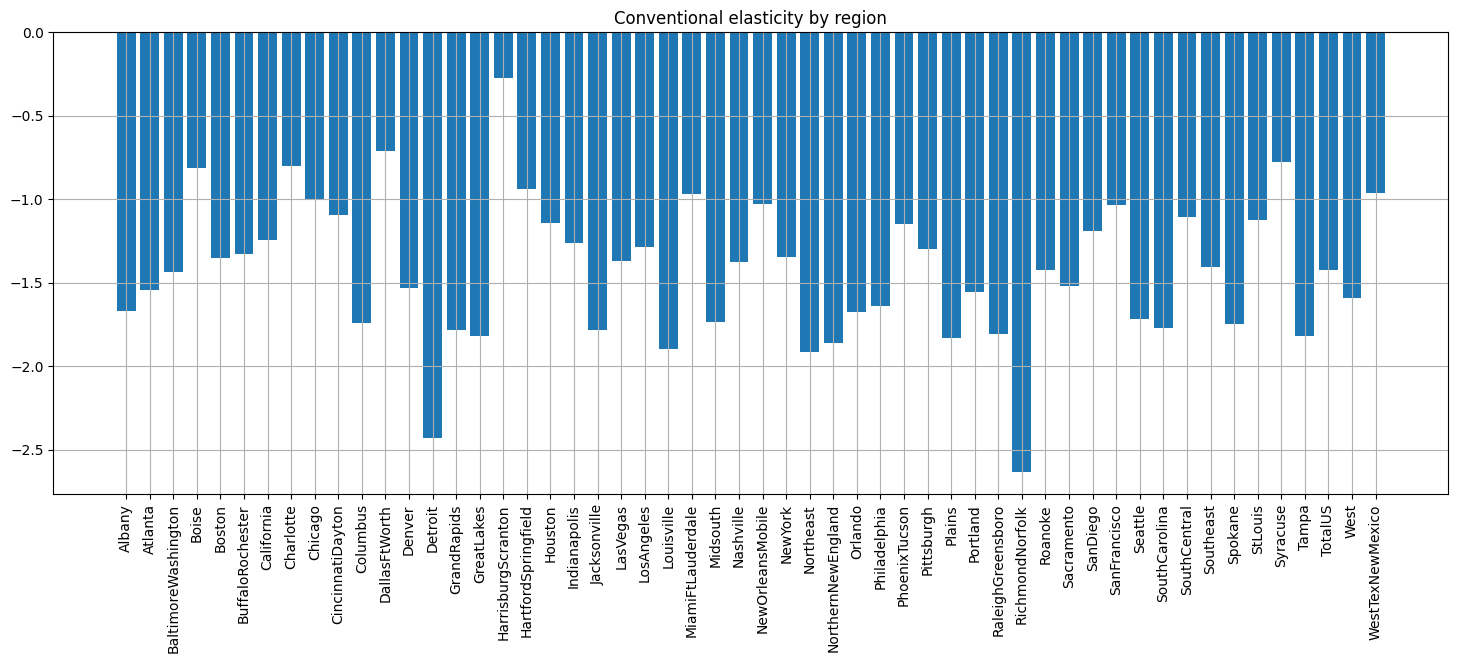

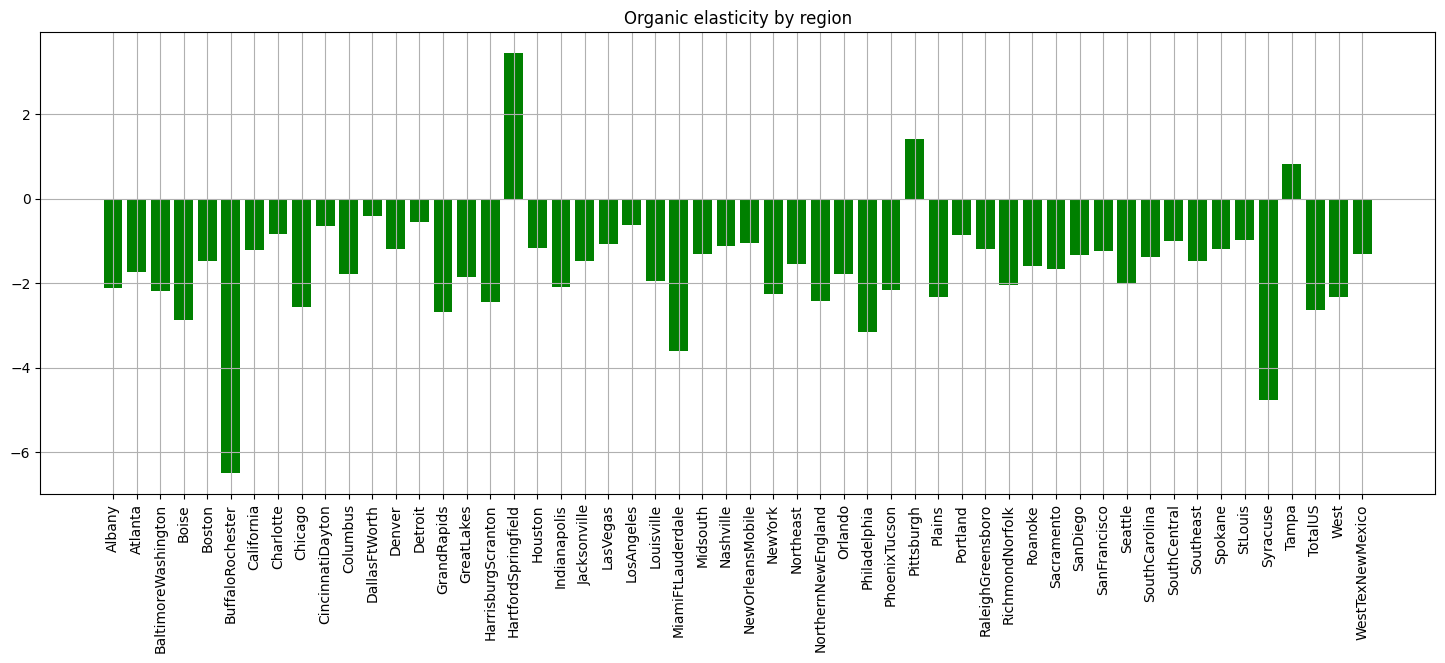

In [311]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_cp_elast = df_cp.copy()
df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'Date'])

# Crear la figura y los subplots

labels_reg_conv= []
elasticty_av_conv = []

labels_reg_org= []
elasticty_av_org = []

for region in pd.unique(df_cp_elast['region']):

    elast_region = df_cp_elast[df_cp_elast['region'] == region].copy()

    conventional_df = elast_region[elast_region['type'] == 'conventional'].copy().reset_index()


    
    conventional_df['Elasticity'] = conventional_df['Total Volume'].pct_change() /  conventional_df['AveragePrice'].pct_change()
    conventional_df =conventional_df[-conventional_df['Elasticity'].isin([-np.inf,np.inf])]
    conventional_df = conventional_df.iloc[1:-1,:]




    labels_reg_conv.append(region)
    elasticty_av_conv.append(conventional_df['Elasticity'].mean())

    organic_df = elast_region[elast_region['type'] == 'organic'].copy().reset_index()
    organic_df['Elasticity'] = organic_df['Total Volume'].pct_change() /  organic_df['AveragePrice'].pct_change()
    organic_df =organic_df[-organic_df['Elasticity'].isin([-np.inf,np.inf])]
    organic_df = organic_df.iloc[1:-1,:]

    labels_reg_org.append(region)
    elasticty_av_org.append(organic_df['Elasticity'].mean())

# fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
fig, ax= plt.subplots(figsize=(18,6) )
ax.bar(x=labels_reg_conv ,height = elasticty_av_conv , label = labels_reg_conv)
plt.xticks(rotation=90)
plt.title('Conventional elasticity by region')
plt.grid()
plt.show()

# fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
fig, ax= plt.subplots(figsize=(18,6) )
ax.bar(x=labels_reg_org ,height = elasticty_av_org , label = labels_reg_org, color = 'green')
plt.xticks(rotation=90)
plt.title('Organic elasticity by region')
plt.grid()
plt.show()

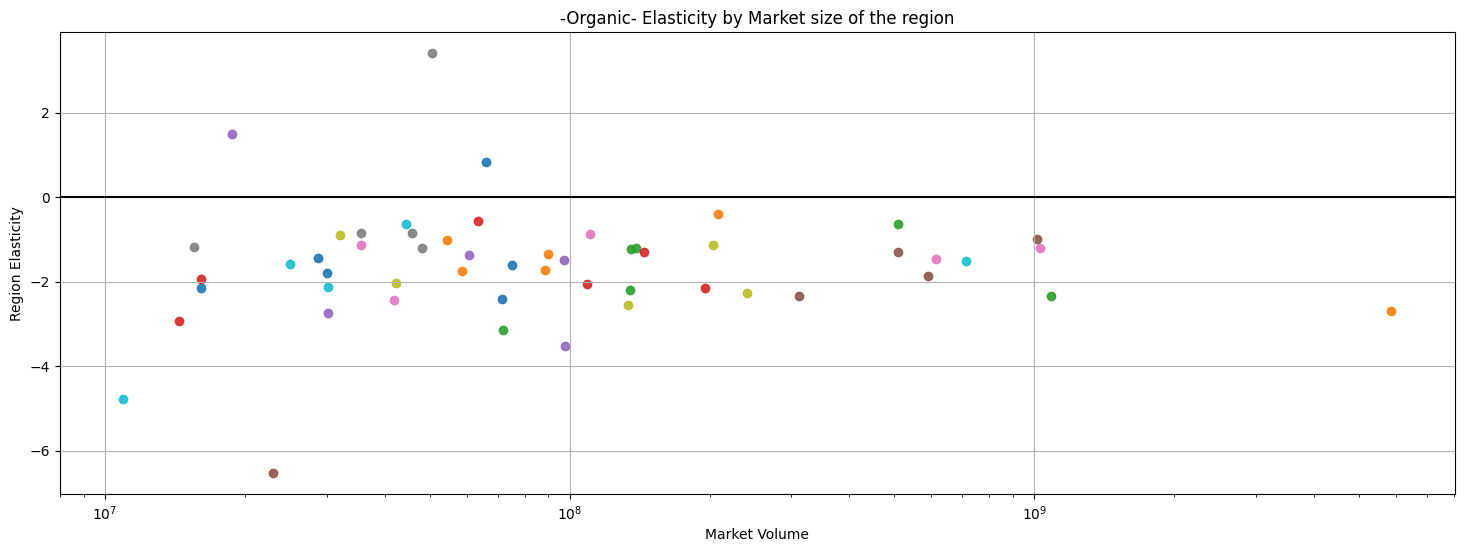

In [312]:
# Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
#Aqui estem prenent cada regio com equivalentment valida
# cambiar el 2018 no parece afectar los resultados
df_cp_elast = df_cp.copy()

# df_cp_elast = df_cp_elast[df_cp_elast['region']!= 'TotalUS']

df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'Date'])

# display(df_cp_elast)

# df_cp_elast = df_cp_elast[df_cp_elast['type']=='conventional']

#fig, ax=plt.subplots()
fig, ax= plt.subplots(figsize=(18,6) )

for region in pd.unique(df_cp_elast['region']):

    elast_region = df_cp_elast[df_cp_elast['region'] == region].copy()
    temp_market_size= elast_region['Total Volume'].sum()

    organic_df = elast_region[elast_region['type'] == 'organic'].copy().reset_index()
    organic_df['Variation Volume'] = organic_df['Total Volume'].pct_change() 
    organic_df['Variation AveragePrice'] =  organic_df['AveragePrice'].pct_change()

    organic_df['Elasticity'] = organic_df['Total Volume'].pct_change() / organic_df['AveragePrice'].pct_change()
    
    organic_df = organic_df[-organic_df['Elasticity'].isin([-np.inf,np.inf])]

    
    # color= classification_colors[conventional_df.loc[1,'region_class']]#.map(classification_colors)
    y_values = organic_df.loc[1:,'Elasticity'].mean()
    x_values = organic_df.loc[1:,'Variation AveragePrice']
    ax.scatter(x=temp_market_size, y= y_values, alpha = 0.9, label= region)

plt.xscale('log')
plt.ylabel('Region Elasticity')
plt.xlabel('Market Volume')
plt.axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0
plt.title('-Organic- Elasticity by Market size of the region')
# plt.legend()
plt.grid()
plt.show()

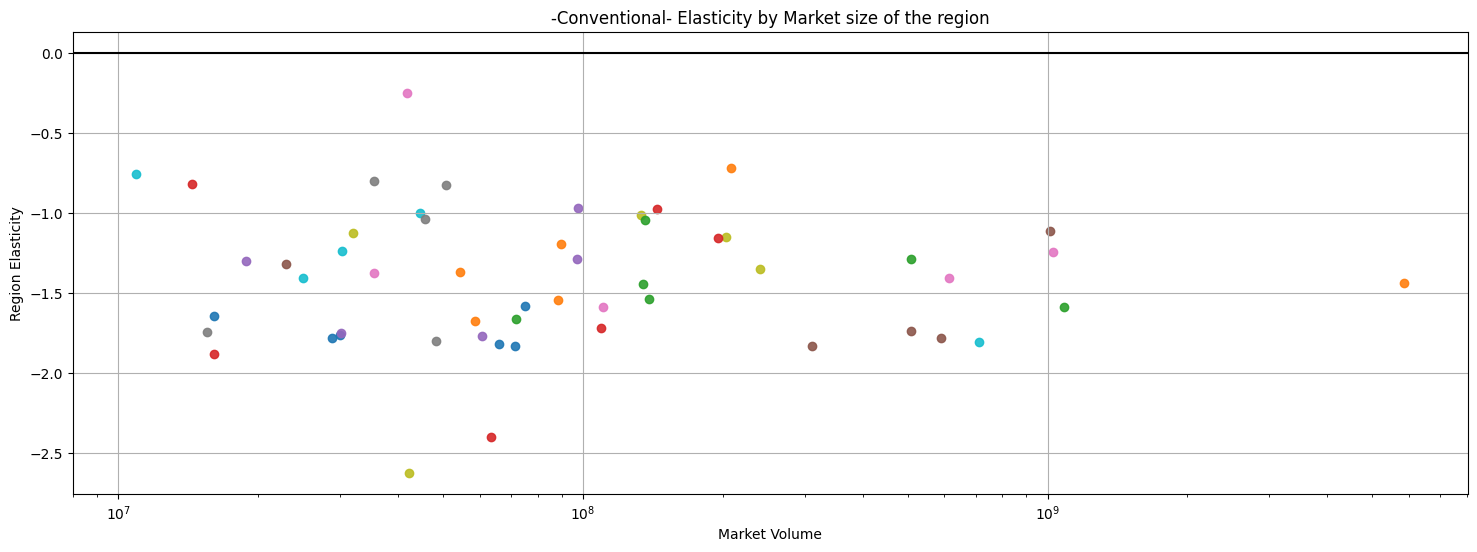

In [313]:
# Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
#Aqui estem prenent cada regio com equivalentment valida
# cambiar el 2018 no parece afectar los resultados
df_cp_elast = df_cp.copy()

df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'Date'])

#fig, ax=plt.subplots()
fig, ax= plt.subplots(figsize=(18,6) )

for region in pd.unique(df_cp_elast['region']):

    elast_region = df_cp_elast[df_cp_elast['region'] == region].copy()
    temp_market_size= elast_region['Total Volume'].sum()


    conventional_df = elast_region[elast_region['type'] == 'conventional'].copy().reset_index()
    conventional_df['Variation Volume'] = conventional_df['Total Volume'].pct_change() 
    conventional_df['Variation AveragePrice'] =  conventional_df['AveragePrice'].pct_change()

    conventional_df['Elasticity'] = conventional_df['Total Volume'].pct_change() / conventional_df['AveragePrice'].pct_change()
    
    conventional_df = conventional_df[-conventional_df['Elasticity'].isin([-np.inf,np.inf])]

    
    # color= classification_colors[conventional_df.loc[1,'region_class']]#.map(classification_colors)
    y_values = conventional_df.loc[1:,'Elasticity'].mean()
    x_values = conventional_df.loc[1:,'Variation AveragePrice']
    ax.scatter(x=temp_market_size, y= y_values, alpha = 0.9, label= region)

plt.xscale('log')
plt.ylabel('Region Elasticity')
plt.xlabel('Market Volume')
plt.axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0
plt.title('-Conventional- Elasticity by Market size of the region')
# plt.legend()
plt.grid()
plt.show()

#### Regiones correctas Bag elasticity

In [314]:
# # Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
# #Aqui estem prenent cada regio com equivalentment valida
# # cambiar el 2018 no parece afectar los resultados
# df_cp_elast = df_cp.copy()
# df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'Date'])

# region_largest= df_cp_elast.groupby('region')['Total Volume'].sum().nlargest(8).index

# type_avocado = 'conventional'

# labels = []

# small_heights = []
# Large_heights = []
# XLarge_heights = []

# for region in pd.unique(region_largest):
#     # region = 'TotalUS'
#     elast_region_bags = df_cp_elast[df_cp_elast['region'] == region].copy()
#     elast_region_bags = elast_region_bags[elast_region_bags['type'] == type_avocado].copy().reset_index()
   
#     # temp_market_size= elast_region['Total Volume'].sum()

#     elast_region_bags['Small bag Variation']= elast_region_bags['Small Bags'].pct_change()# /  elast_region_bags['AveragePrice'].pct_change()
#     elast_region_bags['Large bag Variation']= elast_region_bags['Large Bags'].pct_change() #/  elast_region_bags['AveragePrice'].pct_change()
#     elast_region_bags['XLarge bag Variation']= elast_region_bags['XLarge Bags'].pct_change() #/  elast_region_bags['AveragePrice'].pct_change()
#     elast_region_bags['XLarge bag Variation']= elast_region_bags['AveragePrice'].pct_change()

#     # # Els possibles valors entre infinit i menys infinit son ignorats per a un subset net
#     # elast_region_bags =elast_region_bags[-elast_region_bags['Small bag elasticity'].isin([-np.inf,np.inf])]
#     # elast_region_bags =elast_region_bags[-elast_region_bags['Large bag elasticity'].isin([-np.inf,np.inf])]
#     # elast_region_bags =elast_region_bags[-elast_region_bags['XLarge bag elasticity'].isin([-np.inf,np.inf])]

#     small_heights.append(elast_region_bags['Small bag Variation'].mean())
#     Large_heights.append(elast_region_bags['Large bag Variation'].mean())
#     XLarge_heights.append(elast_region_bags['XLarge bag Variation'].mean())
#     labels.append(region)

#     if region == 'California':
#         display(elast_region_bags)

# fig, ax=plt.subplots(figsize= (12,8))

# # Define the positions for the bars on the x-axis
# x = np.arange(len(labels))
# width = 0.3  # Width of the bars
# distance = 0.3

# bar1 = ax.bar(x , small_heights, width, label='Small Bags')
# bar2 = ax.bar(x - distance , Large_heights, width, label='Large Bags')
# bar3 = ax.bar(x + distance, XLarge_heights, width, label='XLarge Bags')

# # Labels and title
# ax.set_xlabel('Regions')
# ax.set_ylabel('Bag Variation')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()
# plt.title('Bag Variation by size')
# plt.axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0

# for x_value in x:
#     plt.axvline(x_value, color='black', linewidth=0.2, linestyle='-') 
    
# plt.xticks(rotation=90)
# plt.grid()
# # Show the plot
# plt.show()

level_0  index       Date  AveragePrice  Total Volume  Volume_Hass_S  \
10     2379   2379 2015-03-29          0.82    5713017.35     3091049.63   
11     2378   2378 2015-04-05          0.83    6368728.85     3676642.17   
12     2377   2377 2015-04-12          0.80    5930072.71     3851189.34   
13     2376   2376 2015-04-19          0.82    5593885.09     3657278.94   
14     2375   2375 2015-04-26          0.83    5578980.69     3637682.35   

    Volume_Hass_L  Volume_Hass_XL  Total Bags  Small Bags  ...          type  \
10     1836365.62        89374.20   696227.90   633029.23  ...  conventional   
11     1856953.20       104285.22   730848.26   670637.73  ...  conventional   
12     1385674.25       102729.01   590480.11   536034.76  ...  conventional   
13     1183497.85       114923.71   638184.59   538970.63  ...  conventional   
14     1248422.73        73076.91   619798.70   519975.08  ...  conventional   

    year        region   region_class Suma Volums   Variacio    RegionClass  \
10  2015  SouthCentral  GreaterRegion  5016789.45  12.186693  GreaterRegion   
11  2015  SouthCentral  GreaterRegion  5637880.59  11.475575  GreaterRegion   
12  2015  SouthCentral  GreaterRegion  5339592.60   9.957384  GreaterRegion   
13  2015  SouthCentral  GreaterRegion  4955700.50  11.408611  GreaterRegion   
14  2015  SouthCentral  GreaterRegion  4959181.99  11.109533  GreaterRegion   

    Small bag elasticity Large bag elasticity  XLarge bag elasticity  
10              2.166751            -6.271725               7.920000  
11              4.871650            -5.814399            3166.070984  
12              5.552947             2.007227              27.283777  
13              0.219081            32.911233             -19.981096  
14             -2.890019             0.187701            2962.375826  

[5 rows x 22 columns]

           level_0        index                           Date  AveragePrice  \
count   156.000000   156.000000                            156    156.000000   
mean   5574.416667  5574.416667  2016-08-27 20:46:09.230769152      0.872372   
min    2341.000000  2341.000000            2015-01-04 00:00:00      0.620000   
25%    2383.500000  2383.500000            2015-11-06 06:00:00      0.780000   
50%    5182.500000  5182.500000            2016-09-07 12:00:00      0.835000   
75%    8024.250000  8024.250000            2017-06-19 18:00:00      0.932500   
max    9029.000000  9029.000000            2018-03-25 00:00:00      1.340000   
std    2450.562342  2450.562342                            NaN      0.143487   

       Total Volume  Volume_Hass_S  Volume_Hass_L  Volume_Hass_XL  \
count  1.560000e+02   1.560000e+02   1.560000e+02      156.000000   
mean   5.876758e+06   3.127538e+06   1.293206e+06   125474.259487   
min    3.733135e+06   1.193350e+06   7.136460e+05     6332.780000   
25%

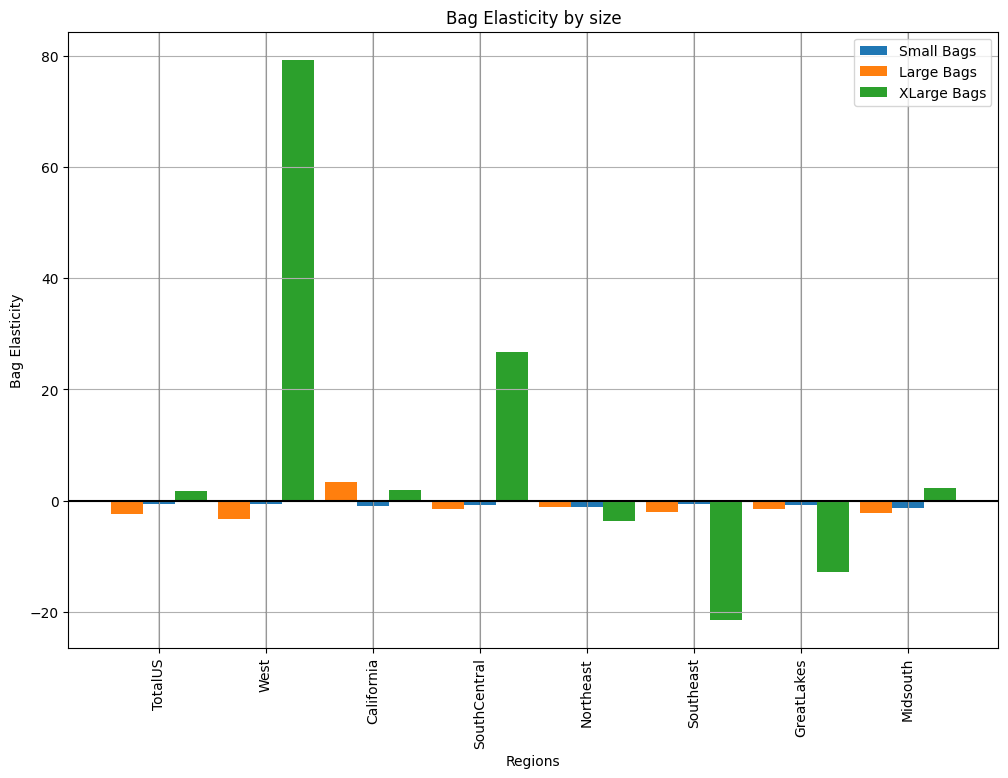

In [315]:
# Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
#Aqui estem prenent cada regio com equivalentment valida
# cambiar el 2018 no parece afectar los resultados
df_cp_elast = df_cp.copy()
df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'Date'])

region_largest= df_cp_elast.groupby('region')['Total Volume'].sum().nlargest(8).index
type_avocado = 'conventional'
labels = []

small_heights = []
Large_heights = []
XLarge_heights = []

for region in pd.unique(region_largest):
    # region = 'TotalUS'
    elast_region_bags = df_cp_elast[df_cp_elast['region'] == region].copy()
    elast_region_bags = elast_region_bags[elast_region_bags['type'] == type_avocado].copy()#.reset_index()

    # temp_market_size= elast_region['Total Volume'].sum()

    elast_region_bags['Small bag elasticity']= elast_region_bags['Small Bags'].pct_change() /  elast_region_bags['AveragePrice'].pct_change()
    elast_region_bags['Large bag elasticity']= elast_region_bags['Large Bags'].pct_change() /  elast_region_bags['AveragePrice'].pct_change()
    elast_region_bags['XLarge bag elasticity']= elast_region_bags['XLarge Bags'].pct_change() /  elast_region_bags['AveragePrice'].pct_change()
    # elast_region_bags['XLarge bag Variation']= elast_region_bags['AveragePrice'].pct_change()

    # # Els possibles valors entre infinit i menys infinit son ignorats per a un subset net
    elast_region_bags =elast_region_bags[-elast_region_bags['Small bag elasticity'].isin([-np.inf,np.inf])]
    elast_region_bags =elast_region_bags[-elast_region_bags['Large bag elasticity'].isin([-np.inf,np.inf])]
    elast_region_bags =elast_region_bags[-elast_region_bags['XLarge bag elasticity'].isin([-np.inf,np.inf])]
    
    elast_region_bags = elast_region_bags.reset_index()

    small_heights.append(elast_region_bags.loc[1:,'Small bag elasticity'].mean())
    Large_heights.append(elast_region_bags.loc[1:,'Large bag elasticity'].mean())
    XLarge_heights.append(elast_region_bags.loc[1:,'XLarge bag elasticity'].mean())
    labels.append(region)

    if region == 'SouthCentral':
        display(elast_region_bags.loc[10:14,:])# [elast_region_bags['XLarge bag elasticity'] > 200])
        print(elast_region_bags.describe())

fig, ax=plt.subplots(figsize= (12,8))

# Define the positions for the bars on the x-axis
x = np.arange(len(labels))
width = 0.3  # Width of the bars
distance = 0.3

bar1 = ax.bar(x , small_heights, width, label='Small Bags')
bar2 = ax.bar(x - distance , Large_heights, width, label='Large Bags')
bar3 = ax.bar(x + distance, XLarge_heights, width, label='XLarge Bags')

# Labels and title
ax.set_xlabel('Regions')
ax.set_ylabel('Bag Elasticity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('Bag Elasticity by size')
plt.axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0

for x_value in x:
    plt.axvline(x_value, color='black', linewidth=0.2, linestyle='-') 
    
plt.xticks(rotation=90)
plt.grid()
# Show the plot
plt.show()

level_0  index       Date  AveragePrice  Total Volume  Volume_Hass_S  \
10     2379   2379 2015-03-29          0.82    5713017.35     3091049.63   
11     2378   2378 2015-04-05          0.83    6368728.85     3676642.17   
12     2377   2377 2015-04-12          0.80    5930072.71     3851189.34   
13     2376   2376 2015-04-19          0.82    5593885.09     3657278.94   
14     2375   2375 2015-04-26          0.83    5578980.69     3637682.35   

    Volume_Hass_L  Volume_Hass_XL  Total Bags  Small Bags  ...          type  \
10     1836365.62        89374.20   696227.90   633029.23  ...  conventional   
11     1856953.20       104285.22   730848.26   670637.73  ...  conventional   
12     1385674.25       102729.01   590480.11   536034.76  ...  conventional   
13     1183497.85       114923.71   638184.59   538970.63  ...  conventional   
14     1248422.73        73076.91   619798.70   519975.08  ...  conventional   

    year        region   region_class Suma Volums   Variacio    RegionClass  \
10  2015  SouthCentral  GreaterRegion  5016789.45  12.186693  GreaterRegion   
11  2015  SouthCentral  GreaterRegion  5637880.59  11.475575  GreaterRegion   
12  2015  SouthCentral  GreaterRegion  5339592.60   9.957384  GreaterRegion   
13  2015  SouthCentral  GreaterRegion  4955700.50  11.408611  GreaterRegion   
14  2015  SouthCentral  GreaterRegion  4959181.99  11.109533  GreaterRegion   

    Small bag elasticity Large bag elasticity  XLarge bag elasticity  
10              2.166751            -6.271725               7.920000  
11              4.871650            -5.814399            3166.070984  
12              5.552947             2.007227              27.283777  
13              0.219081            32.911233             -19.981096  
14             -2.890019             0.187701            2962.375826  

[5 rows x 22 columns]

           level_0        index                           Date  AveragePrice  \
count   156.000000   156.000000                            156    156.000000   
mean   5574.416667  5574.416667  2016-08-27 20:46:09.230769152      0.872372   
min    2341.000000  2341.000000            2015-01-04 00:00:00      0.620000   
25%    2383.500000  2383.500000            2015-11-06 06:00:00      0.780000   
50%    5182.500000  5182.500000            2016-09-07 12:00:00      0.835000   
75%    8024.250000  8024.250000            2017-06-19 18:00:00      0.932500   
max    9029.000000  9029.000000            2018-03-25 00:00:00      1.340000   
std    2450.562342  2450.562342                            NaN      0.143487   

       Total Volume  Volume_Hass_S  Volume_Hass_L  Volume_Hass_XL  \
count  1.560000e+02   1.560000e+02   1.560000e+02      156.000000   
mean   5.876758e+06   3.127538e+06   1.293206e+06   125474.259487   
min    3.733135e+06   1.193350e+06   7.136460e+05     6332.780000   
25%

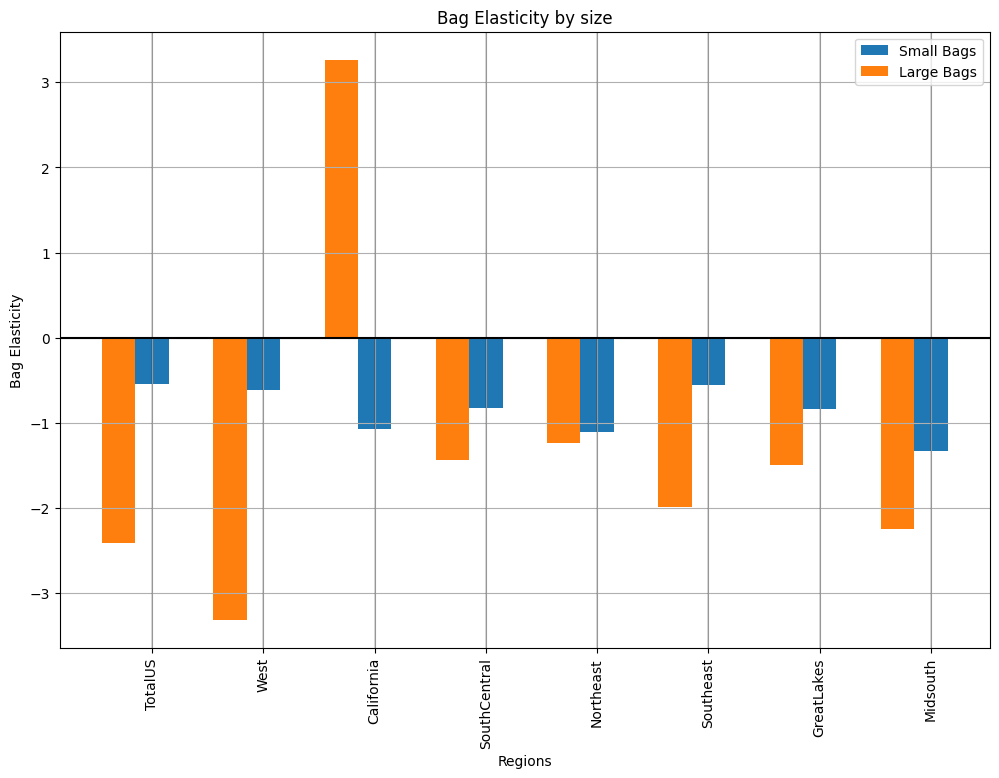

In [316]:
# Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
#Aqui estem prenent cada regio com equivalentment valida
# cambiar el 2018 no parece afectar los resultados
df_cp_elast = df_cp.copy()
df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'Date'])

region_largest= df_cp_elast.groupby('region')['Total Volume'].sum().nlargest(8).index
type_avocado = 'conventional'
labels = []

small_heights = []
Large_heights = []
XLarge_heights = []

for region in pd.unique(region_largest):
    # region = 'TotalUS'
    elast_region_bags = df_cp_elast[df_cp_elast['region'] == region].copy()
    elast_region_bags = elast_region_bags[elast_region_bags['type'] == type_avocado].copy()#.reset_index()
    
    # temp_market_size= elast_region['Total Volume'].sum()

    elast_region_bags['Small bag elasticity']= elast_region_bags['Small Bags'].pct_change() /  elast_region_bags['AveragePrice'].pct_change()
    elast_region_bags['Large bag elasticity']= elast_region_bags['Large Bags'].pct_change() /  elast_region_bags['AveragePrice'].pct_change()
    elast_region_bags['XLarge bag elasticity']= elast_region_bags['XLarge Bags'].pct_change() /  elast_region_bags['AveragePrice'].pct_change()
    # elast_region_bags['XLarge bag Variation']= elast_region_bags['AveragePrice'].pct_change()

    # # Els possibles valors entre infinit i menys infinit son ignorats per a un subset net
    elast_region_bags =elast_region_bags[-elast_region_bags['Small bag elasticity'].isin([-np.inf,np.inf])]
    elast_region_bags =elast_region_bags[-elast_region_bags['Large bag elasticity'].isin([-np.inf,np.inf])]
    elast_region_bags =elast_region_bags[-elast_region_bags['XLarge bag elasticity'].isin([-np.inf,np.inf])]

    elast_region_bags = elast_region_bags.reset_index()

    small_heights.append(elast_region_bags.loc[1:,'Small bag elasticity'].mean())
    Large_heights.append(elast_region_bags.loc[1:,'Large bag elasticity'].mean())
    XLarge_heights.append(elast_region_bags.loc[1:,'XLarge bag elasticity'].mean())
    labels.append(region)

    if region == 'SouthCentral':
        display(elast_region_bags.loc[10:14,:])# [elast_region_bags['XLarge bag elasticity'] > 200])
        print(elast_region_bags.describe())

fig, ax=plt.subplots(figsize= (12,8))

# Define the positions for the bars on the x-axis
x = np.arange(len(labels))
width = 0.3  # Width of the bars
distance = 0.3

bar1 = ax.bar(x , small_heights, width, label='Small Bags')
bar2 = ax.bar(x - distance , Large_heights, width, label='Large Bags')
#bar3 = ax.bar(x + distance, XLarge_heights, width, label='XLarge Bags')

# Labels and title
ax.set_xlabel('Regions')
ax.set_ylabel('Bag Elasticity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('Bag Elasticity by size')
plt.axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0

for x_value in x:
    plt.axvline(x_value, color='black', linewidth=0.2, linestyle='-') 
    
plt.xticks(rotation=90)
plt.grid()
# Show the plot
plt.show()

#### Repetir estudio, pero solo USA

In [317]:
df_USA= df_cp[df_cp['region'] == 'TotalUS'].copy()
df_USA= df_USA.sort_values(by=['Date'])
df_USA_org = df_USA[df_USA['type'] == 'organic'].copy()
df_USA_org['Elasticity'] = df_USA_org['Total Volume'].pct_change() /  df_USA_org['AveragePrice'].pct_change()
df_USA_org =df_USA_org[-df_USA_org['Elasticity'].isin([-np.inf,np.inf])].reset_index()
df_USA_org = df_USA_org.loc[1:,]


df_USA_conv = df_USA[df_USA['type'] == 'conventional'].copy()
df_USA_conv['Elasticity'] = df_USA_conv['Total Volume'].pct_change() /  df_USA_conv['AveragePrice'].pct_change()
df_USA_conv =df_USA_conv[-df_USA_conv['Elasticity'].isin([-np.inf,np.inf])].reset_index()
df_USA_conv = df_USA_conv.loc[1:,]

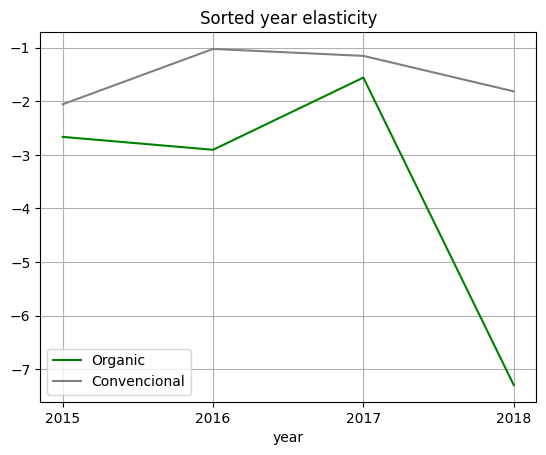

In [318]:
# Creem el group by adient
organic_year_USA = df_USA_org.groupby("year").agg({'Elasticity':"mean"})
conv_year_USA = df_USA_conv.groupby("year").agg({'Elasticity':"mean"})

#Plotejem
fig, ax = plt.subplots()
organic_year_USA.loc[:,'Elasticity'].plot(kind = 'line',ax= ax, color= 'green', label = 'Organic' )
conv_year_USA.loc[:,'Elasticity'].plot(kind = 'line',ax= ax, color= 'gray', label = 'Convencional' )
plt.legend()
ax.set_xticks(conv_year_USA.index)
ax.grid()
plt.title('Sorted year elasticity')
plt.show()

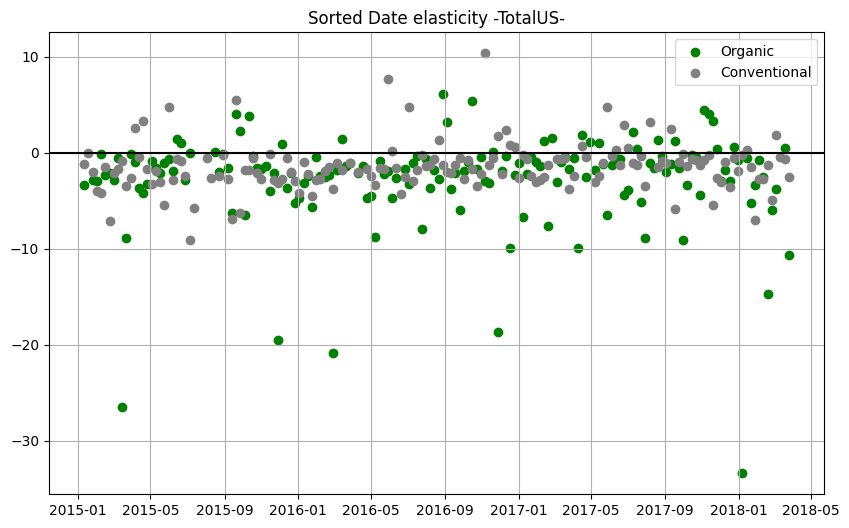

In [319]:
#Plotejem
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(df_USA_org['Date'],  df_USA_org['Elasticity'], color= 'green', label= 'Organic' )
plt.scatter(df_USA_conv['Date'],  df_USA_conv['Elasticity'], color= 'Gray', label= 'Conventional' )
# ax.set_xticks(conv_year_USA.index)
ax.axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0
ax.grid()
# plt.ylim(-10,10)
plt.legend()
plt.title('Sorted Date elasticity -TotalUS-')
plt.show()

In [320]:
# # Creacion de la variable elasticidad y eliminacion de valores no utiles
# df_cp_elast_bags = df_USA[df_USA['type']=='conventional'].copy().sort_values(by=['region', 'Date']).reset_index()

# df_cp_elast_bags['Small bag elasticity']= df_cp_elast_bags['Small Bags'].pct_change() /  df_cp_elast_bags['AveragePrice'].pct_change()
# df_cp_elast_bags['Large bag elasticity']= df_cp_elast_bags['Large Bags'].pct_change() /  df_cp_elast_bags['AveragePrice'].pct_change()
# df_cp_elast_bags['XLarge bag elasticity']= df_cp_elast_bags['XLarge Bags'].pct_change() /  df_cp_elast_bags['AveragePrice'].pct_change()

# # # Els possibles valors entre infinit i menys infinit son ignorats per a un subset net
# df_cp_elast_bags =df_cp_elast_bags[-df_cp_elast_bags['Small bag elasticity'].isin([-np.inf,np.inf])]
# df_cp_elast_bags =df_cp_elast_bags[-df_cp_elast_bags['Large bag elasticity'].isin([-np.inf,np.inf])]
# df_cp_elast_bags =df_cp_elast_bags[-df_cp_elast_bags['XLarge bag elasticity'].isin([-np.inf,np.inf])]

# df_cp_elast_bags = df_cp_elast_bags.loc[1:,:]

In [321]:
# bag_means = df_cp_elast_bags.loc[:,['Small bag elasticity','Large bag elasticity','XLarge bag elasticity']].mean()

# labels= ['Small bag elasticity','Large bag elasticity','XLarge bag elasticity']

# plt.bar(x=labels, height = bag_means, color = ('y', 'orange', 'r'))
# plt.grid()

### Analisis por cohortes

##### 1. Cohortes Basadas en Precios Promedios Trimestrales:

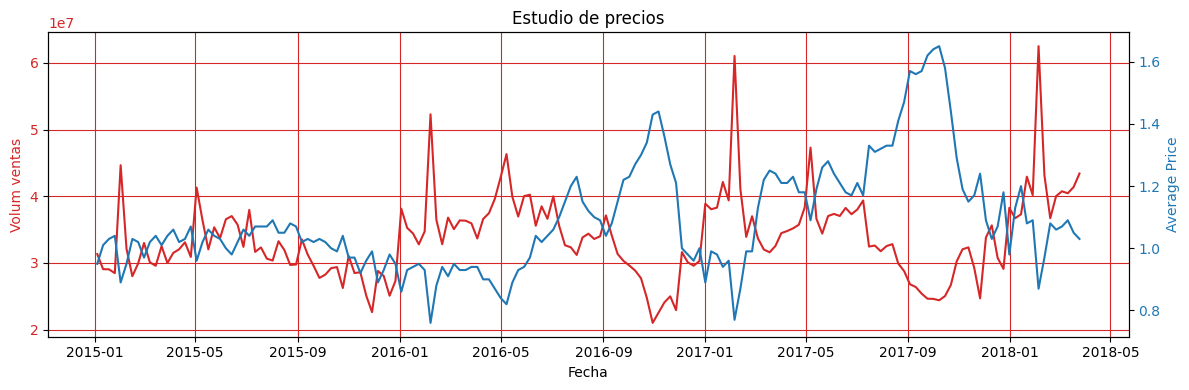

In [322]:
df_cp_cleaned = df_cp.copy()
df_USA = df_cp_cleaned[df_cp_cleaned['region']=='TotalUS'].copy()
df_USA = df_USA[df_USA['type']=='conventional']#.copy()
df_media = df_USA.groupby([pd.Grouper(key='Date', freq='QS')]).agg({'AveragePrice':'mean', 'Total Volume':'sum'}).reset_index()
df_media = df_USA.groupby(['Date']).agg({'AveragePrice':'mean', 'Total Volume':'sum'}).reset_index()
#df_media['Date offset'] = df_media['Date'] - pd.DateOffset(months=5)
# display(df_temp)

fig, ax1 = plt.subplots(figsize=(12,4))
plt.title('Estudio de precios')
color = 'tab:red'
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Volum ventas', color=color)
ax1.plot(df_media['Date'], df_media['Total Volume'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Average Price', color=color)  # we already handled the x-label with ax1
ax2.plot(df_media['Date'], df_media['AveragePrice'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
# plt.ylim(0, 5)
#ax2.grid(color=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(rotation = 90)
plt.show()

##### 2. Cohortes por Región y Fecha:

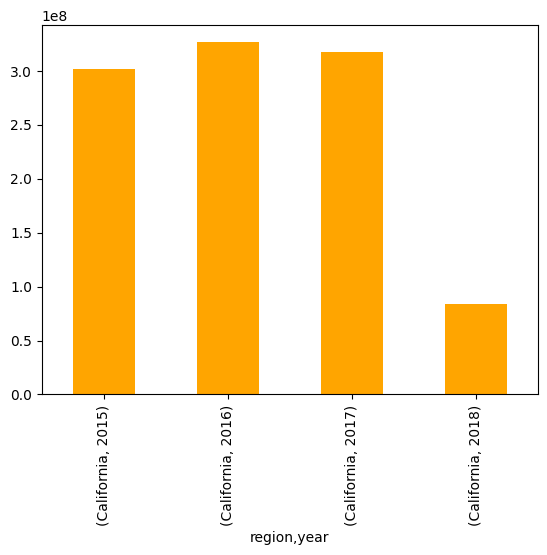

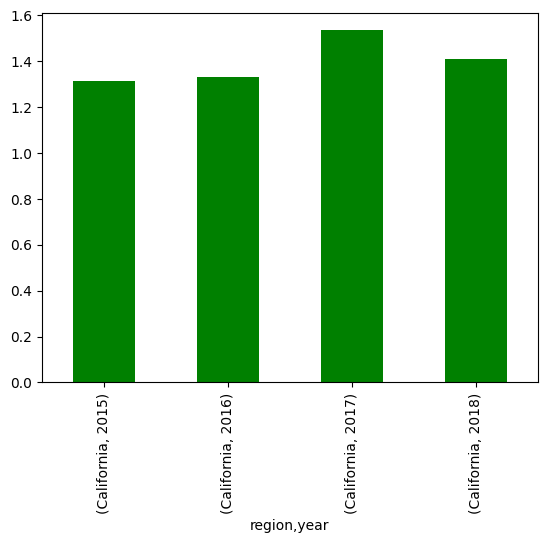

In [323]:
df_no_USA = df_cp_cleaned[df_cp_cleaned['region']=='California']
df_media = df_no_USA.groupby(['region', 'year']).agg({'Total Volume':'sum', 'AveragePrice':'mean'})#.reset_index()

df_media['Total Volume'].plot(kind='bar', label = 'Total Volume', color= 'orange')
plt.show()

df_media['AveragePrice'].plot(kind='bar', label = 'Average Price', color= 'green')
plt.show()

##### 3. Análisis de Cohortes en Función del Tipo de Bolsa:

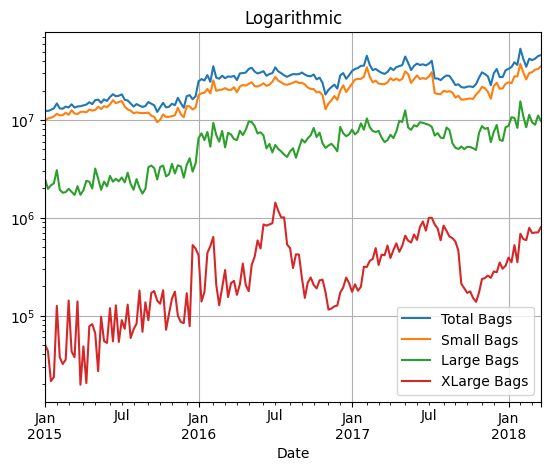

In [324]:
columnas_bags = ['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
# df_bag_temp = df_cp_cleaned[df_cp_cleaned['region']=='Philadelphia'].copy()
df_bag_temp = df_cp_cleaned.copy()
df_bag_temp= df_cp_cleaned.groupby('Date')['Total Bags'].sum()

fig, ax= plt.subplots()
for title_bag in columnas_bags: 
    df_bag_temp= df_cp_cleaned.groupby('Date')[title_bag].sum()
    df_bag_temp.plot(kind = 'line', ax=ax, label= title_bag)

plt.yscale('log')
plt.title('Logarithmic')
plt.grid()
plt.legend()
plt.show()

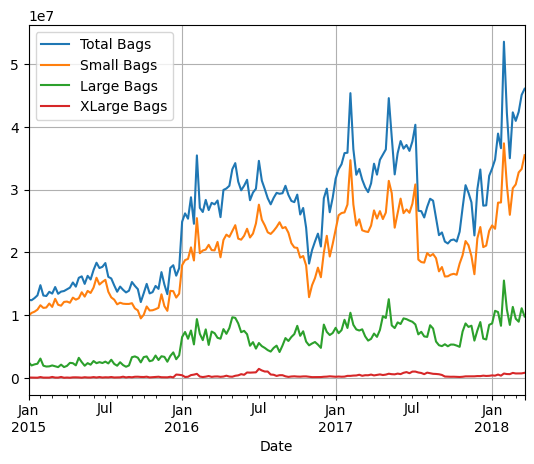

In [325]:
columnas_bags = ['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
fig, ax= plt.subplots()
for title_bag in columnas_bags:
    df_bag_temp= df_cp_cleaned.groupby('Date')[title_bag].sum()
    df_bag_temp.plot(kind = 'line', ax=ax, label= title_bag)

# plt.yscale('log')   
plt.grid()
plt.legend()
plt.show()

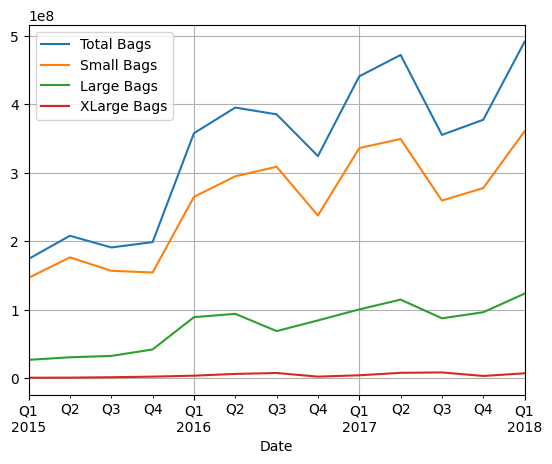

In [326]:
columnas_bags = ['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
fig, ax= plt.subplots()
for title_bag in columnas_bags:
    df_bag_temp= df_cp_cleaned.groupby([pd.Grouper(key='Date', freq='QS')])[title_bag].sum()
    df_bag_temp.plot(kind = 'line', ax=ax, label= title_bag)

# plt.yscale('log')   
plt.grid()
plt.legend()
plt.show()

##### 4. Cohortes de Clientes Basadas en Ventas:

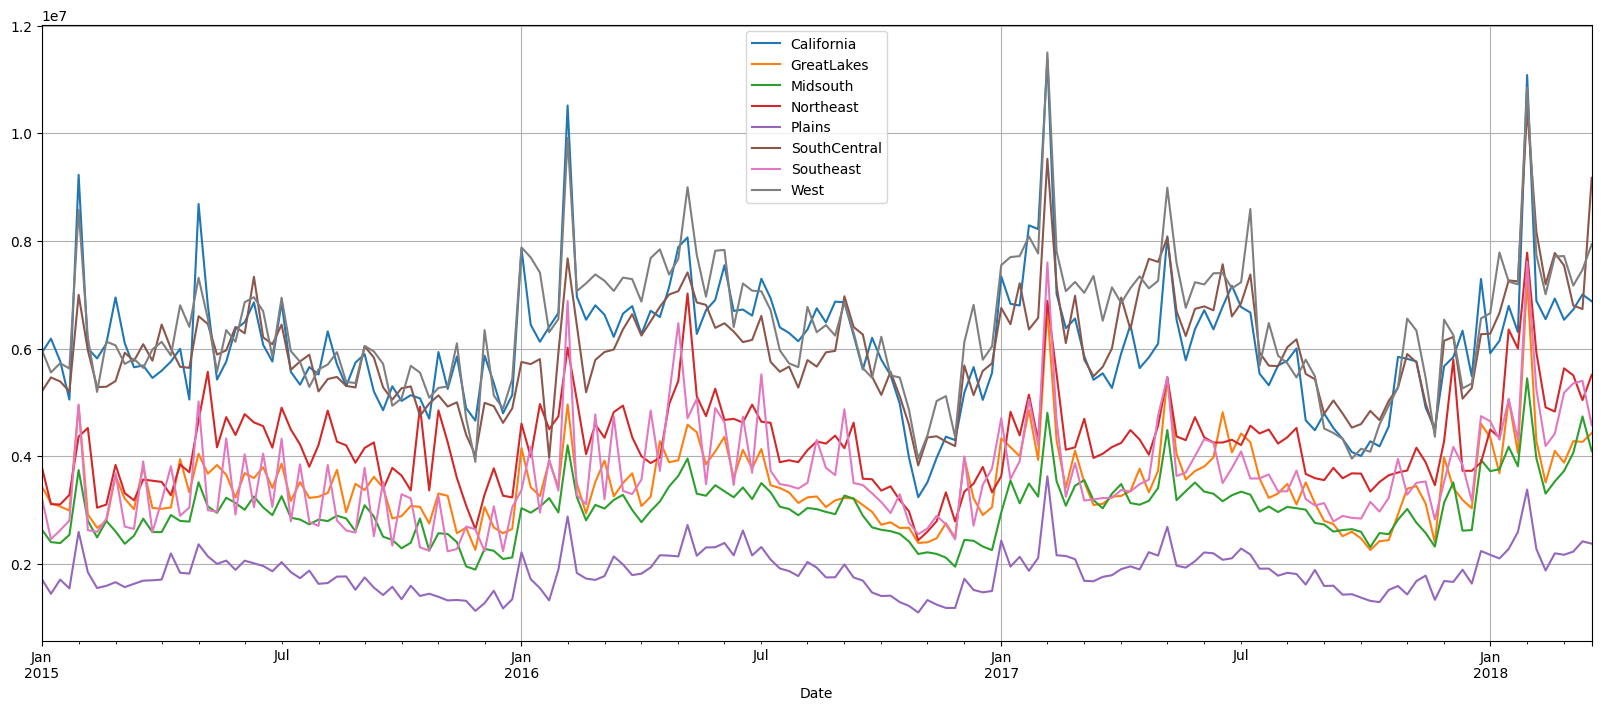

In [327]:
df_cleaned_great_regions = df_cp_cleaned[df_cp_cleaned['region_class']=='GreaterRegion']
# df_cleaned_great_regions = df_cleaned_great_regions[(df_cleaned_great_regions['Date']<'15-03-2018')&(df_cleaned_great_regions['Date']>'01-01-2018')]
great_regions = pd.unique(df_cleaned_great_regions['region'])

fig, ax= plt.subplots(figsize=(20,8))
for region in great_regions:
    df_temp_region = df_cleaned_great_regions[df_cleaned_great_regions['region'] ==region ]
    df_date_region= df_temp_region.groupby('Date')['Total Volume'].sum()
    df_date_region.plot(kind = 'line', ax=ax, label= region)

# plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

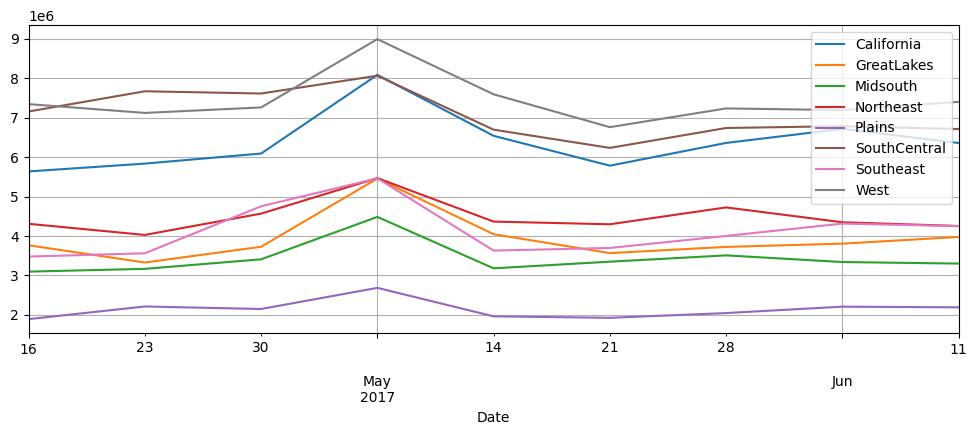

In [328]:
df_cleaned_great_regions = df_cp_cleaned[df_cp_cleaned['region_class']=='GreaterRegion']
df_cleaned_great_regions = df_cleaned_great_regions[(df_cleaned_great_regions['Date']<'2017-06-15')&(df_cleaned_great_regions['Date']>'2017-04-15')]
great_regions = pd.unique(df_cleaned_great_regions['region'])

fig, ax= plt.subplots(figsize=(12,4))
for region in great_regions:
    df_temp_region = df_cleaned_great_regions[df_cleaned_great_regions['region'] ==region ]
    df_date_region= df_temp_region.groupby('Date')['Total Volume'].sum()
    df_date_region.plot(kind = 'line', ax=ax, label= region)

# plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

##### 5. Evaluación de Retención de Ventas por Cohorte:

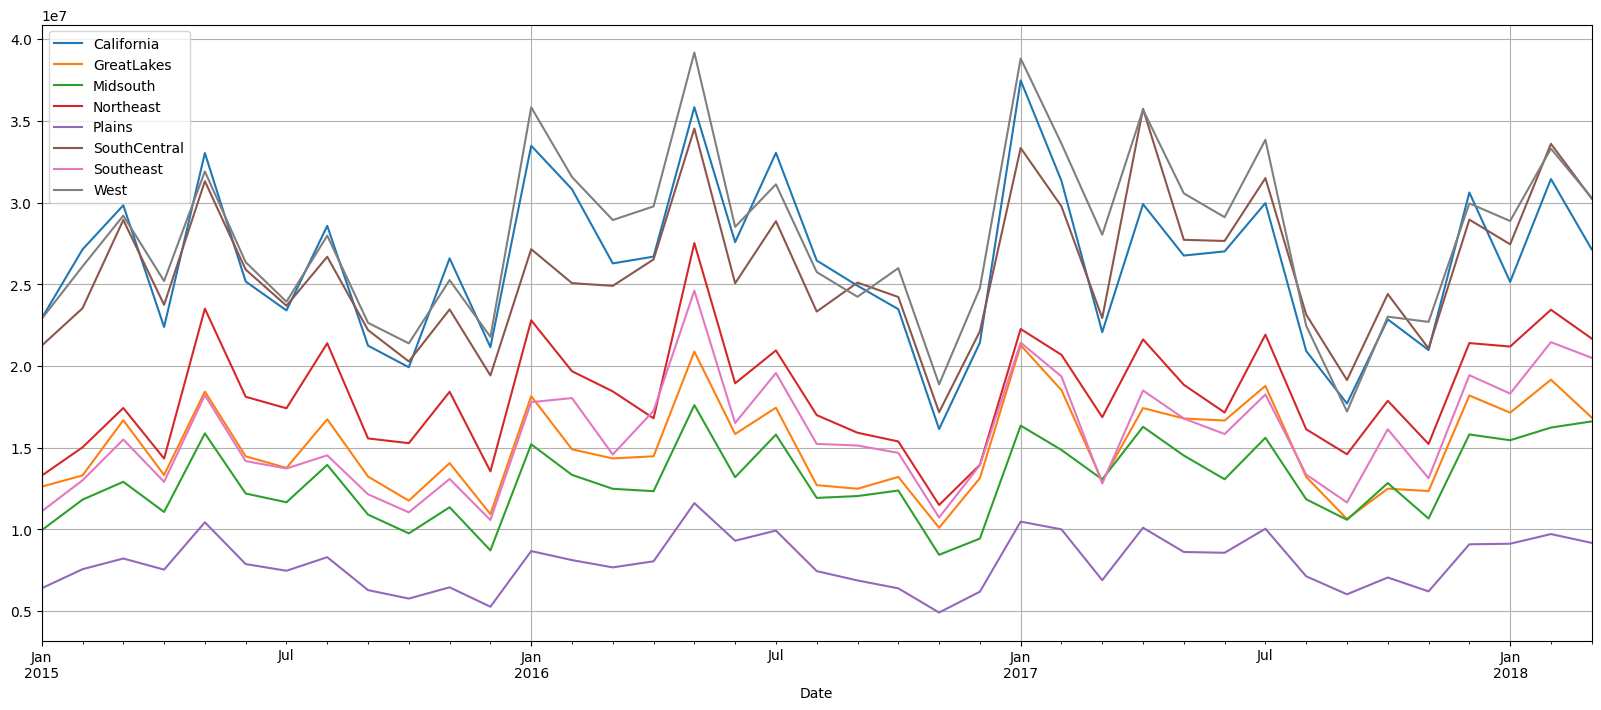

In [329]:
df_cleaned_great_regions = df_cp_cleaned[df_cp_cleaned['region_class']=='GreaterRegion']
# df_cleaned_great_regions = df_cleaned_great_regions[(df_cleaned_great_regions['Date']<'15-03-2018')&(df_cleaned_great_regions['Date']>'01-01-2018')]
great_regions = pd.unique(df_cleaned_great_regions['region'])

fig, ax= plt.subplots(figsize=(20,8))
for region in great_regions:
    df_temp_region = df_cleaned_great_regions[df_cleaned_great_regions['region'] ==region ]
    df_date_region= df_temp_region.groupby([pd.Grouper(key='Date', freq='MS')])['Total Volume'].sum()
    df_date_region.plot(kind = 'line', ax=ax, label= region)

# plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

#### Matriz de correlaciones de todas las variables según  apartado 5.6. En especial, precio medio y relación con diferentes calibres.

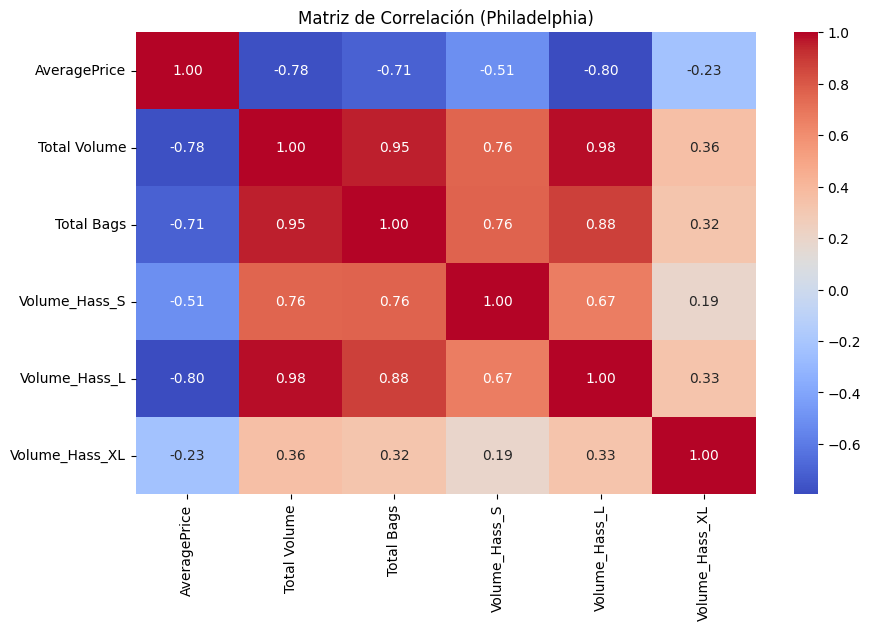

Variables altamente correlacionadas con otras: ['Total Volume', 'Total Bags', 'Volume_Hass_L']


In [330]:
df_corr_gen= df_cp.copy()
df_corr_gen = df_corr_gen[df_corr_gen['region']=='Philadelphia']
# df_corr_gen = df_corr_gen[(df_corr_gen['region_class']== 'City') | (df_corr_gen['region_class']== 'Region')]

corr_df= df_corr_gen[['AveragePrice', 'Total Volume', 'Total Bags' ,'Volume_Hass_S', 'Volume_Hass_L', 'Volume_Hass_XL']]
# Calcular la matriz de correlación
corr_matrix = corr_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación (Philadelphia)')
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

#### Dispersión entre variables claves según 5.2

In [331]:
df_local = df_cp.copy()
df_local= df_local[df_local['type']=='organic']
df_local= df_local[df_local['region']=='TotalUS']
df_local = df_local[df_local['AveragePrice']==1.0]
display(df_local)

index       Date  AveragePrice  Total Volume  Volume_Hass_S  \
11798  11798 2015-08-09           1.0      625259.0       170184.0   
11799  11799 2015-08-02           1.0      573873.0       164126.0   
11800  11800 2015-07-26           1.0      580826.0       169940.0   
11801  11801 2015-07-19           1.0      650389.0       159752.0   
11802  11802 2015-07-12           1.0      608845.0       178871.0   
11803  11803 2015-07-05           1.0      668233.0       205073.0   

       Volume_Hass_L  Volume_Hass_XL  Total Bags  Small Bags  Large Bags  \
11798       269330.0          6905.0    178838.0    126058.0     52779.0   
11799       263359.0          5115.0    141271.0     93120.0     48151.0   
11800       266249.0          4391.0    140244.0     71807.0     68436.0   
11801       317728.0          4758.0    168149.0     81667.0     86482.0   
11802       267353.0          5093.0    157526.0     80220.0     77305.0   
11803       304597.0          6251.0    152309.0     88261.0     64048.0   

       XLarge Bags     type  year   region region_class  Suma Volums  \
11798          0.0  organic  2015  TotalUS      TotalUS     446419.0   
11799          0.0  organic  2015  TotalUS      TotalUS     432600.0   
11800          0.0  organic  2015  TotalUS      TotalUS     440580.0   
11801          0.0  organic  2015  TotalUS      TotalUS     482238.0   
11802          0.0  organic  2015  TotalUS      TotalUS     451317.0   
11803          0.0  organic  2015  TotalUS      TotalUS     515921.0   

        Variacio RegionClass  
11798  28.602547     TotalUS  
11799  24.617468     TotalUS  
11800  24.145958     TotalUS  
11801  25.853912     TotalUS  
11802  25.873252     TotalUS  
11803  22.793247     TotalUS

* TODO ?

In [332]:
# df_local = df_cp.copy()
# df_local= df_local[df_local['type']=='conventional']

# # df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
# df_local_USA=df_local[df_local['region_class']=='TotalUS']

# fig, ax= plt.subplots(figsize=(10,6))

# # sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
# sns.regplot(data= df_local_USA , x=df_local_USA['Total Volume'], y=df_local_USA['AveragePrice'], order=1)#, line=True)
# plt.xscale('log')
# plt.grid()
# plt.title('Conventional')
# plt.figure()

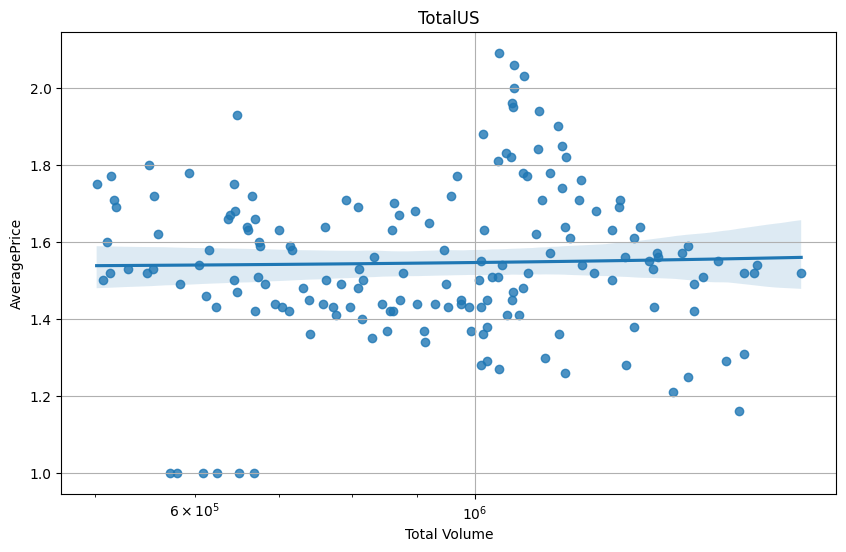

<Figure size 640x480 with 0 Axes>

In [333]:
df_local = df_cp.copy()
df_local= df_local[df_local['type']=='organic']

# df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
df_local_USA=df_local[df_local['region_class']=='TotalUS']

fig, ax= plt.subplots(figsize=(10,6))

# sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
sns.regplot(data= df_local_USA , x=df_local_USA['Total Volume'], y=df_local_USA['AveragePrice'], order=1)#, line=True)
plt.xscale('log')
plt.grid()
plt.title('TotalUS')
plt.figure()
plt.show()

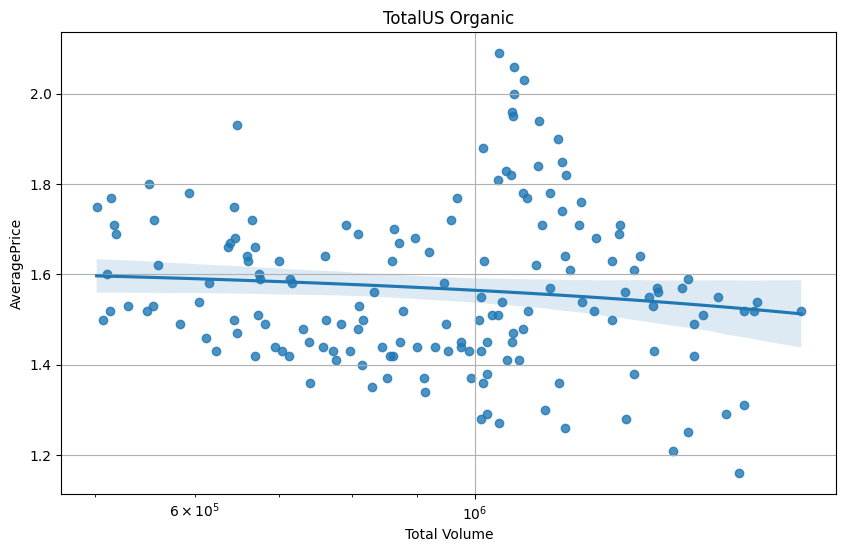

<Figure size 640x480 with 0 Axes>

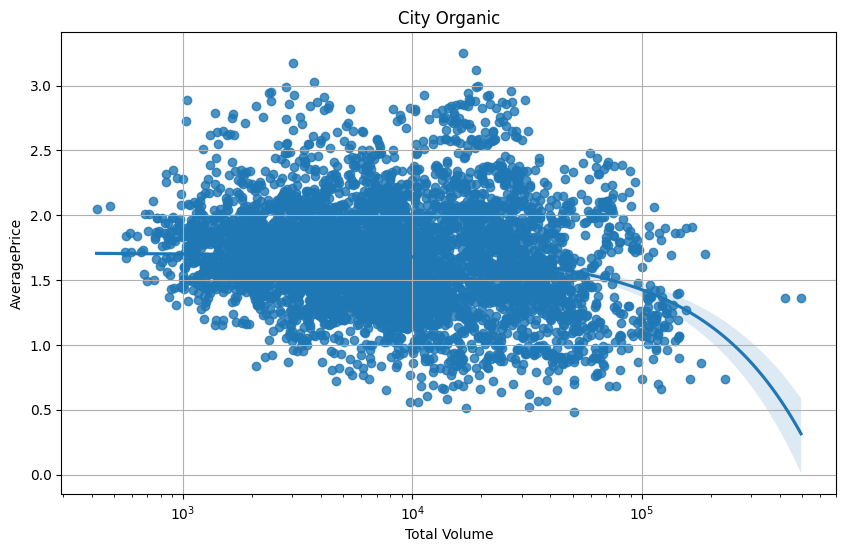

<Figure size 640x480 with 0 Axes>

In [334]:
df_local = df_cp.copy()
df_local= df_local[df_local['type']=='organic']

# df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
df_local_USA=df_local[df_local['region_class']=='TotalUS']
df_local_USA=df_local_USA[df_local_USA['AveragePrice']>1.1]

fig, ax= plt.subplots(figsize=(10,6))

# sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
sns.regplot(data= df_local_USA , x=df_local_USA['Total Volume'], y=df_local_USA['AveragePrice'], order=1)#, line=True)
plt.xscale('log')
plt.grid()
plt.title('TotalUS Organic')
plt.figure()
plt.show()

# df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
df_local_region=df_local[df_local['region_class']=='City']

fig, ax= plt.subplots(figsize=(10,6))

# sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
sns.regplot(data= df_local_region , x=df_local_region['Total Volume'], y=df_local_region['AveragePrice'], order=1)#, line=True)
plt.xscale('log')
plt.title('City Organic')
plt.grid()
plt.figure()
plt.show()

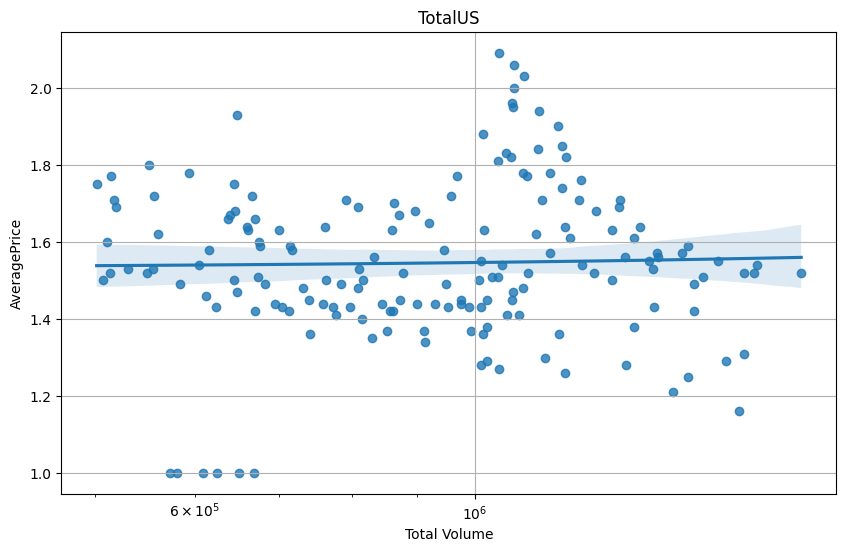

<Figure size 640x480 with 0 Axes>

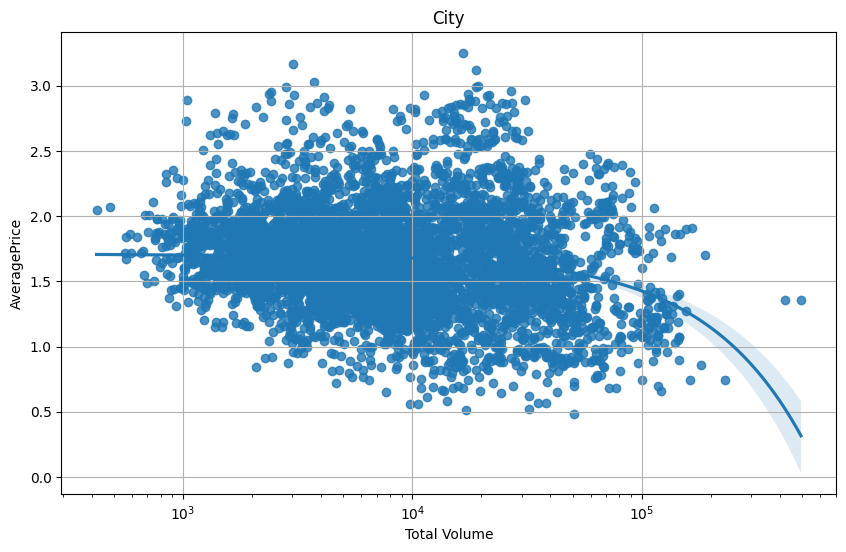

<Figure size 640x480 with 0 Axes>

In [335]:
df_local = df_cp.copy()
df_local= df_local[df_local['type']=='organic']

# df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
df_local_USA=df_local[df_local['region_class']=='TotalUS']

fig, ax= plt.subplots(figsize=(10,6))

# sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
sns.regplot(data= df_local_USA , x=df_local_USA['Total Volume'], y=df_local_USA['AveragePrice'], order=1)#, line=True)
plt.xscale('log')
plt.grid()
plt.title('TotalUS')
plt.figure()
plt.show()

# df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
df_local_region=df_local[df_local['region_class']=='City']

fig, ax= plt.subplots(figsize=(10,6))

# sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
sns.regplot(data= df_local_region , x=df_local_region['Total Volume'], y=df_local_region['AveragePrice'], order=1)#, line=True)
plt.xscale('log')
plt.title('City')
plt.grid()
plt.figure()
plt.show()

# REGRESIONES Y PROYECCIONES

## Ejemplo De Modelo Final

In [336]:
df_local = df_cp.copy()
df_local = df_local.sort_values(by=['region', 'type', 'year'])
display(df_local)

index       Date  AveragePrice  Total Volume  Volume_Hass_S  \
0          0 2015-12-27          1.33      64236.62        1036.74   
1          1 2015-12-20          1.35      54876.98         674.28   
2          2 2015-12-13          0.93     118220.22         794.70   
3          3 2015-12-06          1.08      78992.15        1132.00   
4          4 2015-11-29          1.28      51039.60         941.48   
...      ...        ...           ...           ...            ...   
18244  18244 2018-02-04          1.63      17074.83        2046.96   
18245  18245 2018-01-28          1.71      13888.04        1191.70   
18246  18246 2018-01-21          1.87      13766.76        1191.92   
18247  18247 2018-01-14          1.93      16205.22        1527.63   
18248  18248 2018-01-07          1.62      17489.58        2894.77   

       Volume_Hass_L  Volume_Hass_XL  Total Bags  Small Bags  Large Bags  \
0           54454.85           48.16     8696.87     8603.62       93.25   
1           44638.81           58.33     9505.56     9408.07       97.49   
2          109149.67          130.50     8145.35     8042.21      103.14   
3           71976.41           72.58     5811.16     5677.40      133.76   
4           43838.39           75.78     6183.95     5986.26      197.69   
...              ...             ...         ...         ...         ...   
18244        1529.20            0.00    13498.67    13066.82      431.85   
18245        3431.50            0.00     9264.84     8940.04      324.80   
18246        2452.79          727.94     9394.11     9351.80       42.31   
18247        2981.04          727.01    10969.54    10919.54       50.00   
18248        2356.13          224.53    12014.15    11988.14       26.01   

       XLarge Bags          type  year            region region_class  \
0              0.0  conventional  2015            Albany         City   
1              0.0  conventional  2015            Albany         City   
2              0.0  conventional  2015            Albany         City   
3              0.0  conventional  2015            Albany         City   
4              0.0  conventional  2015            Albany         City   
...            ...           ...   ...               ...          ...   
18244          0.0       organic  2018  WestTexNewMexico       Region   
18245          0.0       organic  2018  WestTexNewMexico       Region   
18246          0.0       organic  2018  WestTexNewMexico       Region   
18247          0.0       organic  2018  WestTexNewMexico       Region   
18248          0.0       organic  2018  WestTexNewMexico       Region   

       Suma Volums   Variacio RegionClass  
0         55539.75  13.538804        City  
1         45371.42  17.321580        City  
2        110074.87   6.889980        City  
3         73180.99   7.356630        City  
4         44855.65  12.115984        City  
...            ...        ...         ...  
18244      3576.16  79.055955      Region  
18245      4623.20  66.710925      Region  
18246      4372.65  68.237625      Region  
18247      5235.68  67.691398      Region  
18248      5475.43  68.693188      Region  

[18249 rows x 18 columns]

#### West: Primer ejemplo del modelo Final que vamos a mostrar. Incluye un plotting avanzado y las variables X más importantes

X_poly: 270 [[ 1.00000000e+00  6.03638388e-01  2.01500000e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00 -9.78558644e-01  2.01600000e+03 ...  2.20900000e+03
   4.70000000e+01  1.00000000e+00]
 [ 1.00000000e+00  9.72191719e-01  2.01700000e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 1.00000000e+00  5.75595866e-01  2.01700000e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00 -9.71582571e-01  2.01600000e+03 ...  4.00000000e+00
   2.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.35626648e+00  2.01600000e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]

Comparación de los primeros 10 valores entre el valor predicho y el valor real:
    Valor Real  Valor Predicho  Error Porcentual
0        1.04        1.139885         -9.604288
1        1.41        1.438219         -2.001369
2        1.83        1.799041          1.691744
3        1.01        0.940126          6.918212
4        1.37        1.346056 

/tmp/ipykernel_789/2346379670.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_plot.loc[:,'Date'] = X_to_plot.apply(lambda x: datetime.datetime.strptime(str(int(x['year'])) +'-W'+ str(int(x['n_week'])) + '-1', "%Y-W%W-%w"), axis=1)


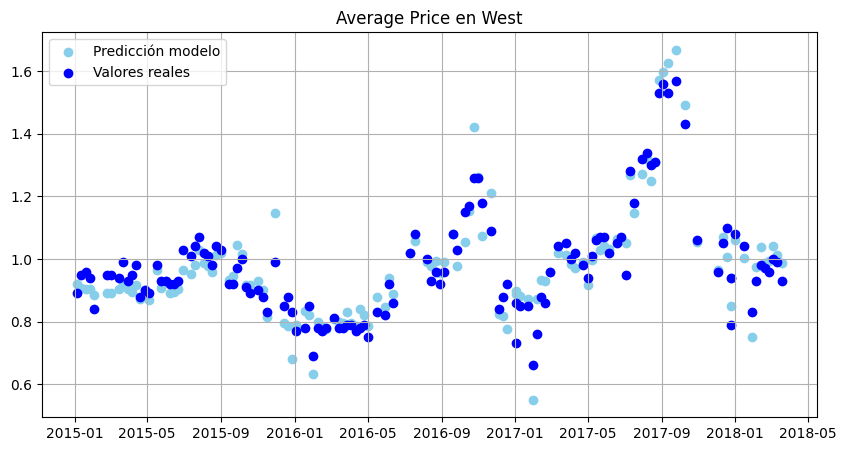

In [337]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import datetime

df_local = df_cp.copy()

df_local=df_local[df_local['region']=='West']

bool_org= {'organic':1, 'conventional':0}

df_local['Month'] = df_local['Date'].dt.to_period('M')
df_local['Quarter'] = df_local['Date'].dt.to_period('Q')
df_local['n_week'] = df_local['Date'].dt.isocalendar().week#.dt.to_period('W').strftime('%V')
df_local['Quarter Month'] = df_local['Month'].map(lambda x: (x.month - 1) % 3 + 1 )
df_local['n_Quarter'] = df_local['Month'].map(lambda date: (date.month - 1) // 3 + 1)
df_local['type_Bool'] = df_local['type'].map(bool_org)

df_local['Standard Volume'] = (df_local['Total Volume'] - df_local['Total Volume'].mean()) /df_local['Total Volume'].std()
df_local['ST_Volume_Hass_S'] = (df_local['Volume_Hass_S'] - df_local['Volume_Hass_S'].mean()) /df_local['Volume_Hass_S'].std()
df_local['ST_Volume_Hass_L'] = (df_local['Volume_Hass_L'] - df_local['Volume_Hass_L'].mean()) /df_local['Volume_Hass_L'].std()
df_local['ST_Volume_Hass_XL'] = (df_local['Volume_Hass_XL'] - df_local['Volume_Hass_XL'].mean()) /df_local['Volume_Hass_XL'].std()
df_local['Standard Bags'] = (df_local['Total Bags'] - df_local['Total Bags'].mean()) /df_local['Total Bags'].std()

# display(df_local)
Variables = ['Standard Volume', 'year','n_week', 'type_Bool'] #,,,  , 'ST_Volume_Hass_XL',  'ST_Volume_Hass_S', 'ST_Volume_Hass_L' , 'Standard Bags', 'n_Quarter'
# group_fit = df_fit.groupby('Quarter').agg({'AveragePrice':'mean', 'Total Volume':'mean' }).reset_index()
X= df_local[Variables]
Y= df_local['AveragePrice']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

###########
# Aplicar un modelo de regresión lineal para interpolar
poly_features = PolynomialFeatures(degree=3)
poly_model = LinearRegression()

X_poly = poly_features.fit_transform(X_train)
print(f"X_poly: {len(X_poly)} {X_poly}")
poly_model.fit(X_poly, y_train)
y_pred_poly_train = poly_model.predict(X_poly)

X_test_poly= poly_features.fit_transform(X_test)
y_pred_poly_test = poly_model.predict(X_test_poly)

y_pred_poly_train = poly_model.predict(X_poly)

# Comparar los primeros 10 valores entre el valor predicho y el valor real
comparison_df = pd.DataFrame({
    'Valor Real': y_test.head(10).values,
    'Valor Predicho': y_pred_poly_test[:10]
})

# Calcular el error porcentual
comparison_df['Error Porcentual'] = ((comparison_df['Valor Real'] - comparison_df['Valor Predicho']) / comparison_df['Valor Real']) * 100

print("\nComparación de los primeros 10 valores entre el valor predicho y el valor real:\n", comparison_df)


# Calcular el error cuadrático medio (MSE) para evaluar el modelo
mse = mean_squared_error(y_test, y_pred_poly_test)
print(f"\nError cuadrático medio (MSE) del modelo: {mse:.4f}")


for i in range(0, len(Variables)):
    
    print(f'El coeficiente {Variables[i]}\t \t: {poly_model.coef_[i]}')

# Calcular el valor R²
r2_test = r2_score(y_test, y_pred_poly_test)
r2_train = r2_score(y_train, y_pred_poly_train)

print(f"\nValor R² del modelo: {r2_test:.6f}")
print(f"\nLa diferencia entre los Valores R² del modelo: {r2_train- r2_test:.6f}")



#############################################################################################################
# Plotting


fig, ax= plt.subplots(figsize= (10,5))

X_to_plot = X_train[X_train['type_Bool']==0]
X_to_plot.loc[:,'Date'] = X_to_plot.apply(lambda x: datetime.datetime.strptime(str(int(x['year'])) +'-W'+ str(int(x['n_week'])) + '-1', "%Y-W%W-%w"), axis=1)


y_pred_plot = y_pred_poly_train[X_train['type_Bool']==0]
Y_to_plot = y_train[X_train['type_Bool']==0]



plt.scatter(x = X_to_plot['Date'], y= y_pred_plot, color= 'Skyblue', label = 'Predicción modelo')
plt.scatter(x = X_to_plot['Date'], y= Y_to_plot, color= 'blue',  label = 'Valores reales')
plt.title("Average Price en West")
plt.legend()
plt.grid()
plt.show()
# print(X_train, y_pred_poly_train)

## Comparación de módelos

In [338]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import datetime
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import avocado_manager as av



color_orga ='green'; color_conv ='grey'; color_total ='blue'
av.init()
df_cp = av.df("df_cp")


df_local = df_cp.copy()

bool_org= {'organic':1, 'conventional':0}

df_local['Month'] = df_local['Date'].dt.to_period('M')
df_local['Quarter'] = df_local['Date'].dt.to_period('Q')
df_local['n_week'] = df_local['Date'].dt.isocalendar().week#.dt.to_period('W').strftime('%V')
df_local['Quarter Month'] = df_local['Month'].map(lambda x: (x.month - 1) % 3 + 1 )
df_local['n_Quarter'] = df_local['Month'].map(lambda date: (date.month - 1) // 3 + 1)
df_local['type_Bool'] = df_local['type'].map(bool_org)

df_local['Standard Volume'] = (df_local['Total Volume'] - df_local['Total Volume'].mean()) /df_local['Total Volume'].std()
df_local['ST_Volume_Hass_S'] = (df_local['Volume_Hass_S'] - df_local['Volume_Hass_S'].mean()) /df_local['Volume_Hass_S'].std()
df_local['ST_Volume_Hass_L'] = (df_local['Volume_Hass_L'] - df_local['Volume_Hass_L'].mean()) /df_local['Volume_Hass_L'].std()
df_local['ST_Volume_Hass_XL'] = (df_local['Volume_Hass_XL'] - df_local['Volume_Hass_XL'].mean()) /df_local['Volume_Hass_XL'].std()
df_local['Standard Bags'] = (df_local['Total Bags'] - df_local['Total Bags'].mean()) /df_local['Total Bags'].std()

In [339]:
diccionario_regressiones = {'Region' : [], 
                            'Variables' : [], 
                            'R_2' : [], 
                            'Var_R' : [] , 
                            'Random_seed' : []}
                           # 'TotalUS comp' : []}

In [340]:
import os
Variables = ['Standard Volume', 'year','n_week', 'type_Bool'] #,,,  , , 'ST_Volume_Hass_XL',  'ST_Volume_Hass_S', 'ST_Volume_Hass_L' , 'Standard Bags', 'n_Quarter'
if os.path.exists("Resultados_df_30_iteracions.csv"):
    Resultados_df = pd.read_csv("Resultados_df_30_iteracions.csv")
else:
    for region in pd.unique(df_local['region'] ):

        for random_seed in range(0,30): # 30 para la presentacion si queremos mosrt

            df_temp_region = df_local[df_local['region'] == region]
        
            X= df_temp_region[Variables]
            Y= df_temp_region['AveragePrice']
        
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=random_seed)
        
            
        
            ###########
            # Aplicar un modelo de regresión lineal para interpolar
            poly_features = PolynomialFeatures(degree=9)
            poly_model = LinearRegression()
            
            X_poly = poly_features.fit_transform(X_train)
            poly_model.fit(X_poly, y_train)
            y_pred_poly_train = poly_model.predict(X_poly)
            
            X_test_poly= poly_features.fit_transform(X_test)
            y_pred_poly_test = poly_model.predict(X_test_poly)
            
            y_pred_poly_train = poly_model.predict(X_poly)
            
            
            # Calcular el valor R²
            r2_test = r2_score(y_test, y_pred_poly_test)
            r2_train = r2_score(y_train, y_pred_poly_train)
        
        
        
            # ########USA
            # # Calcular el valor R²
        
            # df_temp_USA = df_local[df_local['region'] == 'TotalUS']
        
            # X_USA= df_temp_USA[Variables]
            # Y_USA= df_temp_USA['AveragePrice']   
        
            # X_USA_train, X_USA_test, y_USA_train, y_USA_test = train_test_split(X_USA, Y_USA, test_size=0.2, random_state=random_seed)
            # X_poly_USA_train = poly_features.fit_transform(X_USA_train)
            
            # y_pred_USA_train = poly_model.predict(X_poly_USA_train)
            # r2_USA_train = r2_score(y_USA_train, y_pred_USA_train)
        
        
                # Calcular el valor R²
            r2_test = r2_score(y_test, y_pred_poly_test)
            r2_train = r2_score(y_train, y_pred_poly_train)
        
            diccionario_regressiones['Region'].append(region)
            diccionario_regressiones['Variables'].append(Variables)
            diccionario_regressiones['R_2'].append(r2_test)
            diccionario_regressiones['Var_R'].append(abs(r2_train - r2_test))
            diccionario_regressiones['Random_seed'].append(random_seed)

    Resultados_df= pd.DataFrame(diccionario_regressiones)
    Resultados_df.to_csv("Resultados_df_30_iteracions.csv")

best_regions = Resultados_df.groupby('Region')['R_2'].max()

display(Resultados_df[Resultados_df['Region'] == 'California'].sort_values(by = 'R_2', ascending = False))

Empty DataFrame
Columns: [Unnamed: 0, Region, Variables, R_2, Var_R, Random_seed]
Index: []

## Modelo de predicción

### Inicializacion

In [341]:
from sklearn import preprocessing
import pandas as pd
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
region_classification = av.region_classification

### Modelo Predicción variables independientes (Total Volume)

### Entrenamiento modelo Total Volume

In [342]:
# Para poder predecir el average price en un periodo que no conocemos, 
# Necesitamos predecir previamente el volúmen de venta o Total Volume
# Este modelo sera por una sola región, Californai

#df = pd.read_csv("avocado.csv")
#df_cp = df.copy()
#df_cp['Date'] = pd.to_datetime(df_cp['Date'])
# df_cp['region_class']= df_cp['region'].map(region_classification)

# df_cp = df_cp.rename(columns={df.columns[0]: 'Col_0'}) # Primera columna sin titulo, potencialmente eliminable
# df_cp = df_cp.rename(columns={'4046': 'Volume_Hass_S'}) # Etiquetas mas descritivas
# df_cp = df_cp.rename(columns={'4225': 'Volume_Hass_L'})
# df_cp = df_cp.rename(columns={'4770': 'Volume_Hass_XL'})

av.init()
dp_cp = av.df("df_cp")


df_modelo_volume= df_cp.copy()
# df_modelo_volume= df_modelo_volume[df_modelo_volume['region'] == 'California']

bool_org= {'organic':1, 'conventional':0}

df_modelo_volume['Month'] = df_modelo_volume['Date'].dt.to_period('M')
df_modelo_volume['Quarter'] = df_modelo_volume['Date'].dt.to_period('Q')
df_modelo_volume['n_week'] = df_modelo_volume['Date'].dt.isocalendar().week#.dt.to_period('W').strftime('%V')
df_modelo_volume['Quarter Month'] = df_modelo_volume['Month'].map(lambda x: (x.month - 1) % 3 + 1 )
df_modelo_volume['n_Quarter'] = df_modelo_volume['Month'].map(lambda date: (date.month - 1) // 3 + 1)
df_modelo_volume['type_Bool'] = df_modelo_volume['type'].map(bool_org)


In [343]:
# Creación de modelo total Volume

Variables_vol = ['year','n_week', 'type_Bool']

df_temp_region = df_modelo_volume[df_modelo_volume['region'] == 'California']


X_Volume= df_temp_region[Variables_vol]
Y_Volume= df_temp_region['Total Volume']

X_train_vol, X_test_vol, y_train_vol, y_test_vol = train_test_split(X_Volume, Y_Volume, test_size=0.1, random_state=42) # TODO escoger random seed

###########
# Training the volume prediction model
vol_poly_features = PolynomialFeatures(degree=7)
vol_poly_model = LinearRegression()

X_poly_train_vol = vol_poly_features.fit_transform(X_train_vol)
vol_poly_model.fit(X_poly_train_vol, y_train_vol)
y_pred_vol_train = vol_poly_model.predict(X_poly_train_vol)

X_poly_test_vol= vol_poly_features.fit_transform(X_test_vol)
y_pred_vol_test = vol_poly_model.predict(X_poly_test_vol)

# Calcular el valor R²
r2_test = r2_score(y_test_vol, y_pred_vol_test)
r2_train = r2_score(y_train_vol, y_pred_vol_train)

print(f"\nValor R² del modelo: {r2_test:.6f}")
print(f"\nLa diferencia entre los Valores R² del modelo: {r2_train- r2_test:.6f}")



Valor R² del modelo: 0.967640

La diferencia entre los Valores R² del modelo: -0.007140


### Visualización modelo total Volume

* En este apartado visualizaremos lso resultados del modelo de total Volume. En este caso como las variables independientes son únicamente temporales es muy dificil poder obtener un valor suficientemente certero. Aun asi esta estimación sera suficiente por el momento.


/tmp/ipykernel_789/2484599523.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_plot.loc[:,'Date'] = X_to_plot.apply(lambda x: datetime.datetime.strptime(str(int(x['year'])) +'-W'+ str(int(x['n_week'])) + '-1', "%Y-W%W-%w"), axis=1)


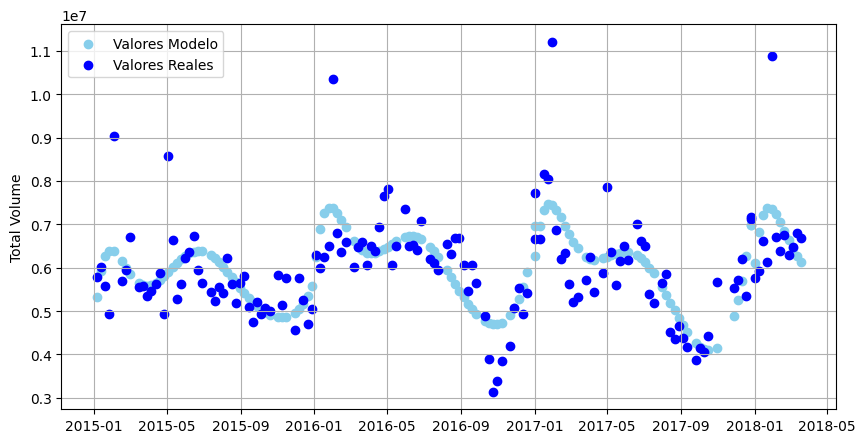

In [344]:
# Visualcización del modelo de total Volume
fig, ax= plt.subplots(figsize= (10,5))

tipo_aguacate_plot = 0

X_to_plot = X_train_vol[X_train_vol['type_Bool']==tipo_aguacate_plot]
X_to_plot.loc[:,'Date'] = X_to_plot.apply(lambda x: datetime.datetime.strptime(str(int(x['year'])) +'-W'+ str(int(x['n_week'])) + '-1', "%Y-W%W-%w"), axis=1)


y_pred_plot = y_pred_vol_train[X_train_vol['type_Bool']==tipo_aguacate_plot]
Y_to_plot = y_train_vol[X_train_vol['type_Bool']==tipo_aguacate_plot]

plt.scatter(x = X_to_plot['Date'], y= y_pred_plot, color= 'Skyblue', label= 'Valores Modelo')
plt.scatter(x = X_to_plot['Date'], y= Y_to_plot, color= 'blue', label= 'Valores Reales')
plt.ylabel('Total Volume')
plt.grid()
plt.legend()
plt.show()

### Prediccion Total Volume

In [345]:
#df_temp_region

X_for_vol = pd.DataFrame()

# Number of dates you want in the list
length_prediction = 200

#start_date = df_temp_region['Date'].max()#.min()
start_date = datetime.datetime.strptime( '2015-01-01', '%Y-%m-%d')#.timestamp()#.date()#'2018-01-01'

#print(type(start_date))
# start_date = datetime.datetime(01,01,2018)
interval = datetime.timedelta(days=7)

# Generate X values needed for prediction
X_for_vol['Date'] = pd.DataFrame([start_date + i * interval for i in range(length_prediction)])

X_for_vol['n_week'] = X_for_vol['Date'].dt.isocalendar().week
X_for_vol['year'] = X_for_vol['Date'].dt.year
X_for_vol['type_Bool'] = 0

X_for_vol = X_for_vol[Variables_vol]
#X_for_vol


In [346]:
X_poly_for_vol= vol_poly_features.fit_transform(X_for_vol)
vol_prediction = vol_poly_model.predict(X_poly_for_vol)

### Visualizacion predicciones total Volume

/tmp/ipykernel_789/1056579679.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_plot.loc[:,'Date'] = X_to_plot.apply(lambda x: datetime.datetime.strptime(str(int(x['year'])) +'-W'+ str(int(x['n_week'])) + '-1', "%Y-W%W-%w"), axis=1)


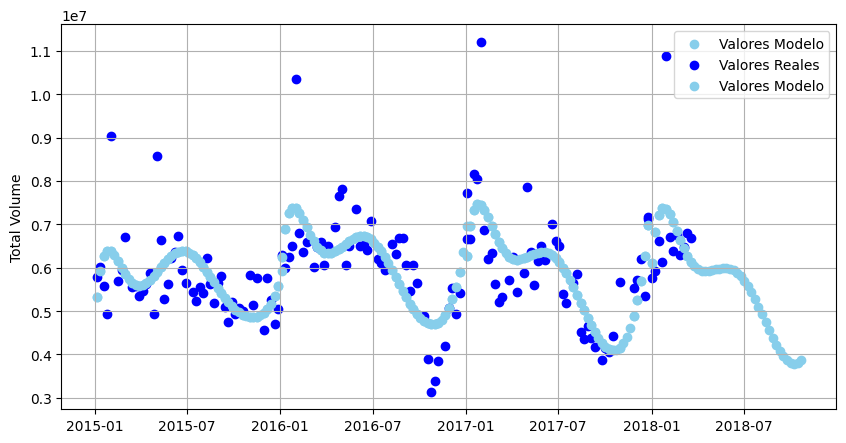

In [347]:
X_for_vol_temp = X_for_vol.copy()

fig, ax= plt.subplots(figsize= (10,5))

tipo_aguacate_plot = 0

X_to_plot = X_train_vol[X_train_vol['type_Bool']==tipo_aguacate_plot]
X_to_plot.loc[:,'Date'] = X_to_plot.apply(lambda x: datetime.datetime.strptime(str(int(x['year'])) +'-W'+ str(int(x['n_week'])) + '-1', "%Y-W%W-%w"), axis=1)

X_for_vol_temp.loc[:,'Date'] = X_for_vol_temp.apply(lambda x: datetime.datetime.strptime(str(int(x['year'])) +'-W'+ str(int(x['n_week'])) + '-1', "%Y-W%W-%w"), axis=1)

y_pred_plot = y_pred_vol_train[X_train_vol['type_Bool']==tipo_aguacate_plot]
Y_to_plot = y_train_vol[X_train_vol['type_Bool']==tipo_aguacate_plot]

plt.scatter(x = X_to_plot['Date'], y= y_pred_plot, color= 'Skyblue', label= 'Valores Modelo')
plt.scatter(x = X_to_plot['Date'], y= Y_to_plot, color= 'blue', label= 'Valores Reales')
plt.scatter(x = X_for_vol_temp['Date'], y= vol_prediction, color= 'Skyblue', label= 'Valores Modelo')
plt.ylabel('Total Volume')
plt.grid()
plt.legend()
plt.show()


## Creación Modelo Variable dependiente

In [348]:
#df = pd.read_csv("avocado.csv")
#df_cp = df.copy()
#df_cp['Date'] = pd.to_datetime(df_cp['Date'])

#df_cp['region_class']= df_cp['region'].map(region_classification)

#df_cp = df_cp.rename(columns={df.columns[0]: 'Col_0'}) # Primera columna sin titulo, potencialmente eliminable
#df_cp = df_cp.rename(columns={'4046': 'Volume_Hass_S'}) # Etiquetas mas descritivas
##df_cp = df_cp.rename(columns={'4225': 'Volume_Hass_L'})
#df_cp = df_cp.rename(columns={'4770': 'Volume_Hass_XL'})

av.init()
dp_cp = av.df("df_cp")


df_modelo_avprice_total= df_cp.copy()
# df_modelo_volume= df_modelo_volume[df_modelo_volume['region'] == 'California']

bool_org= {'organic':1, 'conventional':0}

df_modelo_avprice_total['Month'] = df_modelo_avprice_total['Date'].dt.to_period('M')
df_modelo_avprice_total['Quarter'] = df_modelo_avprice_total['Date'].dt.to_period('Q')
df_modelo_avprice_total['n_week'] = df_modelo_avprice_total['Date'].dt.isocalendar().week#.dt.to_period('W').strftime('%V')
df_modelo_avprice_total['Quarter Month'] = df_modelo_avprice_total['Month'].map(lambda x: (x.month - 1) % 3 + 1 )
df_modelo_avprice_total['n_Quarter'] = df_modelo_avprice_total['Month'].map(lambda date: (date.month - 1) // 3 + 1)
df_modelo_avprice_total['type_Bool'] = df_modelo_avprice_total['type'].map(bool_org)
df_modelo_avprice_total['Standard Volume'] = (df_modelo_avprice_total['Total Volume'] - df_modelo_avprice_total['Total Volume'].mean()) /df_modelo_avprice_total['Total Volume'].std()

#print(df_modelo_avprice['Total Volume'].mean() , df_modelo_avprice['Total Volume'].std())

In [349]:
# Creación de modelo total Volume

Variables_avprice = ['Standard Volume', 'year','n_week', 'type_Bool']

df_modelo_avprice = df_modelo_avprice_total[df_modelo_avprice_total['region'] == 'California']

X_Price= df_modelo_avprice[Variables_avprice]
Y_Price= df_modelo_avprice['AveragePrice']

X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X_Price, Y_Price, test_size=0.1, random_state=20) # TODO escoger random seed


###########
# Training the volume prediction model
price_poly_features = PolynomialFeatures(degree=9)
price_poly_model = LinearRegression()

X_poly_train_price = price_poly_features.fit_transform(X_train_price)
price_poly_model.fit(X_poly_train_price, y_train_price)
y_pred_price_train = price_poly_model.predict(X_poly_train_price)

X_poly_test_price= price_poly_features.fit_transform(X_test_price)
y_pred_price_test = price_poly_model.predict(X_poly_test_price)

# Calcular el valor R²
r2_test = r2_score(y_test_price, y_pred_price_test)
r2_train = r2_score(y_train_price, y_pred_price_train)

print(f"\nValor R² del modelo: {r2_test:.6f}")
print(f"\nLa diferencia entre los Valores R² del modelo: {r2_train- r2_test:.6f}")

# # Comparar los primeros 10 valores entre el valor predicho y el valor real
# comparison_df = pd.DataFrame({
#     'Valor Real': y_test_price.head(10).values,
#     'Valor Predicho': y_pred_price_test[:10]
# })
# # TODO COMPROVAR VALORES
# # Calcular el error porcentual
# comparison_df['Error Porcentual'] = ((comparison_df['Valor Real'] - comparison_df['Valor Predicho']) / comparison_df['Valor Real']) * 100

# print("\nComparación de los primeros 10 valores entre el valor predicho y el valor real:\n", comparison_df)


Valor R² del modelo: 0.969116

La diferencia entre los Valores R² del modelo: -0.021308


## Predicción Variable Dependiente

In [350]:
X_for_vol ['Total Volume'] = vol_prediction

X_for_vol['Standard Volume'] = (X_for_vol['Total Volume'] - df_modelo_avprice_total['Total Volume'].mean()) /df_modelo_avprice_total['Total Volume'].std()

print(df_modelo_avprice['Total Volume'].mean() , df_modelo_avprice['Total Volume'].std())
X_for_price = X_for_vol[Variables_avprice]

# X_for_vol


3044324.417662722 3012443.205535852


In [351]:
X_poly_for_price = price_poly_features.fit_transform(X_for_price)
Prediction_price = price_poly_model.predict(X_poly_for_price)
# X_for_vol

## Visualización final predicciones

In [352]:
# a = df_modelo_avprice [df_modelo_avprice['region'] == 'California']
# a.sort_values(by = 'Date')

In [353]:
# X_to_plot.iloc[-30:-1, :]

In [354]:
# X_for_price

/tmp/ipykernel_789/291427227.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_plot.loc[:,'Date'] = X_to_plot.apply(lambda x: datetime.datetime.strptime(str(int(x['year'])) +'-W'+ str(int(x['n_week'])) + '-1', "%Y-W%W-%w"), axis=1)


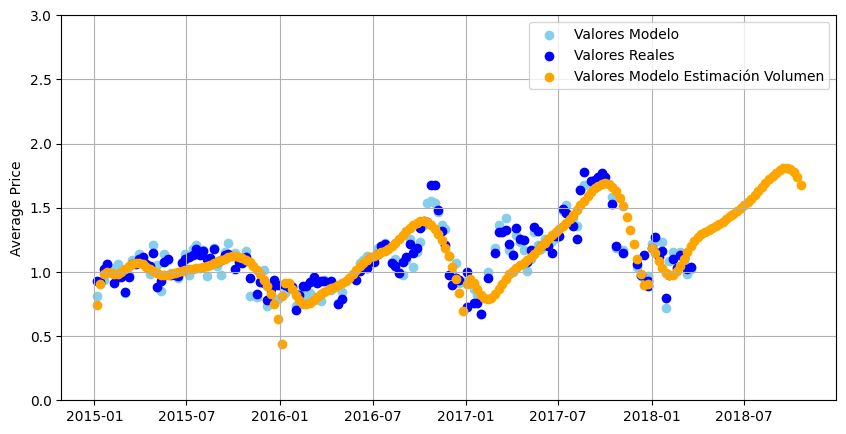

In [355]:
X_for_price_temp = X_for_price.copy()

fig, ax= plt.subplots(figsize= (10,5))

tipo_aguacate_plot = 0

y_pred_plot = y_pred_price_train[X_train_price['type_Bool']==tipo_aguacate_plot]
Y_to_plot = y_train_price[X_train_price['type_Bool']==tipo_aguacate_plot]
X_to_plot = X_train_price[X_train_price['type_Bool']==tipo_aguacate_plot]


X_to_plot.loc[:,'Date'] = X_to_plot.apply(lambda x: datetime.datetime.strptime(str(int(x['year'])) +'-W'+ str(int(x['n_week'])) + '-1', "%Y-W%W-%w"), axis=1)
X_for_price_temp.loc[:,'Date'] = X_for_vol_temp.apply(lambda x: datetime.datetime.strptime(str(int(x['year'])) +'-W'+ str(int(x['n_week'])) + '-1', "%Y-W%W-%w"), axis=1)



plt.scatter(x = X_to_plot['Date'], y= y_pred_plot, color= 'Skyblue', label= 'Valores Modelo')
plt.scatter(x = X_to_plot['Date'], y= Y_to_plot, color= 'blue', label= 'Valores Reales')
plt.scatter(x = X_for_price_temp['Date'], y= Prediction_price, color= 'orange', label= 'Valores Modelo Estimación Volumen')
plt.ylim(0,3)
plt.ylabel('Average Price')
plt.grid()
plt.legend()
plt.show()
